In [276]:
import numpy as np
import tensorflow as tf
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def random_batch(X, y, batch_size):
    assert len(X) == len(y)
    rand_idx = np.random.permutation(len(X))
    for idx in np.array_split(rand_idx, batch_size):
        yield X[idx], y[idx]
        
def make_logdir(prefix=''):
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    base_dir = 'tf_logs/'
    target_dir = 'run-' + now + '/'
    if prefix:
        target_dir = prefix + '-' + target_dir
    return base_dir + target_dir

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
X_train = X_train.reshape((len(X_train),-1)).astype('float32') / 255.
X_test = X_test.reshape((len(X_test), -1)).astype('float32') / 255.

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

X_val, X_train = X_train[:5000], X_train[5000:]
y_val, y_train = y_train[:5000], y_train[5000:]

In [5]:
X_train.shape, X_val.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

In [6]:
y_train.shape, y_val.shape, y_test.shape

((55000,), (5000,), (10000,))

#### Xavier and He Initialization


In [3]:
reset_graph()

# MNIST
n_inputs = 28*28
n_hidden = 300

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
he_init = tf.variance_scaling_initializer(mode='fan_in')
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden')

#### Nonsaturating Activation Functions

In [8]:
def leaky_relu(z, name=None):
    return tf.maximum(.01*z, z, name=name)

In [16]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = .01


X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, activation=None, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope('init'):
    init = tf.global_variables_initializer()
    


In [17]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        if epoch%5==0:
            tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
            val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
            print('Epoch {:3d}, training accuracy: {:.4f}, validation accuracy: {:.4f}'.format(epoch, 
                                                                                               tr_acc, 
                                                                                               val_acc))
    test_logits = logits.eval(feed_dict={X:X_test})

Epoch   0, training accuracy: 0.9500, validation accuracy: 0.9566
Epoch   5, training accuracy: 0.9955, validation accuracy: 0.9754
Epoch  10, training accuracy: 0.9973, validation accuracy: 0.9778
Epoch  15, training accuracy: 0.9973, validation accuracy: 0.9804
Epoch  20, training accuracy: 0.9982, validation accuracy: 0.9762
Epoch  25, training accuracy: 0.9991, validation accuracy: 0.9794
Epoch  30, training accuracy: 1.0000, validation accuracy: 0.9794
Epoch  35, training accuracy: 0.9982, validation accuracy: 0.9770


In [20]:
# elu()

reset_graph()

X = tf.placeholder(shape=(None, 28*28), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, activation=None, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope('init'):
    init = tf.global_variables_initializer()

In [22]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        if epoch%5==0:
            tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
            val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
            print("Epoch {:3d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))

Epoch   0, tr-acc: 0.9309, val-acc: 0.9354
Epoch   5, tr-acc: 0.9827, val-acc: 0.9752
Epoch  10, tr-acc: 0.9945, val-acc: 0.9782
Epoch  15, tr-acc: 0.9918, val-acc: 0.9772
Epoch  20, tr-acc: 0.9982, val-acc: 0.9764
Epoch  25, tr-acc: 0.9973, val-acc: 0.9784
Epoch  30, tr-acc: 1.0000, val-acc: 0.9814
Epoch  35, tr-acc: 0.9991, val-acc: 0.9820


In [27]:
# selu
reset_graph()

he_init = tf.variance_scaling_initializer(scale=1.0, mode='fan_in')

X = tf.placeholder(shape=(None, 28*28),dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, 
                              kernel_initializer=he_init, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu,
                              kernel_initializer=he_init, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, activation=None, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope('init'):
    init = tf.global_variables_initializer()

In [29]:
mean_x = X_train.mean(axis=0, keepdims=True)
std_x = X_train.std(axis=0, keepdims=True) + 1e-6

X_val_std = (X_val - mean_x) / std_x

In [30]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            X_batch = (X_batch - mean_x) / std_x
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        if epoch%5==0:
            tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
            val_acc = accuracy.eval(feed_dict={X:X_val_std, y:y_val})
            print("Epoch {:3d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))

Epoch   0, tr-acc: 0.9500, val-acc: 0.9462
Epoch   5, tr-acc: 0.9882, val-acc: 0.9666
Epoch  10, tr-acc: 0.9891, val-acc: 0.9672
Epoch  15, tr-acc: 0.9964, val-acc: 0.9684
Epoch  20, tr-acc: 0.9882, val-acc: 0.9630
Epoch  25, tr-acc: 0.9964, val-acc: 0.9642
Epoch  30, tr-acc: 0.9909, val-acc: 0.9632
Epoch  35, tr-acc: 0.9973, val-acc: 0.9676


#### Batch Normalization

In [34]:
logdir = make_logdir('batchnorm')
logdir

'tf_logs/batchnorm-run-20180816074725/'

In [39]:
reset_graph()

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')

#with tf.name_scope('dnn'):
he_init = tf.variance_scaling_initializer()
h1_before_bn = tf.layers.dense(X, n_hidden1, activation=None, 
                               kernel_initializer=he_init, name='before_bn')
bn_1 = tf.layers.batch_normalization(h1_before_bn, momentum=.9, 
                                     training=training, name='bn')
hidden1 = tf.nn.elu(bn_1, name='hidden1')

h2_before_bn = tf.layers.dense(hidden1, n_hidden2, activation=None, kernel_initializer=he_init)
bn_2 = tf.layers.batch_normalization(h2_before_bn, momentum=.9, training=training)
hidden2 = tf.nn.elu(bn_2, name='hidden2')

logits_before_bn = tf.layers.dense(hidden2, n_outputs, activation=None, kernel_initializer=he_init)
logits_bn = tf.layers.batch_normalization(logits_before_bn, momentum=.9, 
                                              training=training, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_bn, labels=y)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    with tf.control_dependencies(update_ops):
        training_op = optimizer.minimize(loss)
        
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits_bn, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope('init'):
    init = tf.global_variables_initializer()
    
file_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())

In [36]:
tf.get_collection(tf.GraphKeys.UPDATE_OPS)

[<tf.Operation 'dnn/batch_normalization/cond_2/Merge' type=Merge>,
 <tf.Operation 'dnn/batch_normalization/cond_3/Merge' type=Merge>,
 <tf.Operation 'dnn/batch_normalization_1/cond_2/Merge' type=Merge>,
 <tf.Operation 'dnn/batch_normalization_1/cond_3/Merge' type=Merge>,
 <tf.Operation 'dnn/outputs/cond_2/Merge' type=Merge>,
 <tf.Operation 'dnn/outputs/cond_3/Merge' type=Merge>]

In [40]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch, training:True})
            
        if epoch%5==0:
            tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
            val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
            print("Epoch {:2d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))

Epoch  0, tr-acc: 0.9318, val-acc: 0.9424
Epoch  5, tr-acc: 0.9809, val-acc: 0.9762
Epoch 10, tr-acc: 0.9973, val-acc: 0.9796
Epoch 15, tr-acc: 1.0000, val-acc: 0.9836
Epoch 20, tr-acc: 1.0000, val-acc: 0.9866
Epoch 25, tr-acc: 1.0000, val-acc: 0.9866
Epoch 30, tr-acc: 1.0000, val-acc: 0.9834
Epoch 35, tr-acc: 1.0000, val-acc: 0.9880


#### Gradient Clipping

In [69]:
# 28*28 -> 300 -> 50 -> 50 -> 50 -> 50 -> 10
logdir = make_logdir('gradient_clip')

reset_graph()

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

with tf.name_scope('dnn'):
    hidden = X
    for n, name in zip([300, 50, 50, 50, 50, 10], ['h1', 'h2', 'h3', 'h4', 'h5', 'outputs']):
        hidden = tf.layers.dense(hidden, n, name=name, activation=tf.nn.relu)
    logits = hidden
    
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name='loss')

optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
threshold = 1.
clipped_grads_and_vars = [(tf.clip_by_value(grad, -threshold, threshold), var) 
                          for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(clipped_grads_and_vars)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope('init'):
    init = tf.global_variables_initializer()
    
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())

In [70]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})

        if epoch%5==0:
            tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
            val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
            print("Epoch {:2d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))
    saver.save(sess, './my_final_model.ckpt')

Epoch  0, tr-acc: 0.9009, val-acc: 0.9204
Epoch  5, tr-acc: 0.9700, val-acc: 0.9678
Epoch 10, tr-acc: 0.9827, val-acc: 0.9758
Epoch 15, tr-acc: 0.9955, val-acc: 0.9846
Epoch 20, tr-acc: 0.9991, val-acc: 0.9852
Epoch 25, tr-acc: 0.9982, val-acc: 0.9810
Epoch 30, tr-acc: 0.9964, val-acc: 0.9830
Epoch 35, tr-acc: 0.9982, val-acc: 0.9814


#### Reusing Pretrained Layers

In [107]:
reset_graph()

saver = tf.train.import_meta_graph('my_final_model.ckpt.meta')

In [108]:
g = tf.get_default_graph()

In [109]:
for op in g.get_operations():
    print(op.name)

X
y
h1/kernel/Initializer/random_uniform/shape
h1/kernel/Initializer/random_uniform/min
h1/kernel/Initializer/random_uniform/max
h1/kernel/Initializer/random_uniform/RandomUniform
h1/kernel/Initializer/random_uniform/sub
h1/kernel/Initializer/random_uniform/mul
h1/kernel/Initializer/random_uniform
h1/kernel
h1/kernel/Assign
h1/kernel/read
h1/bias/Initializer/zeros
h1/bias
h1/bias/Assign
h1/bias/read
dnn/h1/MatMul
dnn/h1/BiasAdd
dnn/h1/Relu
h2/kernel/Initializer/random_uniform/shape
h2/kernel/Initializer/random_uniform/min
h2/kernel/Initializer/random_uniform/max
h2/kernel/Initializer/random_uniform/RandomUniform
h2/kernel/Initializer/random_uniform/sub
h2/kernel/Initializer/random_uniform/mul
h2/kernel/Initializer/random_uniform
h2/kernel
h2/kernel/Assign
h2/kernel/read
h2/bias/Initializer/zeros
h2/bias
h2/bias/Assign
h2/bias/read
dnn/h2/MatMul
dnn/h2/BiasAdd
dnn/h2/Relu
h3/kernel/Initializer/random_uniform/shape
h3/kernel/Initializer/random_uniform/min
h3/kernel/Initializer/random_uni

In [110]:
X = g.get_tensor_by_name('X:0')
y = g.get_tensor_by_name('y:0')

accuracy = g.get_tensor_by_name('eval/accuracy:0')

training_op = g.get_operation_by_name('Adam')

In [111]:
for op in [X, y, accuracy, training_op]:
    tf.add_to_collection('my_important_op', op)

In [112]:
X, y, accuracy, training_op = tf.get_collection('my_important_op')

In [113]:
with tf.Session() as sess:
    saver.restore(sess, 'my_final_model.ckpt')
    
    print(accuracy.eval(feed_dict={X:X_val, y:y_val}))
    
    saver.save(sess, './my_final_model.ckpt')

INFO:tensorflow:Restoring parameters from my_final_model.ckpt
0.9788


In [114]:
reset_graph()

saver = tf.train.import_meta_graph('my_final_model.ckpt.meta')
g = tf.get_default_graph()

In [115]:
g.get_collection('my_important_op')

[<tf.Tensor 'X:0' shape=(?, 784) dtype=float32>,
 <tf.Tensor 'y:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'eval/accuracy:0' shape=() dtype=float32>,
 <tf.Operation 'Adam' type=NoOp>]

In [118]:
reset_graph()

saver = tf.train.import_meta_graph('./my_final_model.ckpt.meta')
g = tf.get_default_graph()

In [132]:
reuse_vars = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='h[123]')
restore_saver = tf.train.Saver(var_list=reuse_vars)  # to restore h1,h2,h3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

X = g.get_tensor_by_name('X:0')
y = g.get_tensor_by_name('y:0')
trainin_op = g.get_operation_by_name('Adam')
acc = g.get_operation_by_name('eval/accuracy').values()[0]

with tf.Session() as sess:
    sess.run(init)
    restore_saver.restore(sess, './my_final_model.ckpt')
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(trainin_op, feed_dict={X:X_batch, y:y_batch})
        if epoch%5==0:
            tr_acc = sess.run(acc, feed_dict={X:X_batch, y:y_batch})
            val_acc = sess.run(acc, feed_dict={X:X_val, y:y_val})
            print("Epoch {:2d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))

INFO:tensorflow:Restoring parameters from ./my_final_model.ckpt
Epoch  0, tr-acc: 0.9964, val-acc: 0.9772
Epoch  5, tr-acc: 0.9900, val-acc: 0.9744
Epoch 10, tr-acc: 0.9964, val-acc: 0.9800
Epoch 15, tr-acc: 0.9973, val-acc: 0.9808
Epoch 20, tr-acc: 1.0000, val-acc: 0.9828
Epoch 25, tr-acc: 1.0000, val-acc: 0.9816
Epoch 30, tr-acc: 0.9982, val-acc: 0.9838
Epoch 35, tr-acc: 0.9991, val-acc: 0.9816


In [135]:
g.get_tensor_by_name('eval/accuracy:0')

<tf.Tensor 'eval/accuracy:0' shape=() dtype=float32>

In [143]:
g.get_operation_by_name('eval/accuracy')

<tf.Operation 'eval/accuracy' type=Mean>

#### Reusing Models from Other Frameworks


In [162]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')

# get handle on assignment node for hidden1 variables
g = tf.get_default_graph()

weight_assign = g.get_operation_by_name('hidden1/kernel/Assign')
bias_assign = g.get_operation_by_name('hidden1/bias/Assign')

init_weight = weight_assign.inputs[1]
init_bias = bias_assign.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_weight:original_w, init_bias:original_b})
    
    print(hidden1.eval(feed_dict={X:[[10., 11.]]}))

[[ 61.  83. 105.]]


In [153]:
weight_assign.inputs[1]

<tf.Tensor 'hidden1/kernel/Initializer/random_uniform:0' shape=(2, 3) dtype=float32>

In [154]:
g.get_operations()

[<tf.Operation 'X' type=Placeholder>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/sub' type=Sub>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/mul' type=Mul>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform' type=Add>,
 <tf.Operation 'hidden1/kernel' type=VariableV2>,
 <tf.Operation 'hidden1/kernel/Assign' type=Assign>,
 <tf.Operation 'hidden1/kernel/read' type=Identity>,
 <tf.Operation 'hidden1/bias/Initializer/zeros' type=Const>,
 <tf.Operation 'hidden1/bias' type=VariableV2>,
 <tf.Operation 'hidden1/bias/Assign' type=Assign>,
 <tf.Operation 'hidden1/bias/read' type=Identity>,
 <tf.Operation 'hidden1/MatMul' type=MatMul>,
 <tf.Op

In [156]:
g.get_operation_by_name('hidden1/kernel/Initializer/random_uniform').values()

(<tf.Tensor 'hidden1/kernel/Initializer/random_uniform:0' shape=(2, 3) dtype=float32>,)

In [158]:
g.get_operation_by_name('hidden1/bias/Initializer/zeros').values()

(<tf.Tensor 'hidden1/bias/Initializer/zeros:0' shape=(3,) dtype=float32>,)

In [160]:
bias_assign.inputs[1]

<tf.Tensor 'hidden1/bias/Initializer/zeros:0' shape=(3,) dtype=float32>

In [172]:
w_var, b_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='hidden1')
w_var, b_var

(<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>)

In [173]:
g.get_tensor_by_name('hidden1/bias:0')

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

In [175]:
g.get_tensor_by_name('hidden1/kernel:0')

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

#### Freezing the Lower Layers


In [192]:
reset_graph()

n_inputs = 28 * 28  # MNIST


reset_graph()

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

with tf.name_scope('dnn'):
    hidden = X
    for n, name in zip([300, 50, 50, 50, 50, 10], ['h1', 'h2', 'h3', 'h4', 'h5', 'outputs']):
        hidden = tf.layers.dense(hidden, n, name=name, activation=tf.nn.relu)
    logits = hidden
    
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name='loss')

optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
threshold = 1.
clipped_grads_and_vars = [(tf.clip_by_value(grad, -threshold, threshold), var) 
                          for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(clipped_grads_and_vars)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='h[45]|outputs')
    train_ops = optimizer.minimize(loss, var_list=train_vars)

In [193]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='h[123]')
reuse_saver = tf.train.Saver(var_list=reuse_vars)

In [194]:
with tf.name_scope('init'):
    init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [196]:
with tf.Session() as sess:
    init.run()
    reuse_saver.restore(sess, './my_final_model.ckpt')
    
    for epoch in range(5):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(train_ops, feed_dict={X:X_batch, y:y_batch})
        tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print('epoch {}, tr-acc: {:.4f}, val-acc: {:.4f}'.format(epoch, tr_acc, val_acc))

INFO:tensorflow:Restoring parameters from ./my_final_model.ckpt
epoch 0, tr-acc: 0.8300, val-acc: 0.8344
epoch 1, tr-acc: 0.8545, val-acc: 0.8550
epoch 2, tr-acc: 0.8891, val-acc: 0.8766
epoch 3, tr-acc: 0.9091, val-acc: 0.8938
epoch 4, tr-acc: 0.9164, val-acc: 0.9078


In [199]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")         
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")  
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")  
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")  
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                          

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy: 0.213
1 Validation accuracy: 0.3088
2 Validation accuracy: 0.4096
3 Validation accuracy: 0.5082
4 Validation accuracy: 0.6132
5 Validation accuracy: 0.6616
6 Validation accuracy: 0.7034
7 Validation accuracy: 0.739
8 Validation accuracy: 0.7724
9 Validation accuracy: 0.8016
10 Validation accuracy: 0.8202
11 Validation accuracy: 0.831
12 Validation accuracy: 0.8466
13 Validation accuracy: 0.8584
14 Validation accuracy: 0.8676
15 Validation accuracy: 0.8728
16 Validation accuracy: 0.881
17 Validation accuracy: 0.8842
18 Validation accuracy: 0.8892
19 Validation accuracy: 0.89
20 Validation accuracy: 0.8922
21 Validation accuracy: 0.8976
22 Validation accuracy: 0.898
23 Validation accuracy: 0.9012
24 Validation accuracy: 0.9024
25 Validation accuracy: 0.9048
26 Validation accuracy: 0.9066
27 Validation accuracy: 0.9104
28 Validation accuracy: 0.9116
29 Validation accuracy: 0.9134
30 Validation accuracy: 0.9172
31 Validation accuracy: 0.916
32 Validation accuracy: 0.

In [220]:
reset_graph()


n_hidden4 = 20  # new!
n_outputs = 10  # new!
# reuse hidden123
# add new hidden4, outputs

saver = tf.train.import_meta_graph('./my_new_model_final.ckpt.meta')
g = tf.get_default_graph()

hidden3 = g.get_tensor_by_name('dnn/hidden3/Relu:0')
with tf.name_scope('dnn'):
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4')
    logits = tf.layers.dense(hidden4, n_outputs, activation=None, name='outputs')
    
X = g.get_tensor_by_name('X:0')
y = g.get_tensor_by_name('y:0')
loss = g.get_tensor_by_name('loss/loss:0')
accuracy = g.get_tensor_by_name('eval/accuracy:0')

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='hidden4|outputs')
    train_op = optimizer.minimize(loss, var_list=train_vars)
    
reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='hidden[123]')
reuse_saver = tf.train.Saver(var_list=reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [221]:
with tf.Session() as sess:
    init.run()
    reuse_saver.restore(sess, './my_new_model_final.ckpt')
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final2.ckpt")

INFO:tensorflow:Restoring parameters from ./my_new_model_final.ckpt
0 Validation accuracy: 0.917
1 Validation accuracy: 0.9206
2 Validation accuracy: 0.9228
3 Validation accuracy: 0.924
4 Validation accuracy: 0.9254
5 Validation accuracy: 0.9262
6 Validation accuracy: 0.9282
7 Validation accuracy: 0.9272
8 Validation accuracy: 0.9276
9 Validation accuracy: 0.9278
10 Validation accuracy: 0.9274
11 Validation accuracy: 0.9278
12 Validation accuracy: 0.9276
13 Validation accuracy: 0.9276
14 Validation accuracy: 0.9278
15 Validation accuracy: 0.928
16 Validation accuracy: 0.9276
17 Validation accuracy: 0.9278
18 Validation accuracy: 0.9276
19 Validation accuracy: 0.9274
20 Validation accuracy: 0.9276
21 Validation accuracy: 0.9278
22 Validation accuracy: 0.9276
23 Validation accuracy: 0.9282
24 Validation accuracy: 0.9278
25 Validation accuracy: 0.9286
26 Validation accuracy: 0.9282
27 Validation accuracy: 0.9276
28 Validation accuracy: 0.9276
29 Validation accuracy: 0.9282
30 Validation a

#### Learning rate scheduling

In [224]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, activation=None, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    decay_rate = 1./10
    decay_steps = 10000
    global_step = tf.Variable(0, trainable=False, name='global_step')
    init_learning_rate = .1
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, 
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=.9)
    trainin_op = optimizer.minimize(loss, global_step=global_step)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
init = tf.global_variables_initializer()

In [226]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(trainin_op, feed_dict={X:X_batch, y:y_batch})
        
        tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print("Epoch {:2d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))
    print(global_step.eval())

Epoch  0, tr-acc: 0.9145, val-acc: 0.9256
Epoch  1, tr-acc: 0.9518, val-acc: 0.9524
Epoch  2, tr-acc: 0.9655, val-acc: 0.9646
Epoch  3, tr-acc: 0.9782, val-acc: 0.9684
Epoch  4, tr-acc: 0.9764, val-acc: 0.9724
250


#### $\ell_1$ and $\ell_2$ regularization

In [232]:
n_inputs = 28*28
n_hidden1 = 300
n_outputs = 10

reset_graph()

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
    logits = tf.layers.dense(hidden1, n_outputs, activation=None, name='outputs')
    
W1 = tf.get_default_graph().get_tensor_by_name('hidden1/kernel:0')
W2 = tf.get_default_graph().get_tensor_by_name('outputs/kernel:0')
scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    base_loss = tf.reduce_mean(xentropy, name='avg_xentropy')
    reg_loss = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2)) 
    loss = tf.add(base_loss, scale*reg_loss, name='loss')
    
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=.01)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
init = tf.global_variables_initializer()

In [233]:
n_epochs = 15
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print("Epoch {:2d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))

Epoch  0, tr-acc: 0.8909, val-acc: 0.9020
Epoch  1, tr-acc: 0.9245, val-acc: 0.9186
Epoch  2, tr-acc: 0.9155, val-acc: 0.9254
Epoch  3, tr-acc: 0.9382, val-acc: 0.9314
Epoch  4, tr-acc: 0.9255, val-acc: 0.9342
Epoch  5, tr-acc: 0.9345, val-acc: 0.9404
Epoch  6, tr-acc: 0.9473, val-acc: 0.9416
Epoch  7, tr-acc: 0.9536, val-acc: 0.9424
Epoch  8, tr-acc: 0.9473, val-acc: 0.9420
Epoch  9, tr-acc: 0.9500, val-acc: 0.9418
Epoch 10, tr-acc: 0.9427, val-acc: 0.9468
Epoch 11, tr-acc: 0.9536, val-acc: 0.9494
Epoch 12, tr-acc: 0.9309, val-acc: 0.9406
Epoch 13, tr-acc: 0.9400, val-acc: 0.9418
Epoch 14, tr-acc: 0.9482, val-acc: 0.9508


In [235]:
from functools import partial

In [237]:

n_inputs = 28*28
n_hidden1 = 300
n_outputs = 10
scale = 0.001 # l1 regularization hyperparameter

reset_graph()

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

my_dense = partial(tf.layers.dense, activation=tf.nn.relu,
                   kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope('dnn'):
    hidden1 = my_dense(X, n_hidden1, name='hidden1')
    logits = my_dense(hidden1, n_outputs, activation=None, name='outputs')
    

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    base_loss = tf.reduce_mean(xentropy, name='avg_xentropy')
    reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) 
    loss = tf.add_n([base_loss] + reg_loss, name='loss')
    
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=.01)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
init = tf.global_variables_initializer()

In [238]:
n_epochs = 15
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print("Epoch {:2d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))

Epoch  0, tr-acc: 0.9009, val-acc: 0.9026
Epoch  1, tr-acc: 0.9255, val-acc: 0.9180
Epoch  2, tr-acc: 0.9100, val-acc: 0.9248
Epoch  3, tr-acc: 0.9345, val-acc: 0.9292
Epoch  4, tr-acc: 0.9300, val-acc: 0.9310
Epoch  5, tr-acc: 0.9300, val-acc: 0.9346
Epoch  6, tr-acc: 0.9518, val-acc: 0.9402
Epoch  7, tr-acc: 0.9582, val-acc: 0.9376
Epoch  8, tr-acc: 0.9464, val-acc: 0.9358
Epoch  9, tr-acc: 0.9536, val-acc: 0.9394
Epoch 10, tr-acc: 0.9355, val-acc: 0.9400
Epoch 11, tr-acc: 0.9509, val-acc: 0.9404
Epoch 12, tr-acc: 0.9336, val-acc: 0.9368
Epoch 13, tr-acc: 0.9382, val-acc: 0.9416
Epoch 14, tr-acc: 0.9427, val-acc: 0.9460


#### Dropout

In [241]:
reset_graph()

dropout_rate = .5    # 1 - keep_prob
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')
is_train = tf.placeholder_with_default(False, shape=(), name='is_train')

X_dropout = tf.layers.dropout(X, rate=dropout_rate, training=is_train)

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X_dropout, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden1_dropout = tf.layers.dropout(hidden1, rate=dropout_rate, training=is_train)
    hidden2 = tf.layers.dense(hidden1_dropout, n_hidden2, activation=tf.nn.relu, name='hidden2')
    hidden2_dropout = tf.layers.dropout(hidden2, rate=dropout_rate, training=is_train)
    logits = tf.layers.dense(hidden2_dropout, n_outputs, activation=None, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate=.01, momentum=.9)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
init = tf.global_variables_initializer()

In [242]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch, is_train:True})
        
        tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print("Epoch {:2d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))

Epoch  0, tr-acc: 0.6773, val-acc: 0.6932
Epoch  1, tr-acc: 0.8136, val-acc: 0.8090
Epoch  2, tr-acc: 0.8300, val-acc: 0.8448
Epoch  3, tr-acc: 0.8582, val-acc: 0.8666
Epoch  4, tr-acc: 0.8800, val-acc: 0.8784
Epoch  5, tr-acc: 0.8800, val-acc: 0.8886
Epoch  6, tr-acc: 0.9009, val-acc: 0.8934
Epoch  7, tr-acc: 0.9045, val-acc: 0.9002
Epoch  8, tr-acc: 0.9082, val-acc: 0.9062
Epoch  9, tr-acc: 0.9073, val-acc: 0.9108
Epoch 10, tr-acc: 0.9027, val-acc: 0.9140
Epoch 11, tr-acc: 0.9345, val-acc: 0.9178
Epoch 12, tr-acc: 0.9091, val-acc: 0.9220
Epoch 13, tr-acc: 0.9209, val-acc: 0.9218
Epoch 14, tr-acc: 0.9227, val-acc: 0.9244
Epoch 15, tr-acc: 0.9209, val-acc: 0.9278
Epoch 16, tr-acc: 0.9155, val-acc: 0.9296
Epoch 17, tr-acc: 0.9282, val-acc: 0.9324
Epoch 18, tr-acc: 0.9136, val-acc: 0.9342
Epoch 19, tr-acc: 0.9055, val-acc: 0.9352


#### Max-Norm regularization

In [257]:
reset_graph()

threshold = 1.

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, activation=None, name='outputs')
    
W1 = tf.get_default_graph().get_tensor_by_name('hidden1/kernel:0')
clip_W1 = tf.clip_by_norm(W1, threshold, axes=1)
assign_clip_W1 = tf.assign(W1, clip_W1)

W2 = tf.get_default_graph().get_tensor_by_name('hidden2/kernel:0')
clip_W2 = tf.clip_by_norm(W2, threshold, axes=1)
assign_clip_W2 = tf.assign(W2, clip_W2)


with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate=.01, momentum=.9)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [258]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            assign_clip_W1.eval()
            assign_clip_W2.eval()
            
        tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print("Epoch {:2d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))

Epoch  0, tr-acc: 0.8245, val-acc: 0.8364
Epoch  1, tr-acc: 0.9000, val-acc: 0.8920
Epoch  2, tr-acc: 0.8973, val-acc: 0.9124
Epoch  3, tr-acc: 0.9200, val-acc: 0.9190
Epoch  4, tr-acc: 0.9164, val-acc: 0.9262
Epoch  5, tr-acc: 0.9164, val-acc: 0.9324
Epoch  6, tr-acc: 0.9373, val-acc: 0.9364
Epoch  7, tr-acc: 0.9509, val-acc: 0.9390
Epoch  8, tr-acc: 0.9473, val-acc: 0.9416
Epoch  9, tr-acc: 0.9464, val-acc: 0.9436
Epoch 10, tr-acc: 0.9400, val-acc: 0.9456
Epoch 11, tr-acc: 0.9509, val-acc: 0.9484
Epoch 12, tr-acc: 0.9391, val-acc: 0.9508
Epoch 13, tr-acc: 0.9482, val-acc: 0.9516
Epoch 14, tr-acc: 0.9500, val-acc: 0.9558
Epoch 15, tr-acc: 0.9527, val-acc: 0.9560
Epoch 16, tr-acc: 0.9518, val-acc: 0.9572
Epoch 17, tr-acc: 0.9582, val-acc: 0.9598
Epoch 18, tr-acc: 0.9500, val-acc: 0.9620
Epoch 19, tr-acc: 0.9473, val-acc: 0.9628


In [260]:
reset_graph()

def max_norm_regularizer(threshold, axes=1, name='max_norm', 
                         collection='max_norm'):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, threshold, axes=axes, name=name)
        clipped_assign = tf.assign(weights, clipped)
        tf.add_to_collection(collection, clipped_assign)
        return None    # no regularization loss term
    return max_norm

max_norm_reg = max_norm_regularizer(threshold=1.0)

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, 
                              kernel_regularizer=max_norm_reg, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, activation=None, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=.01)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
init = tf.global_variables_initializer()
clip_all_weights = tf.get_collection('max_norm')

In [261]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            sess.run(clip_all_weights)
        
        tr_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        val_acc = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print("Epoch {:2d}, tr-acc: {:.4f}, val-acc: {:.4f}".format(epoch, tr_acc, val_acc))

Epoch  0, tr-acc: 0.9500, val-acc: 0.9606
Epoch  1, tr-acc: 0.9745, val-acc: 0.9742
Epoch  2, tr-acc: 0.9791, val-acc: 0.9742
Epoch  3, tr-acc: 0.9845, val-acc: 0.9686
Epoch  4, tr-acc: 0.9891, val-acc: 0.9762
Epoch  5, tr-acc: 0.9909, val-acc: 0.9778
Epoch  6, tr-acc: 0.9918, val-acc: 0.9762
Epoch  7, tr-acc: 0.9927, val-acc: 0.9754
Epoch  8, tr-acc: 0.9900, val-acc: 0.9744
Epoch  9, tr-acc: 0.9882, val-acc: 0.9736
Epoch 10, tr-acc: 0.9918, val-acc: 0.9748
Epoch 11, tr-acc: 0.9800, val-acc: 0.9764
Epoch 12, tr-acc: 0.9809, val-acc: 0.9786
Epoch 13, tr-acc: 0.9864, val-acc: 0.9754
Epoch 14, tr-acc: 0.9891, val-acc: 0.9750
Epoch 15, tr-acc: 0.9873, val-acc: 0.9776
Epoch 16, tr-acc: 0.9873, val-acc: 0.9798
Epoch 17, tr-acc: 0.9882, val-acc: 0.9774
Epoch 18, tr-acc: 0.9836, val-acc: 0.9774
Epoch 19, tr-acc: 0.9918, val-acc: 0.9778


#### ex.8

In [7]:
idx_0_to_4 = y_train <= 4
idx_5_to_9 = y_train > 4

X_train_01234 = X_train[idx_0_to_4]
y_train_01234 = y_train[idx_0_to_4]
X_train_56789 = X_train[idx_5_to_9]
y_train_56789 = y_train[idx_5_to_9]

idx_0_to_4 = y_val <= 4
idx_5_to_9 = y_val > 4

X_val_01234 = X_val[idx_0_to_4]
y_val_01234 = y_val[idx_0_to_4]
X_val_56789 = X_val[idx_5_to_9]
y_val_56789 = y_val[idx_5_to_9]

idx_0_to_4 = y_test <= 4
idx_5_to_9 = y_test > 4
X_test_01234 = X_test[idx_0_to_4]
y_test_01234 = y_test[idx_0_to_4]
X_test_56789 = X_test[idx_5_to_9]
y_test_56789 = y_test[idx_5_to_9]

In [8]:
np.unique(y_train_01234), np.unique(y_train_56789)

(array([0, 1, 2, 3, 4]), array([5, 6, 7, 8, 9]))

In [9]:
np.unique(y_val_01234), np.unique(y_val_56789)

(array([0, 1, 2, 3, 4]), array([5, 6, 7, 8, 9]))

In [10]:
np.unique(y_test_01234), np.unique(y_test_56789)

(array([0, 1, 2, 3, 4]), array([5, 6, 7, 8, 9]))

In [11]:
from functools import partial

In [12]:
reset_graph()

n_inputs = 28*28
n_hidden = 100
n_outputs = 5    # 0-4

learning_rate = .01

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')

he_init = tf.variance_scaling_initializer()
my_dense = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_init)
with tf.name_scope('dnn'):
    h1 = my_dense(X, n_hidden, name='h1')
    h2 = my_dense(h1, n_hidden, name='h2')
    h3 = my_dense(h2, n_hidden, name='h3')
    h4 = my_dense(h3, n_hidden, name='h4')
    h5 = my_dense(h4, n_hidden, name='h5')
    logits = tf.layers.dense(h5, n_outputs, activation=None, name='outputs')
    y_proba = tf.nn.softmax(logits, axis=1, name='y_proba')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
n_epochs = 1000
batch_size = 20

no_progress_count = 0
max_no_progress = 20
best_loss = np.infty
best_loss_acc = None


with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train_01234, y_train_01234, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        val_loss, val_acc = sess.run([loss, accuracy], feed_dict={X:X_val_01234, y:y_val_01234})
        
        if val_loss < best_loss:
            no_progress_count = 0
            best_loss = val_loss
            best_loss_acc = val_acc
            saver.save(sess, './my_mnist_model_0_to_4.ckpt')
        else:
            no_progress_count += 1
            if no_progress_count > max_no_progress:
                print("Early stop at {} epoch".format(epoch))
                print("Best val-loss: {:.4f} at val-acc: {:.4f}".format(best_loss, best_loss_acc))
                break
        print("Epoch {:4d}, val-loss: {:.4f}, val-acc: {:.4f}".format(epoch, val_loss, val_acc))

Epoch    0, val-loss: 0.1814, val-acc: 0.9418
Epoch    1, val-loss: 0.0988, val-acc: 0.9707
Epoch    2, val-loss: 0.0767, val-acc: 0.9762
Epoch    3, val-loss: 0.0704, val-acc: 0.9781
Epoch    4, val-loss: 0.0558, val-acc: 0.9836
Epoch    5, val-loss: 0.0555, val-acc: 0.9820
Epoch    6, val-loss: 0.0504, val-acc: 0.9848
Epoch    7, val-loss: 0.0417, val-acc: 0.9891
Epoch    8, val-loss: 0.0419, val-acc: 0.9875
Epoch    9, val-loss: 0.0523, val-acc: 0.9863
Epoch   10, val-loss: 0.0456, val-acc: 0.9871
Epoch   11, val-loss: 0.0471, val-acc: 0.9863
Epoch   12, val-loss: 0.0403, val-acc: 0.9894
Epoch   13, val-loss: 0.0372, val-acc: 0.9887
Epoch   14, val-loss: 0.0493, val-acc: 0.9867
Epoch   15, val-loss: 0.0496, val-acc: 0.9867
Epoch   16, val-loss: 0.0425, val-acc: 0.9894
Epoch   17, val-loss: 0.0575, val-acc: 0.9863
Epoch   18, val-loss: 0.0434, val-acc: 0.9855
Epoch   19, val-loss: 0.0461, val-acc: 0.9883
Epoch   20, val-loss: 0.0407, val-acc: 0.9898
Epoch   21, val-loss: 0.0486, val-

In [280]:
with tf.Session() as sess:
    saver.restore(sess, './my_mnist_model_0_to_4.ckpt')
    
    test_acc = sess.run(accuracy, feed_dict={X:X_test_01234, y:y_test_01234})
    print("Final test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_0_to_4.ckpt
Final test accuracy: 0.9905


In [284]:
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    print(var.op.name)

h1/kernel
h1/bias
h2/kernel
h2/bias
h3/kernel
h3/bias
h4/kernel
h4/bias
h5/kernel
h5/bias
outputs/kernel
outputs/bias
train/beta1_power
train/beta2_power
h1/kernel/Adam
h1/kernel/Adam_1
h1/bias/Adam
h1/bias/Adam_1
h2/kernel/Adam
h2/kernel/Adam_1
h2/bias/Adam
h2/bias/Adam_1
h3/kernel/Adam
h3/kernel/Adam_1
h3/bias/Adam
h3/bias/Adam_1
h4/kernel/Adam
h4/kernel/Adam_1
h4/bias/Adam
h4/bias/Adam_1
h5/kernel/Adam
h5/kernel/Adam_1
h5/bias/Adam
h5/bias/Adam_1
outputs/kernel/Adam
outputs/kernel/Adam_1
outputs/bias/Adam
outputs/bias/Adam_1




Let's create a DNNClassifier class, compatible with Scikit-Learn's RandomizedSearchCV class, to perform hyperparameter tuning. Here are the key points of this implementation:

    the __init__() method (constructor) does nothing more than create instance variables for each of the hyperparameters.
    the fit() method creates the graph, starts a session and trains the model:
        it calls the _build_graph() method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
        the _dnn() method builds the hidden layers, just like the dnn() function above, but also with support for batch normalization and dropout (for the next exercises).
        if the fit() method is given a validation set (X_valid and y_valid), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the _get_model_params() method to get all the graph's variables and their values, and the _restore_model_params() method to restore the variable values (of the best model found). This trick helps speed up training.
        After the fit() method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the close_session() method.
    the predict_proba() method uses the trained model to predict the class probabilities.
    the predict() method calls predict_proba() and returns the class with the highest probability, for each instance.



In [79]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score

In [106]:
he_init = tf.variance_scaling_initializer()


class DNNClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer=tf.train.AdamOptimizer, 
                 learning_rate=.01, batch_size=20, kernel_initializer=he_init, activation=tf.nn.elu, 
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        '''initialize DNNClassifier by storing hyperparameters'''
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.kernel_initializer = kernel_initializer
        self.activation = activation
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None
        
    def _dnn(self, inputs):
        '''build hidden layers that can support batch normalization and dropout layers'''
        for i in range(1, self.n_hidden_layers+1):
            # dropout -> dense -> batch_norm -> activation
            if self.dropout_rate is not None:
                inputs = tf.layers.dropout(inputs, rate=self.dropout_rate)
            inputs = tf.layers.dense(inputs, self.n_neurons, activation=None,
                                     kernel_initializer=self.kernel_initializer,
                                     name="hidden{}".format(i))
            if self.batch_norm_momentum is not None:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum)
            inputs = self.activation(inputs, name='hidden{}_out'.format(i))
        return inputs  
    
    def _build_graph(self, n_inputs, n_outputs):
        
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
        
        # init placeholder
        X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
        y = tf.placeholder(shape=(None,), dtype=tf.int32, name='y')
        
        if self.batch_norm_momentum is not None or self.dropout_rate is not None:
            is_training = tf.placeholder_with_default(False, shape=(), name='is_training')
        else:
            is_training = None
        
        # dense layers
        hidden_out = self._dnn(X)
        
        # output layer
        logits = tf.layers.dense(hidden_out, n_outputs, activation=None, name='outputs')
        y_proba = tf.nn.softmax(logits, axis=1, name='y_proba')
        
        # compute loss function
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy, name='loss')
        
        # training operation
        optimizer = self.optimizer(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)
        
        # evaluation metric
        correct = tf.nn.in_top_k(logits, y, k=1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
        
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        
        # make instance variables for important operations
        self._X, self._y, self._is_training = X, y, is_training
        self._logits, self._y_proba = logits, y_proba
        self._loss = loss
        self._training_op = training_op
        self._accuracy = accuracy
        self._init, self._saver = init, saver
        
    def close_session(self):
        if self._session:
            self._session.close()

    
    def _get_model_params(self):
        '''get all current values of all variables by its name'''
        with self._graph.as_default():
            variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {var.op.name:val for var, val in zip(variables, self._session.run(variables))}
        
    def _restore_model_params(self, params):
        varnames = list(params.keys())
        assign_ops ={name:self._graph.get_operation_by_name(name+'/Assign') for name in varnames}
        assing_inputs = {name:assign_op.inputs[1] for name, assign_op in assign_ops.items()}
        feed_dict = {assing_inputs[varname]:params[varname] for varname in varnames}
        self._session.run(assign_ops, feed_dict=feed_dict)
        
    def fit(self, X, y, n_epochs=100, X_val=None, y_val=None):
        '''fit model to training set, use early stopping if X_val, y_val provided'''
        reset_graph()
        n_inputs = X.shape[1]
        self.labels_ = np.unique(y)
        n_outputs = len(self.labels_)
        self.label_to_index_ = dict(zip(self.labels_, range(n_outputs)))
        
        y = np.array([self.label_to_index_[label] for label in y], dtype=np.int32)
        
        # build graph according to n_inputs and n_outputs
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            
        # early stop setting
        best_loss = np.infty
        self.best_params_ = None
        max_no_progress = 20
        no_progress_count = 0
        
        # training session
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            sess.run(self._init)
            for epoch in range(n_epochs):
                for X_batch, y_batch in random_batch(X, y, self.batch_size):
                    feed_dict = {self._X:X_batch, self._y:y_batch}
                    if self._is_training is not None:
                        feed_dict[self._is_training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    
                    # variable related to batch normalization, dropout layers
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                
                if X_val is not None and y_val is not None:
                    feed_dict = {self._X:X_val, self._y:y_val}
                    val_loss, val_acc = sess.run([self._loss, self._accuracy], feed_dict=feed_dict)
                    
                    if val_loss < best_loss:
                        best_loss = val_loss
                        self.best_params_ = self._get_model_params()
                        no_progress_count = 0
                    else:
                        no_progress_count += 1
                    
                    if no_progress_count > max_no_progress:
                        print("Early Stop at epoch", epoch)
                        break
                    print("Epoch {:5d}, val-loss: {:.4f}, val-acc: {:.3f}, best-loss: {:.4f}".format(epoch,
                                                                                                     val_loss, 
                                                                                                     val_acc, 
                                                                                                     best_loss))
                else:
                    tr_loss, tr_acc = sess.run([self._loss, self._accuracy], 
                                               feed_dict={self._X:X_batch, self._y:y_batch})
                    print("Epoch {:5d}, tr-loss: {:.4f}, tr-acc: {:.3f}".format(epoch, tr_loss, tr_acc))
            
            if self.best_params_ is not None:
                self._restore_model_params(self.best_params_)
            return self
        
    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError('This %s is not fitted yet' % self.__class__.__name__)
        with self._session.as_default() as sess:
            return sess.run(self._y_proba, feed_dict={self._X:X})
    
    def predict(self, X):
        y_proba = self.predict_proba(X)
        indices = np.argmax(y_proba, axis=1)
        return self.labels_[indices]
    
    def save(self, path):
        self._saver.save(self._session, path)

In [88]:
dnn = DNNClassifier(random_state=42)

In [89]:
dnn.fit(X_train_01234, y_train_01234, 1000, X_val_01234, y_val_01234)

Epoch     0, val-loss: 0.1814, val-acc: 0.942, best-loss: 0.1814
Epoch     1, val-loss: 0.0988, val-acc: 0.971, best-loss: 0.0988
Epoch     2, val-loss: 0.0767, val-acc: 0.976, best-loss: 0.0767
Epoch     3, val-loss: 0.0704, val-acc: 0.978, best-loss: 0.0704
Epoch     4, val-loss: 0.0558, val-acc: 0.984, best-loss: 0.0558
Epoch     5, val-loss: 0.0555, val-acc: 0.982, best-loss: 0.0555
Epoch     6, val-loss: 0.0504, val-acc: 0.985, best-loss: 0.0504
Epoch     7, val-loss: 0.0417, val-acc: 0.989, best-loss: 0.0417
Epoch     8, val-loss: 0.0419, val-acc: 0.987, best-loss: 0.0417
Epoch     9, val-loss: 0.0523, val-acc: 0.986, best-loss: 0.0417
Epoch    10, val-loss: 0.0456, val-acc: 0.987, best-loss: 0.0417
Epoch    11, val-loss: 0.0471, val-acc: 0.986, best-loss: 0.0417
Epoch    12, val-loss: 0.0403, val-acc: 0.989, best-loss: 0.0403
Epoch    13, val-loss: 0.0372, val-acc: 0.989, best-loss: 0.0372
Epoch    14, val-loss: 0.0493, val-acc: 0.987, best-loss: 0.0372
Epoch    15, val-loss: 0.

DNNClassifier(activation=<function elu at 0x0000021301F826A8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       kernel_initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000021423DA0EF0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [90]:
accuracy_score(y_val_01234, dnn.predict(X_val_01234))

0.9886630179827991

In [91]:
dnn.close_session()

In [110]:
from sklearn.model_selection import RandomizedSearchCV

In [111]:
params = {
   # 'n_hidden_layers': range(2, 11),
    'n_neurons': range(20, 200),
    'learning_rate': [.05, .02, .01, .1],
    'batch_size': range(10, 501, 10),
    'activation': [tf.nn.relu, tf.nn.elu, tf.nn.leaky_relu]
}

In [112]:
rnd_dnn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distributions=params,
                             n_iter=50, random_state=42, verbose=2)

In [113]:
rnd_dnn.fit(X_train_01234, y_train_01234, X_val=X_val_01234, y_val=y_val_01234, n_epochs=1000)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=155, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.1, batch_size=220 
Epoch     0, val-loss: 1.6103, val-acc: 0.187, best-loss: 1.6103
Epoch     1, val-loss: 1.6138, val-acc: 0.193, best-loss: 1.6103
Epoch     2, val-loss: 1.6090, val-acc: 0.220, best-loss: 1.6090
Epoch     3, val-loss: 1.6097, val-acc: 0.220, best-loss: 1.6090
Epoch     4, val-loss: 1.6189, val-acc: 0.220, best-loss: 1.6090
Epoch     5, val-loss: 1.6125, val-acc: 0.220, best-loss: 1.6090
Epoch     6, val-loss: 1.6094, val-acc: 0.220, best-loss: 1.6090
Epoch     7, val-loss: 1.6143, val-acc: 0.220, best-loss: 1.6090
Epoch     8, val-loss: 1.6181, val-acc: 0.220, best-loss: 1.6090
Epoch     9, val-loss: 1.6104, val-acc: 0.220, best-loss: 1.6090
Epoch    10, val-loss: 1.6080, val-acc: 0.220, best-loss: 1.6080
Epoch    11, val-loss: 1.6182, val-acc: 0.193, best-loss: 1.6080
Epoch    12, val-loss: 1.6090, val-acc: 0.220, best-l

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s


Epoch     0, val-loss: 1.4787, val-acc: 0.315, best-loss: 1.4787
Epoch     1, val-loss: 1.6098, val-acc: 0.191, best-loss: 1.4787
Epoch     2, val-loss: 1.6131, val-acc: 0.193, best-loss: 1.4787
Epoch     3, val-loss: 1.6220, val-acc: 0.187, best-loss: 1.4787
Epoch     4, val-loss: 1.6139, val-acc: 0.220, best-loss: 1.4787
Epoch     5, val-loss: 1.6127, val-acc: 0.193, best-loss: 1.4787
Epoch     6, val-loss: 1.6173, val-acc: 0.193, best-loss: 1.4787
Epoch     7, val-loss: 1.6129, val-acc: 0.220, best-loss: 1.4787
Epoch     8, val-loss: 1.6098, val-acc: 0.220, best-loss: 1.4787
Epoch     9, val-loss: 1.6092, val-acc: 0.220, best-loss: 1.4787
Epoch    10, val-loss: 1.6174, val-acc: 0.220, best-loss: 1.4787
Epoch    11, val-loss: 1.6113, val-acc: 0.187, best-loss: 1.4787
Epoch    12, val-loss: 1.6090, val-acc: 0.220, best-loss: 1.4787
Epoch    13, val-loss: 1.6132, val-acc: 0.193, best-loss: 1.4787
Epoch    14, val-loss: 1.6113, val-acc: 0.191, best-loss: 1.4787
Epoch    15, val-loss: 1.

Epoch     6, val-loss: 0.1794, val-acc: 0.952, best-loss: 0.1794
Epoch     7, val-loss: 0.1728, val-acc: 0.947, best-loss: 0.1728
Epoch     8, val-loss: 0.1576, val-acc: 0.955, best-loss: 0.1576
Epoch     9, val-loss: 0.1442, val-acc: 0.953, best-loss: 0.1442
Epoch    10, val-loss: 0.1500, val-acc: 0.953, best-loss: 0.1442
Epoch    11, val-loss: 0.1459, val-acc: 0.952, best-loss: 0.1442
Epoch    12, val-loss: 0.1520, val-acc: 0.957, best-loss: 0.1442
Epoch    13, val-loss: 0.1523, val-acc: 0.958, best-loss: 0.1442
Epoch    14, val-loss: 0.1438, val-acc: 0.959, best-loss: 0.1438
Epoch    15, val-loss: 0.1504, val-acc: 0.956, best-loss: 0.1438
Epoch    16, val-loss: 0.1655, val-acc: 0.953, best-loss: 0.1438
Epoch    17, val-loss: 0.1774, val-acc: 0.952, best-loss: 0.1438
Epoch    18, val-loss: 0.1741, val-acc: 0.956, best-loss: 0.1438
Epoch    19, val-loss: 0.1682, val-acc: 0.955, best-loss: 0.1438
Epoch    20, val-loss: 0.1432, val-acc: 0.958, best-loss: 0.1432
Epoch    21, val-loss: 0.

Epoch    11, val-loss: 0.7714, val-acc: 0.971, best-loss: 0.7714
Epoch    12, val-loss: 277.4362, val-acc: 0.952, best-loss: 0.7714
Epoch    13, val-loss: 197.0297, val-acc: 0.959, best-loss: 0.7714
Epoch    14, val-loss: 111.5928, val-acc: 0.946, best-loss: 0.7714
Epoch    15, val-loss: 134.1641, val-acc: 0.951, best-loss: 0.7714
Epoch    16, val-loss: 128.7812, val-acc: 0.941, best-loss: 0.7714
Epoch    17, val-loss: 83.0887, val-acc: 0.955, best-loss: 0.7714
Epoch    18, val-loss: 78.7063, val-acc: 0.952, best-loss: 0.7714
Epoch    19, val-loss: 131.7773, val-acc: 0.932, best-loss: 0.7714
Epoch    20, val-loss: 207.8993, val-acc: 0.956, best-loss: 0.7714
Epoch    21, val-loss: 161.6311, val-acc: 0.933, best-loss: 0.7714
Epoch    22, val-loss: 86.7927, val-acc: 0.962, best-loss: 0.7714
Epoch    23, val-loss: 78.4546, val-acc: 0.967, best-loss: 0.7714
Epoch    24, val-loss: 107.2507, val-acc: 0.961, best-loss: 0.7714
Epoch    25, val-loss: 930.2316, val-acc: 0.935, best-loss: 0.7714
E

Epoch     0, val-loss: 0.1152, val-acc: 0.967, best-loss: 0.1152
Epoch     1, val-loss: 0.0894, val-acc: 0.977, best-loss: 0.0894
Epoch     2, val-loss: 0.0769, val-acc: 0.976, best-loss: 0.0769
Epoch     3, val-loss: 0.0740, val-acc: 0.979, best-loss: 0.0740
Epoch     4, val-loss: 0.0562, val-acc: 0.986, best-loss: 0.0562
Epoch     5, val-loss: 0.0491, val-acc: 0.987, best-loss: 0.0491
Epoch     6, val-loss: 0.0642, val-acc: 0.982, best-loss: 0.0491
Epoch     7, val-loss: 0.0755, val-acc: 0.980, best-loss: 0.0491
Epoch     8, val-loss: 0.0626, val-acc: 0.982, best-loss: 0.0491
Epoch     9, val-loss: 0.0645, val-acc: 0.987, best-loss: 0.0491
Epoch    10, val-loss: 0.0568, val-acc: 0.984, best-loss: 0.0491
Epoch    11, val-loss: 0.0590, val-acc: 0.986, best-loss: 0.0491
Epoch    12, val-loss: 0.0707, val-acc: 0.982, best-loss: 0.0491
Epoch    13, val-loss: 0.0912, val-acc: 0.978, best-loss: 0.0491
Epoch    14, val-loss: 0.0527, val-acc: 0.987, best-loss: 0.0491
Epoch    15, val-loss: 0.

Epoch     9, val-loss: 0.0669, val-acc: 0.983, best-loss: 0.0634
Epoch    10, val-loss: 0.0886, val-acc: 0.982, best-loss: 0.0634
Epoch    11, val-loss: 0.2134, val-acc: 0.968, best-loss: 0.0634
Epoch    12, val-loss: 0.2030, val-acc: 0.973, best-loss: 0.0634
Epoch    13, val-loss: 0.0715, val-acc: 0.983, best-loss: 0.0634
Epoch    14, val-loss: 0.0592, val-acc: 0.985, best-loss: 0.0592
Epoch    15, val-loss: 0.0592, val-acc: 0.986, best-loss: 0.0592
Epoch    16, val-loss: 0.0504, val-acc: 0.986, best-loss: 0.0504
Epoch    17, val-loss: 0.0601, val-acc: 0.990, best-loss: 0.0504
Epoch    18, val-loss: 0.0571, val-acc: 0.988, best-loss: 0.0504
Epoch    19, val-loss: 0.0424, val-acc: 0.989, best-loss: 0.0424
Epoch    20, val-loss: 0.0905, val-acc: 0.985, best-loss: 0.0424
Epoch    21, val-loss: 0.1058, val-acc: 0.987, best-loss: 0.0424
Epoch    22, val-loss: 0.0802, val-acc: 0.987, best-loss: 0.0424
Epoch    23, val-loss: 0.0701, val-acc: 0.989, best-loss: 0.0424
Epoch    24, val-loss: 0.

Epoch     1, val-loss: 0.0827, val-acc: 0.980, best-loss: 0.0827
Epoch     2, val-loss: 0.0873, val-acc: 0.973, best-loss: 0.0827
Epoch     3, val-loss: 0.0984, val-acc: 0.975, best-loss: 0.0827
Epoch     4, val-loss: 0.0802, val-acc: 0.979, best-loss: 0.0802
Epoch     5, val-loss: 0.0921, val-acc: 0.976, best-loss: 0.0802
Epoch     6, val-loss: 0.0755, val-acc: 0.982, best-loss: 0.0755
Epoch     7, val-loss: 0.0673, val-acc: 0.980, best-loss: 0.0673
Epoch     8, val-loss: 0.1352, val-acc: 0.971, best-loss: 0.0673
Epoch     9, val-loss: 0.1060, val-acc: 0.971, best-loss: 0.0673
Epoch    10, val-loss: 62.4724, val-acc: 0.940, best-loss: 0.0673
Epoch    11, val-loss: 19.7249, val-acc: 0.955, best-loss: 0.0673
Epoch    12, val-loss: 22.8937, val-acc: 0.946, best-loss: 0.0673
Epoch    13, val-loss: 29.3610, val-acc: 0.962, best-loss: 0.0673
Epoch    14, val-loss: 17.1813, val-acc: 0.964, best-loss: 0.0673
Epoch    15, val-loss: 13.9669, val-acc: 0.968, best-loss: 0.0673
Epoch    16, val-lo

Epoch    22, val-loss: 0.0639, val-acc: 0.987, best-loss: 0.0496
Epoch    23, val-loss: 0.0734, val-acc: 0.986, best-loss: 0.0496
Epoch    24, val-loss: 0.0654, val-acc: 0.988, best-loss: 0.0496
Epoch    25, val-loss: 0.0647, val-acc: 0.986, best-loss: 0.0496
Epoch    26, val-loss: 0.0577, val-acc: 0.987, best-loss: 0.0496
Epoch    27, val-loss: 0.0971, val-acc: 0.982, best-loss: 0.0496
Epoch    28, val-loss: 0.0631, val-acc: 0.984, best-loss: 0.0496
Epoch    29, val-loss: 0.0604, val-acc: 0.987, best-loss: 0.0496
Epoch    30, val-loss: 0.0656, val-acc: 0.987, best-loss: 0.0496
Early Stop at epoch 31
[CV]  n_neurons=134, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.01, batch_size=20, total=   4.6s
[CV] n_neurons=134, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.01, batch_size=20 
Epoch     0, val-loss: 0.2069, val-acc: 0.944, best-loss: 0.2069
Epoch     1, val-loss: 0.1182, val-acc: 0.962, best-loss: 0.1182
Epoch     2, val-loss: 0.0886, val-acc:

Epoch     3, val-loss: 0.0951, val-acc: 0.973, best-loss: 0.0693
Epoch     4, val-loss: 0.0564, val-acc: 0.985, best-loss: 0.0564
Epoch     5, val-loss: 0.0529, val-acc: 0.985, best-loss: 0.0529
Epoch     6, val-loss: 0.0608, val-acc: 0.986, best-loss: 0.0529
Epoch     7, val-loss: 0.0921, val-acc: 0.982, best-loss: 0.0529
Epoch     8, val-loss: 0.0569, val-acc: 0.988, best-loss: 0.0529
Epoch     9, val-loss: 0.0538, val-acc: 0.985, best-loss: 0.0529
Epoch    10, val-loss: 0.0718, val-acc: 0.978, best-loss: 0.0529
Epoch    11, val-loss: 0.0845, val-acc: 0.979, best-loss: 0.0529
Epoch    12, val-loss: 0.0623, val-acc: 0.985, best-loss: 0.0529
Epoch    13, val-loss: 0.0503, val-acc: 0.987, best-loss: 0.0503
Epoch    14, val-loss: 0.0606, val-acc: 0.987, best-loss: 0.0503
Epoch    15, val-loss: 0.1225, val-acc: 0.983, best-loss: 0.0503
Epoch    16, val-loss: 0.1059, val-acc: 0.981, best-loss: 0.0503
Epoch    17, val-loss: 2.2469, val-acc: 0.959, best-loss: 0.0503
Epoch    18, val-loss: 0.

Epoch     0, val-loss: 0.1224, val-acc: 0.964, best-loss: 0.1224
Epoch     1, val-loss: 0.1070, val-acc: 0.968, best-loss: 0.1070
Epoch     2, val-loss: 0.0679, val-acc: 0.981, best-loss: 0.0679
Epoch     3, val-loss: 0.0959, val-acc: 0.970, best-loss: 0.0679
Epoch     4, val-loss: 0.2390, val-acc: 0.937, best-loss: 0.0679
Epoch     5, val-loss: 1.6627, val-acc: 0.220, best-loss: 0.0679
Epoch     6, val-loss: 1.6175, val-acc: 0.193, best-loss: 0.0679
Epoch     7, val-loss: 1.6635, val-acc: 0.193, best-loss: 0.0679
Epoch     8, val-loss: 1.6541, val-acc: 0.191, best-loss: 0.0679
Epoch     9, val-loss: 1.6462, val-acc: 0.193, best-loss: 0.0679
Epoch    10, val-loss: 1.6385, val-acc: 0.209, best-loss: 0.0679
Epoch    11, val-loss: 1.6464, val-acc: 0.191, best-loss: 0.0679
Epoch    12, val-loss: 1.7022, val-acc: 0.187, best-loss: 0.0679
Epoch    13, val-loss: 1.6688, val-acc: 0.193, best-loss: 0.0679
Epoch    14, val-loss: 1.7429, val-acc: 0.191, best-loss: 0.0679
Epoch    15, val-loss: 1.

Epoch     4, val-loss: 0.1445, val-acc: 0.968, best-loss: 0.0719
Epoch     5, val-loss: 0.0978, val-acc: 0.977, best-loss: 0.0719
Epoch     6, val-loss: 0.0797, val-acc: 0.984, best-loss: 0.0719
Epoch     7, val-loss: 0.0698, val-acc: 0.982, best-loss: 0.0698
Epoch     8, val-loss: 0.1027, val-acc: 0.978, best-loss: 0.0698
Epoch     9, val-loss: 0.0633, val-acc: 0.981, best-loss: 0.0633
Epoch    10, val-loss: 0.0846, val-acc: 0.975, best-loss: 0.0633
Epoch    11, val-loss: 0.0797, val-acc: 0.978, best-loss: 0.0633
Epoch    12, val-loss: 0.0667, val-acc: 0.982, best-loss: 0.0633
Epoch    13, val-loss: 0.0769, val-acc: 0.981, best-loss: 0.0633
Epoch    14, val-loss: 0.0920, val-acc: 0.977, best-loss: 0.0633
Epoch    15, val-loss: 0.0736, val-acc: 0.982, best-loss: 0.0633
Epoch    16, val-loss: 0.0929, val-acc: 0.980, best-loss: 0.0633
Epoch    17, val-loss: 0.0808, val-acc: 0.980, best-loss: 0.0633
Epoch    18, val-loss: 0.0671, val-acc: 0.984, best-loss: 0.0633
Epoch    19, val-loss: 0.

Epoch     0, val-loss: 0.1505, val-acc: 0.950, best-loss: 0.1505
Epoch     1, val-loss: 0.1158, val-acc: 0.965, best-loss: 0.1158
Epoch     2, val-loss: 0.1034, val-acc: 0.968, best-loss: 0.1034
Epoch     3, val-loss: 0.1347, val-acc: 0.962, best-loss: 0.1034
Epoch     4, val-loss: 0.0702, val-acc: 0.980, best-loss: 0.0702
Epoch     5, val-loss: 0.0834, val-acc: 0.977, best-loss: 0.0702
Epoch     6, val-loss: 1.4270, val-acc: 0.354, best-loss: 0.0702
Epoch     7, val-loss: 1.6222, val-acc: 0.220, best-loss: 0.0702
Epoch     8, val-loss: 1.6393, val-acc: 0.193, best-loss: 0.0702
Epoch     9, val-loss: 1.6186, val-acc: 0.187, best-loss: 0.0702
Epoch    10, val-loss: 1.6332, val-acc: 0.209, best-loss: 0.0702
Epoch    11, val-loss: 1.6275, val-acc: 0.187, best-loss: 0.0702
Epoch    12, val-loss: 1.6959, val-acc: 0.209, best-loss: 0.0702
Epoch    13, val-loss: 1.6302, val-acc: 0.209, best-loss: 0.0702
Epoch    14, val-loss: 1.6267, val-acc: 0.220, best-loss: 0.0702
Epoch    15, val-loss: 1.

Early Stop at epoch 22
[CV]  n_neurons=40, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.05, batch_size=410, total=  19.2s
[CV] n_neurons=40, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.05, batch_size=410 
Epoch     0, val-loss: 0.2554, val-acc: 0.932, best-loss: 0.2554
Epoch     1, val-loss: 1.6862, val-acc: 0.191, best-loss: 0.2554
Epoch     2, val-loss: 1.6101, val-acc: 0.209, best-loss: 0.2554
Epoch     3, val-loss: 1.6411, val-acc: 0.220, best-loss: 0.2554
Epoch     4, val-loss: 1.6277, val-acc: 0.220, best-loss: 0.2554
Epoch     5, val-loss: 1.6473, val-acc: 0.187, best-loss: 0.2554
Epoch     6, val-loss: 1.6695, val-acc: 0.193, best-loss: 0.2554
Epoch     7, val-loss: 1.7055, val-acc: 0.187, best-loss: 0.2554
Epoch     8, val-loss: 1.7501, val-acc: 0.187, best-loss: 0.2554
Epoch     9, val-loss: 1.7824, val-acc: 0.209, best-loss: 0.2554
Epoch    10, val-loss: 1.6768, val-acc: 0.220, best-loss: 0.2554
Epoch    11, val-loss: 1.6700, val-acc:

Epoch     4, val-loss: 0.5901, val-acc: 0.756, best-loss: 0.5901
Epoch     5, val-loss: 0.5385, val-acc: 0.794, best-loss: 0.5385
Epoch     6, val-loss: 0.5076, val-acc: 0.815, best-loss: 0.5076
Epoch     7, val-loss: 0.4918, val-acc: 0.817, best-loss: 0.4918
Epoch     8, val-loss: 0.3711, val-acc: 0.873, best-loss: 0.3711
Epoch     9, val-loss: 0.3179, val-acc: 0.898, best-loss: 0.3179
Epoch    10, val-loss: 0.3216, val-acc: 0.898, best-loss: 0.3179
Epoch    11, val-loss: 0.3203, val-acc: 0.891, best-loss: 0.3179
Epoch    12, val-loss: 0.2986, val-acc: 0.900, best-loss: 0.2986
Epoch    13, val-loss: 0.3040, val-acc: 0.896, best-loss: 0.2986
Epoch    14, val-loss: 0.2914, val-acc: 0.904, best-loss: 0.2914
Epoch    15, val-loss: 0.3293, val-acc: 0.892, best-loss: 0.2914
Epoch    16, val-loss: 0.2899, val-acc: 0.907, best-loss: 0.2899
Epoch    17, val-loss: 0.2919, val-acc: 0.903, best-loss: 0.2899
Epoch    18, val-loss: 0.2963, val-acc: 0.906, best-loss: 0.2899
Epoch    19, val-loss: 0.

Epoch    10, val-loss: 0.0971, val-acc: 0.973, best-loss: 0.0971
Epoch    11, val-loss: 0.0967, val-acc: 0.971, best-loss: 0.0967
Epoch    12, val-loss: 0.0938, val-acc: 0.975, best-loss: 0.0938
Epoch    13, val-loss: 0.0980, val-acc: 0.975, best-loss: 0.0938
Epoch    14, val-loss: 0.1002, val-acc: 0.973, best-loss: 0.0938
Epoch    15, val-loss: 0.1000, val-acc: 0.974, best-loss: 0.0938
Epoch    16, val-loss: 0.0989, val-acc: 0.973, best-loss: 0.0938
Epoch    17, val-loss: 0.0914, val-acc: 0.973, best-loss: 0.0914
Epoch    18, val-loss: 0.0920, val-acc: 0.974, best-loss: 0.0914
Epoch    19, val-loss: 0.0836, val-acc: 0.977, best-loss: 0.0836
Epoch    20, val-loss: 0.0981, val-acc: 0.974, best-loss: 0.0836
Epoch    21, val-loss: 0.0978, val-acc: 0.974, best-loss: 0.0836
Epoch    22, val-loss: 0.1010, val-acc: 0.973, best-loss: 0.0836
Epoch    23, val-loss: 0.0962, val-acc: 0.974, best-loss: 0.0836
Epoch    24, val-loss: 0.1127, val-acc: 0.968, best-loss: 0.0836
Epoch    25, val-loss: 0.

Epoch     3, val-loss: 1.7238, val-acc: 0.193, best-loss: 0.1236
Epoch     4, val-loss: 1.8868, val-acc: 0.187, best-loss: 0.1236
Epoch     5, val-loss: 1.6206, val-acc: 0.220, best-loss: 0.1236
Epoch     6, val-loss: 1.7455, val-acc: 0.187, best-loss: 0.1236
Epoch     7, val-loss: 1.7439, val-acc: 0.209, best-loss: 0.1236
Epoch     8, val-loss: 1.6797, val-acc: 0.191, best-loss: 0.1236
Epoch     9, val-loss: 1.6903, val-acc: 0.193, best-loss: 0.1236
Epoch    10, val-loss: 1.6923, val-acc: 0.220, best-loss: 0.1236
Epoch    11, val-loss: 1.8874, val-acc: 0.220, best-loss: 0.1236
Epoch    12, val-loss: 1.7042, val-acc: 0.193, best-loss: 0.1236
Epoch    13, val-loss: 1.8791, val-acc: 0.209, best-loss: 0.1236
Epoch    14, val-loss: 1.8276, val-acc: 0.220, best-loss: 0.1236
Epoch    15, val-loss: 1.7310, val-acc: 0.220, best-loss: 0.1236
Epoch    16, val-loss: 1.6280, val-acc: 0.220, best-loss: 0.1236
Epoch    17, val-loss: 1.7285, val-acc: 0.209, best-loss: 0.1236
Epoch    18, val-loss: 1.

Epoch     6, val-loss: 1.7148, val-acc: 0.193, best-loss: 0.1446
Epoch     7, val-loss: 1.7762, val-acc: 0.209, best-loss: 0.1446
Epoch     8, val-loss: 1.6569, val-acc: 0.220, best-loss: 0.1446
Epoch     9, val-loss: 1.8195, val-acc: 0.220, best-loss: 0.1446
Epoch    10, val-loss: 1.7054, val-acc: 0.220, best-loss: 0.1446
Epoch    11, val-loss: 1.8550, val-acc: 0.220, best-loss: 0.1446
Epoch    12, val-loss: 1.6615, val-acc: 0.193, best-loss: 0.1446
Epoch    13, val-loss: 1.8424, val-acc: 0.187, best-loss: 0.1446
Epoch    14, val-loss: 1.9641, val-acc: 0.187, best-loss: 0.1446
Epoch    15, val-loss: 1.9119, val-acc: 0.187, best-loss: 0.1446
Epoch    16, val-loss: 1.7900, val-acc: 0.220, best-loss: 0.1446
Epoch    17, val-loss: 1.7422, val-acc: 0.193, best-loss: 0.1446
Epoch    18, val-loss: 1.6248, val-acc: 0.220, best-loss: 0.1446
Epoch    19, val-loss: 1.9357, val-acc: 0.193, best-loss: 0.1446
Epoch    20, val-loss: 1.7464, val-acc: 0.209, best-loss: 0.1446
Epoch    21, val-loss: 1.

Epoch     5, val-loss: 0.0651, val-acc: 0.984, best-loss: 0.0603
Epoch     6, val-loss: 0.0603, val-acc: 0.984, best-loss: 0.0603
Epoch     7, val-loss: 0.0877, val-acc: 0.980, best-loss: 0.0603
Epoch     8, val-loss: 0.0508, val-acc: 0.985, best-loss: 0.0508
Epoch     9, val-loss: 0.0706, val-acc: 0.984, best-loss: 0.0508
Epoch    10, val-loss: 0.0727, val-acc: 0.985, best-loss: 0.0508
Epoch    11, val-loss: 0.0853, val-acc: 0.983, best-loss: 0.0508
Epoch    12, val-loss: 0.1344, val-acc: 0.979, best-loss: 0.0508
Epoch    13, val-loss: 0.0802, val-acc: 0.982, best-loss: 0.0508
Epoch    14, val-loss: 0.0783, val-acc: 0.982, best-loss: 0.0508
Epoch    15, val-loss: 2.6438, val-acc: 0.734, best-loss: 0.0508
Epoch    16, val-loss: 0.4303, val-acc: 0.873, best-loss: 0.0508
Epoch    17, val-loss: 0.9252, val-acc: 0.699, best-loss: 0.0508
Epoch    18, val-loss: 0.6072, val-acc: 0.758, best-loss: 0.0508
Epoch    19, val-loss: 0.7387, val-acc: 0.591, best-loss: 0.0508
Epoch    20, val-loss: 0.

Epoch    12, val-loss: 0.1128, val-acc: 0.981, best-loss: 0.0644
Epoch    13, val-loss: 0.0955, val-acc: 0.980, best-loss: 0.0644
Epoch    14, val-loss: 0.0965, val-acc: 0.978, best-loss: 0.0644
Epoch    15, val-loss: 0.1047, val-acc: 0.981, best-loss: 0.0644
Epoch    16, val-loss: 0.0660, val-acc: 0.984, best-loss: 0.0644
Epoch    17, val-loss: 0.0951, val-acc: 0.983, best-loss: 0.0644
Epoch    18, val-loss: 0.0847, val-acc: 0.985, best-loss: 0.0644
Epoch    19, val-loss: 0.3257, val-acc: 0.958, best-loss: 0.0644
Epoch    20, val-loss: 0.8673, val-acc: 0.969, best-loss: 0.0644
Epoch    21, val-loss: 0.5180, val-acc: 0.976, best-loss: 0.0644
Epoch    22, val-loss: 0.4018, val-acc: 0.974, best-loss: 0.0644
Early Stop at epoch 23
[CV]  n_neurons=55, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.01, batch_size=440, total=  24.4s
[CV] n_neurons=55, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.01, batch_size=440 
Epoch     0, val-loss: 0.

Epoch    17, val-loss: 70.9767, val-acc: 0.962, best-loss: 0.1048
Epoch    18, val-loss: 57.8744, val-acc: 0.975, best-loss: 0.1048
Epoch    19, val-loss: 54.9008, val-acc: 0.973, best-loss: 0.1048
Epoch    20, val-loss: 61.0483, val-acc: 0.972, best-loss: 0.1048
Epoch    21, val-loss: 145.7079, val-acc: 0.939, best-loss: 0.1048
Early Stop at epoch 22
[CV]  n_neurons=164, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=460, total=  25.3s
[CV] n_neurons=144, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=160 
Epoch     0, val-loss: 0.1093, val-acc: 0.970, best-loss: 0.1093
Epoch     1, val-loss: 0.1174, val-acc: 0.967, best-loss: 0.1093
Epoch     2, val-loss: 0.0733, val-acc: 0.979, best-loss: 0.0733
Epoch     3, val-loss: 0.0920, val-acc: 0.970, best-loss: 0.0733
Epoch     4, val-loss: 0.0684, val-acc: 0.980, best-loss: 0.0684
Epoch     5, val-loss: 0.0911, val-acc: 0.979, best-loss: 0.0684
Epoch     6, val-

Epoch    21, val-loss: 0.0550, val-acc: 0.987, best-loss: 0.0480
Epoch    22, val-loss: 0.0697, val-acc: 0.989, best-loss: 0.0480
Epoch    23, val-loss: 0.0483, val-acc: 0.990, best-loss: 0.0480
Epoch    24, val-loss: 0.0619, val-acc: 0.987, best-loss: 0.0480
Epoch    25, val-loss: 0.0677, val-acc: 0.989, best-loss: 0.0480
Epoch    26, val-loss: 0.1024, val-acc: 0.984, best-loss: 0.0480
Epoch    27, val-loss: 0.0631, val-acc: 0.986, best-loss: 0.0480
Early Stop at epoch 28
[CV]  n_neurons=87, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.01, batch_size=250, total=  15.4s
[CV] n_neurons=87, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.01, batch_size=250 
Epoch     0, val-loss: 0.0895, val-acc: 0.973, best-loss: 0.0895
Epoch     1, val-loss: 0.0721, val-acc: 0.982, best-loss: 0.0721
Epoch     2, val-loss: 0.0933, val-acc: 0.976, best-loss: 0.0721
Epoch     3, val-loss: 0.1121, val-acc: 0.979, best-loss: 0.0721
Epoch     4, val-loss: 0.1856, val-acc:

Epoch    17, val-loss: 19.9377, val-acc: 0.979, best-loss: 0.0755
Epoch    18, val-loss: 26.1053, val-acc: 0.970, best-loss: 0.0755
Epoch    19, val-loss: 24.8543, val-acc: 0.976, best-loss: 0.0755
Epoch    20, val-loss: 14.0752, val-acc: 0.980, best-loss: 0.0755
Epoch    21, val-loss: 28.1924, val-acc: 0.960, best-loss: 0.0755
Epoch    22, val-loss: 16.7246, val-acc: 0.980, best-loss: 0.0755
Epoch    23, val-loss: 23.9011, val-acc: 0.973, best-loss: 0.0755
Epoch    24, val-loss: 26.7888, val-acc: 0.972, best-loss: 0.0755
Early Stop at epoch 25
[CV]  n_neurons=185, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=190, total=  13.4s
[CV] n_neurons=185, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=190 
Epoch     0, val-loss: 0.1162, val-acc: 0.961, best-loss: 0.1162
Epoch     1, val-loss: 0.1040, val-acc: 0.967, best-loss: 0.1040
Epoch     2, val-loss: 0.1144, val-acc: 0.968, best-loss: 0.1040
Epoch     3, va

Epoch    18, val-loss: 1.6096, val-acc: 0.220, best-loss: 1.1288
Epoch    19, val-loss: 1.6129, val-acc: 0.191, best-loss: 1.1288
Epoch    20, val-loss: 1.6128, val-acc: 0.220, best-loss: 1.1288
Epoch    21, val-loss: 1.6256, val-acc: 0.220, best-loss: 1.1288
Epoch    22, val-loss: 1.6176, val-acc: 0.220, best-loss: 1.1288
Early Stop at epoch 23
[CV]  n_neurons=93, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.1, batch_size=400, total=  19.2s
[CV] n_neurons=132, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.1, batch_size=500 
Epoch     0, val-loss: 1.7299, val-acc: 0.193, best-loss: 1.7299
Epoch     1, val-loss: 1.6213, val-acc: 0.209, best-loss: 1.6213
Epoch     2, val-loss: 1.6788, val-acc: 0.193, best-loss: 1.6213
Epoch     3, val-loss: 1.6902, val-acc: 0.193, best-loss: 1.6213
Epoch     4, val-loss: 1.8447, val-acc: 0.187, best-loss: 1.6213
Epoch     5, val-loss: 1.6922, val-acc: 0.220, best-loss: 1.6213
Epoch     6, val-loss: 1.8062, val-acc:

Epoch     6, val-loss: 0.2511, val-acc: 0.973, best-loss: 0.1563
Epoch     7, val-loss: 66402.0938, val-acc: 0.896, best-loss: 0.1563
Epoch     8, val-loss: 19223.1797, val-acc: 0.951, best-loss: 0.1563
Epoch     9, val-loss: 33550.2109, val-acc: 0.920, best-loss: 0.1563
Epoch    10, val-loss: 27334.8613, val-acc: 0.903, best-loss: 0.1563
Epoch    11, val-loss: 8615.3369, val-acc: 0.956, best-loss: 0.1563
Epoch    12, val-loss: 7389.3252, val-acc: 0.961, best-loss: 0.1563
Epoch    13, val-loss: 7789.3955, val-acc: 0.929, best-loss: 0.1563
Epoch    14, val-loss: 7388.3247, val-acc: 0.947, best-loss: 0.1563
Epoch    15, val-loss: 3951.8784, val-acc: 0.966, best-loss: 0.1563
Epoch    16, val-loss: 7101.1064, val-acc: 0.961, best-loss: 0.1563
Epoch    17, val-loss: 3383.1028, val-acc: 0.958, best-loss: 0.1563
Epoch    18, val-loss: 3921.4946, val-acc: 0.966, best-loss: 0.1563
Epoch    19, val-loss: 3605.6416, val-acc: 0.971, best-loss: 0.1563
Epoch    20, val-loss: 2903.7161, val-acc: 0.96

Epoch     2, val-loss: 0.1792, val-acc: 0.961, best-loss: 0.1380
Epoch     3, val-loss: 0.1443, val-acc: 0.969, best-loss: 0.1380
Epoch     4, val-loss: 0.1332, val-acc: 0.974, best-loss: 0.1332
Epoch     5, val-loss: 0.0997, val-acc: 0.973, best-loss: 0.0997
Epoch     6, val-loss: 0.1256, val-acc: 0.975, best-loss: 0.0997
Epoch     7, val-loss: 0.1310, val-acc: 0.976, best-loss: 0.0997
Epoch     8, val-loss: 0.1385, val-acc: 0.978, best-loss: 0.0997
Epoch     9, val-loss: 0.1076, val-acc: 0.979, best-loss: 0.0997
Epoch    10, val-loss: 0.1159, val-acc: 0.977, best-loss: 0.0997
Epoch    11, val-loss: 0.1163, val-acc: 0.980, best-loss: 0.0997
Epoch    12, val-loss: 0.1287, val-acc: 0.976, best-loss: 0.0997
Epoch    13, val-loss: 67.3103, val-acc: 0.933, best-loss: 0.0997
Epoch    14, val-loss: 1.4366, val-acc: 0.955, best-loss: 0.0997
Epoch    15, val-loss: 0.6431, val-acc: 0.971, best-loss: 0.0997
Epoch    16, val-loss: 0.5778, val-acc: 0.975, best-loss: 0.0997
Epoch    17, val-loss: 0

Epoch    18, val-loss: 0.0675, val-acc: 0.987, best-loss: 0.0659
Epoch    19, val-loss: 0.0941, val-acc: 0.984, best-loss: 0.0659
Epoch    20, val-loss: 0.3424, val-acc: 0.975, best-loss: 0.0659
Epoch    21, val-loss: 0.1384, val-acc: 0.980, best-loss: 0.0659
Epoch    22, val-loss: 0.1638, val-acc: 0.976, best-loss: 0.0659
Epoch    23, val-loss: 0.2527, val-acc: 0.977, best-loss: 0.0659
Epoch    24, val-loss: 0.1644, val-acc: 0.976, best-loss: 0.0659
Epoch    25, val-loss: 0.2472, val-acc: 0.963, best-loss: 0.0659
Epoch    26, val-loss: 0.3000, val-acc: 0.965, best-loss: 0.0659
Early Stop at epoch 27
[CV]  n_neurons=118, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.01, batch_size=360, total=  22.3s
[CV] n_neurons=78, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=180 
Epoch     0, val-loss: 0.1089, val-acc: 0.966, best-loss: 0.1089
Epoch     1, val-loss: 0.1020, val-acc: 0.966, best-loss: 0.1020
Epoch     2, val-loss: 41.3257

Epoch    35, val-loss: 0.1252, val-acc: 0.987, best-loss: 0.0615
Early Stop at epoch 36
[CV]  n_neurons=91, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.01, batch_size=260, total=  21.0s
[CV] n_neurons=91, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.01, batch_size=260 
Epoch     0, val-loss: 0.0873, val-acc: 0.980, best-loss: 0.0873
Epoch     1, val-loss: 0.0817, val-acc: 0.977, best-loss: 0.0817
Epoch     2, val-loss: 0.0751, val-acc: 0.982, best-loss: 0.0751
Epoch     3, val-loss: 0.0678, val-acc: 0.985, best-loss: 0.0678
Epoch     4, val-loss: 0.1106, val-acc: 0.970, best-loss: 0.0678
Epoch     5, val-loss: 0.0849, val-acc: 0.981, best-loss: 0.0678
Epoch     6, val-loss: 0.0925, val-acc: 0.981, best-loss: 0.0678
Epoch     7, val-loss: 0.0647, val-acc: 0.986, best-loss: 0.0647
Epoch     8, val-loss: 0.0793, val-acc: 0.986, best-loss: 0.0647
Epoch     9, val-loss: 0.0779, val-acc: 0.982, best-loss: 0.0647
Epoch    10, val-loss: 0.0730, val-ac

Epoch     2, val-loss: 0.3214, val-acc: 0.889, best-loss: 0.3214
Epoch     3, val-loss: 0.6654, val-acc: 0.823, best-loss: 0.3214
Epoch     4, val-loss: 0.3857, val-acc: 0.870, best-loss: 0.3214
Epoch     5, val-loss: 0.2485, val-acc: 0.927, best-loss: 0.2485
Epoch     6, val-loss: 0.2962, val-acc: 0.918, best-loss: 0.2485
Epoch     7, val-loss: 0.2490, val-acc: 0.933, best-loss: 0.2485
Epoch     8, val-loss: 0.2103, val-acc: 0.946, best-loss: 0.2103
Epoch     9, val-loss: 0.2064, val-acc: 0.950, best-loss: 0.2064
Epoch    10, val-loss: 0.1742, val-acc: 0.953, best-loss: 0.1742
Epoch    11, val-loss: 0.1724, val-acc: 0.953, best-loss: 0.1724
Epoch    12, val-loss: 0.6744, val-acc: 0.858, best-loss: 0.1724
Epoch    13, val-loss: 0.7875, val-acc: 0.664, best-loss: 0.1724
Epoch    14, val-loss: 0.3291, val-acc: 0.910, best-loss: 0.1724
Epoch    15, val-loss: 1.1442, val-acc: 0.422, best-loss: 0.1724
Epoch    16, val-loss: 0.9106, val-acc: 0.545, best-loss: 0.1724
Epoch    17, val-loss: 0.

Epoch     4, val-loss: 1.9086, val-acc: 0.220, best-loss: 1.6645
Epoch     5, val-loss: 1.8268, val-acc: 0.209, best-loss: 1.6645
Epoch     6, val-loss: 1.6756, val-acc: 0.193, best-loss: 1.6645
Epoch     7, val-loss: 1.7097, val-acc: 0.187, best-loss: 1.6645
Epoch     8, val-loss: 1.7574, val-acc: 0.191, best-loss: 1.6645
Epoch     9, val-loss: 1.7708, val-acc: 0.187, best-loss: 1.6645
Epoch    10, val-loss: 1.6676, val-acc: 0.193, best-loss: 1.6645
Epoch    11, val-loss: 1.7169, val-acc: 0.220, best-loss: 1.6645
Epoch    12, val-loss: 1.8587, val-acc: 0.191, best-loss: 1.6645
Epoch    13, val-loss: 1.9581, val-acc: 0.220, best-loss: 1.6645
Epoch    14, val-loss: 1.7435, val-acc: 0.209, best-loss: 1.6645
Epoch    15, val-loss: 1.6902, val-acc: 0.193, best-loss: 1.6645
Epoch    16, val-loss: 1.8377, val-acc: 0.191, best-loss: 1.6645
Epoch    17, val-loss: 2.1874, val-acc: 0.193, best-loss: 1.6645
Epoch    18, val-loss: 1.8883, val-acc: 0.187, best-loss: 1.6645
Epoch    19, val-loss: 1.

Epoch     1, val-loss: 0.0950, val-acc: 0.974, best-loss: 0.0929
Epoch     2, val-loss: 0.0636, val-acc: 0.981, best-loss: 0.0636
Epoch     3, val-loss: 0.0980, val-acc: 0.972, best-loss: 0.0636
Epoch     4, val-loss: 0.0953, val-acc: 0.977, best-loss: 0.0636
Epoch     5, val-loss: 0.0877, val-acc: 0.982, best-loss: 0.0636
Epoch     6, val-loss: 0.0849, val-acc: 0.980, best-loss: 0.0636
Epoch     7, val-loss: 4.9422, val-acc: 0.927, best-loss: 0.0636
Epoch     8, val-loss: 0.1404, val-acc: 0.969, best-loss: 0.0636
Epoch     9, val-loss: 0.1096, val-acc: 0.977, best-loss: 0.0636
Epoch    10, val-loss: 0.1078, val-acc: 0.976, best-loss: 0.0636
Epoch    11, val-loss: 0.1286, val-acc: 0.977, best-loss: 0.0636
Epoch    12, val-loss: 0.1261, val-acc: 0.975, best-loss: 0.0636
Epoch    13, val-loss: 0.1151, val-acc: 0.978, best-loss: 0.0636
Epoch    14, val-loss: 0.1409, val-acc: 0.979, best-loss: 0.0636
Epoch    15, val-loss: 0.1406, val-acc: 0.979, best-loss: 0.0636
Epoch    16, val-loss: 0.

Epoch     9, val-loss: 0.0929, val-acc: 0.980, best-loss: 0.0768
Epoch    10, val-loss: 0.0888, val-acc: 0.981, best-loss: 0.0768
Epoch    11, val-loss: 0.2896, val-acc: 0.978, best-loss: 0.0768
Epoch    12, val-loss: 0.4051, val-acc: 0.950, best-loss: 0.0768
Epoch    13, val-loss: 0.1103, val-acc: 0.980, best-loss: 0.0768
Epoch    14, val-loss: 0.0770, val-acc: 0.980, best-loss: 0.0768
Epoch    15, val-loss: 0.1090, val-acc: 0.980, best-loss: 0.0768
Epoch    16, val-loss: 0.1543, val-acc: 0.983, best-loss: 0.0768
Epoch    17, val-loss: 0.2774, val-acc: 0.979, best-loss: 0.0768
Epoch    18, val-loss: 0.1445, val-acc: 0.984, best-loss: 0.0768
Epoch    19, val-loss: 0.7831, val-acc: 0.977, best-loss: 0.0768
Epoch    20, val-loss: 0.1790, val-acc: 0.940, best-loss: 0.0768
Epoch    21, val-loss: 0.1859, val-acc: 0.969, best-loss: 0.0768
Epoch    22, val-loss: 0.1347, val-acc: 0.969, best-loss: 0.0768
Epoch    23, val-loss: 0.2031, val-acc: 0.976, best-loss: 0.0768
Epoch    24, val-loss: 0.

Epoch    31, val-loss: 0.1010, val-acc: 0.986, best-loss: 0.0512
Epoch    32, val-loss: 0.1283, val-acc: 0.986, best-loss: 0.0512
Early Stop at epoch 33
[CV]  n_neurons=135, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.01, batch_size=440, total=  34.3s
[CV] n_neurons=135, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.01, batch_size=440 
Epoch     0, val-loss: 0.1186, val-acc: 0.971, best-loss: 0.1186
Epoch     1, val-loss: 0.1042, val-acc: 0.977, best-loss: 0.1042
Epoch     2, val-loss: 0.0958, val-acc: 0.977, best-loss: 0.0958
Epoch     3, val-loss: 0.3389, val-acc: 0.944, best-loss: 0.0958
Epoch     4, val-loss: 0.1940, val-acc: 0.971, best-loss: 0.0958
Epoch     5, val-loss: 0.0894, val-acc: 0.980, best-loss: 0.0894
Epoch     6, val-loss: 0.2759, val-acc: 0.979, best-loss: 0.0894
Epoch     7, val-loss: 0.1252, val-acc: 0.976, best-loss: 0.0894
Epoch     8, val-loss: 0.0919, val-acc: 0.982, best-loss: 0.0894
Epoch     9, val-loss: 0.1082, val-ac

Epoch    16, val-loss: 1.7377, val-acc: 0.187, best-loss: 1.6610
Epoch    17, val-loss: 1.8160, val-acc: 0.209, best-loss: 1.6610
Epoch    18, val-loss: 1.7751, val-acc: 0.220, best-loss: 1.6610
Epoch    19, val-loss: 1.6385, val-acc: 0.191, best-loss: 1.6385
Epoch    20, val-loss: 1.7663, val-acc: 0.191, best-loss: 1.6385
Epoch    21, val-loss: 2.1135, val-acc: 0.209, best-loss: 1.6385
Epoch    22, val-loss: 1.6822, val-acc: 0.220, best-loss: 1.6385
Epoch    23, val-loss: 1.7569, val-acc: 0.209, best-loss: 1.6385
Epoch    24, val-loss: 1.7960, val-acc: 0.220, best-loss: 1.6385
Epoch    25, val-loss: 1.6306, val-acc: 0.193, best-loss: 1.6306
Epoch    26, val-loss: 1.7579, val-acc: 0.191, best-loss: 1.6306
Epoch    27, val-loss: 1.8213, val-acc: 0.187, best-loss: 1.6306
Epoch    28, val-loss: 1.6505, val-acc: 0.220, best-loss: 1.6306
Epoch    29, val-loss: 1.7256, val-acc: 0.191, best-loss: 1.6306
Epoch    30, val-loss: 1.7547, val-acc: 0.193, best-loss: 1.6306
Epoch    31, val-loss: 1.

Epoch    14, val-loss: 1.6119, val-acc: 0.220, best-loss: 1.6087
Epoch    15, val-loss: 1.6109, val-acc: 0.220, best-loss: 1.6087
Epoch    16, val-loss: 1.6186, val-acc: 0.220, best-loss: 1.6087
Epoch    17, val-loss: 1.6132, val-acc: 0.187, best-loss: 1.6087
Epoch    18, val-loss: 1.6162, val-acc: 0.220, best-loss: 1.6087
Epoch    19, val-loss: 1.6094, val-acc: 0.191, best-loss: 1.6087
Epoch    20, val-loss: 1.6095, val-acc: 0.220, best-loss: 1.6087
Epoch    21, val-loss: 1.6348, val-acc: 0.220, best-loss: 1.6087
Epoch    22, val-loss: 1.6220, val-acc: 0.193, best-loss: 1.6087
Early Stop at epoch 23
[CV]  n_neurons=71, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.1, batch_size=440, total=  22.9s
[CV] n_neurons=71, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.1, batch_size=440 
Epoch     0, val-loss: 0.7400, val-acc: 0.714, best-loss: 0.7400
Epoch     1, val-loss: 0.6044, val-acc: 0.739, best-loss: 0.6044
Epoch     2, val-loss: 0.5874, val-acc:

Epoch    29, val-loss: 1.6084, val-acc: 0.220, best-loss: 0.4083
Epoch    30, val-loss: 1.6100, val-acc: 0.191, best-loss: 0.4083
Epoch    31, val-loss: 1.6147, val-acc: 0.220, best-loss: 0.4083
Epoch    32, val-loss: 1.6139, val-acc: 0.187, best-loss: 0.4083
Early Stop at epoch 33
[CV]  n_neurons=74, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.1, batch_size=160, total=  13.1s
[CV] n_neurons=172, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.1, batch_size=460 
Epoch     0, val-loss: 0.4932, val-acc: 0.827, best-loss: 0.4932
Epoch     1, val-loss: 0.3088, val-acc: 0.918, best-loss: 0.3088
Epoch     2, val-loss: 0.3097, val-acc: 0.923, best-loss: 0.3088
Epoch     3, val-loss: 0.4068, val-acc: 0.891, best-loss: 0.3088
Epoch     4, val-loss: 1.8473, val-acc: 0.220, best-loss: 0.3088
Epoch     5, val-loss: 1.6789, val-acc: 0.220, best-loss: 0.3088
Epoch     6, val-loss: 1.6864, val-acc: 0.187, best-loss: 0.3088
Epoch     7, val-loss: 1.7302, val-acc:

Epoch    22, val-loss: 0.1268, val-acc: 0.978, best-loss: 0.0714
Epoch    23, val-loss: 0.1086, val-acc: 0.983, best-loss: 0.0714
Epoch    24, val-loss: 0.2795, val-acc: 0.951, best-loss: 0.0714
Epoch    25, val-loss: 0.8641, val-acc: 0.687, best-loss: 0.0714
Epoch    26, val-loss: 0.5501, val-acc: 0.773, best-loss: 0.0714
Epoch    27, val-loss: 0.4796, val-acc: 0.774, best-loss: 0.0714
Epoch    28, val-loss: 0.5093, val-acc: 0.783, best-loss: 0.0714
Epoch    29, val-loss: 0.4815, val-acc: 0.794, best-loss: 0.0714
Epoch    30, val-loss: 0.4212, val-acc: 0.780, best-loss: 0.0714
Epoch    31, val-loss: 0.3345, val-acc: 0.914, best-loss: 0.0714
Epoch    32, val-loss: 0.2503, val-acc: 0.959, best-loss: 0.0714
Early Stop at epoch 33
[CV]  n_neurons=130, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.02, batch_size=60, total=   6.8s
[CV] n_neurons=130, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.02, batch_size=60 
Epoch     0, val-loss: 0.1015, val-ac

Epoch    17, val-loss: 1.6462, val-acc: 0.209, best-loss: 1.6097
Epoch    18, val-loss: 1.7142, val-acc: 0.220, best-loss: 1.6097
Epoch    19, val-loss: 1.6452, val-acc: 0.193, best-loss: 1.6097
Epoch    20, val-loss: 1.6121, val-acc: 0.193, best-loss: 1.6097
Epoch    21, val-loss: 1.7309, val-acc: 0.187, best-loss: 1.6097
Epoch    22, val-loss: 1.6498, val-acc: 0.191, best-loss: 1.6097
Early Stop at epoch 23
[CV]  n_neurons=46, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.1, batch_size=80, total=   5.3s
[CV] n_neurons=46, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.1, batch_size=80 
Epoch     0, val-loss: 0.3311, val-acc: 0.888, best-loss: 0.3311
Epoch     1, val-loss: 0.2657, val-acc: 0.911, best-loss: 0.2657
Epoch     2, val-loss: 0.2631, val-acc: 0.928, best-loss: 0.2631
Epoch     3, val-loss: 0.2191, val-acc: 0.936, best-loss: 0.2191
Epoch     4, val-loss: 0.2874, val-acc: 0.927, best-loss: 0.2191
Epoch     5, val-loss: 0.1879, val-acc: 0.9

Epoch     7, val-loss: 0.1830, val-acc: 0.971, best-loss: 0.1746
Epoch     8, val-loss: 0.1323, val-acc: 0.977, best-loss: 0.1323
Epoch     9, val-loss: 0.1765, val-acc: 0.968, best-loss: 0.1323
Epoch    10, val-loss: 0.1286, val-acc: 0.980, best-loss: 0.1286
Epoch    11, val-loss: 85.8054, val-acc: 0.941, best-loss: 0.1286
Epoch    12, val-loss: 5.5655, val-acc: 0.962, best-loss: 0.1286
Epoch    13, val-loss: 3.8287, val-acc: 0.966, best-loss: 0.1286
Epoch    14, val-loss: 3.6288, val-acc: 0.966, best-loss: 0.1286
Epoch    15, val-loss: 2.9850, val-acc: 0.967, best-loss: 0.1286
Epoch    16, val-loss: 2.6222, val-acc: 0.953, best-loss: 0.1286
Epoch    17, val-loss: 2.0306, val-acc: 0.970, best-loss: 0.1286
Epoch    18, val-loss: 2.0984, val-acc: 0.973, best-loss: 0.1286
Epoch    19, val-loss: 2.2297, val-acc: 0.966, best-loss: 0.1286
Epoch    20, val-loss: 1.8852, val-acc: 0.965, best-loss: 0.1286
Epoch    21, val-loss: 2.0610, val-acc: 0.974, best-loss: 0.1286
Epoch    22, val-loss: 1

Epoch    22, val-loss: 0.1532, val-acc: 0.977, best-loss: 0.0936
Epoch    23, val-loss: 0.1521, val-acc: 0.977, best-loss: 0.0936
Epoch    24, val-loss: 0.1169, val-acc: 0.986, best-loss: 0.0936
Epoch    25, val-loss: 0.1886, val-acc: 0.978, best-loss: 0.0936
Epoch    26, val-loss: 0.1520, val-acc: 0.977, best-loss: 0.0936
Epoch    27, val-loss: 0.1402, val-acc: 0.976, best-loss: 0.0936
Epoch    28, val-loss: 0.1682, val-acc: 0.982, best-loss: 0.0936
Epoch    29, val-loss: 0.3416, val-acc: 0.973, best-loss: 0.0936
Epoch    30, val-loss: 0.2598, val-acc: 0.967, best-loss: 0.0936
Epoch    31, val-loss: 87803680.0000, val-acc: 0.220, best-loss: 0.0936
Epoch    32, val-loss: 53518.6875, val-acc: 0.863, best-loss: 0.0936
Epoch    33, val-loss: 23445.7207, val-acc: 0.903, best-loss: 0.0936
Epoch    34, val-loss: 12296.0469, val-acc: 0.935, best-loss: 0.0936
Epoch    35, val-loss: 10700.8809, val-acc: 0.927, best-loss: 0.0936
Early Stop at epoch 36
[CV]  n_neurons=138, activation=<function le

Epoch    14, val-loss: 0.3586, val-acc: 0.925, best-loss: 0.3586
Epoch    15, val-loss: 0.3506, val-acc: 0.910, best-loss: 0.3506
Epoch    16, val-loss: 0.3689, val-acc: 0.920, best-loss: 0.3506
Epoch    17, val-loss: 0.3406, val-acc: 0.918, best-loss: 0.3406
Epoch    18, val-loss: 0.4069, val-acc: 0.886, best-loss: 0.3406
Epoch    19, val-loss: 0.5547, val-acc: 0.838, best-loss: 0.3406
Epoch    20, val-loss: 0.4269, val-acc: 0.918, best-loss: 0.3406
Epoch    21, val-loss: 0.3801, val-acc: 0.913, best-loss: 0.3406
Epoch    22, val-loss: 0.4834, val-acc: 0.849, best-loss: 0.3406
Epoch    23, val-loss: 0.3462, val-acc: 0.921, best-loss: 0.3406
Epoch    24, val-loss: 0.3556, val-acc: 0.918, best-loss: 0.3406
Epoch    25, val-loss: 0.3681, val-acc: 0.912, best-loss: 0.3406
Epoch    26, val-loss: 0.3269, val-acc: 0.925, best-loss: 0.3269
Epoch    27, val-loss: 0.7578, val-acc: 0.733, best-loss: 0.3269
Epoch    28, val-loss: 0.4326, val-acc: 0.898, best-loss: 0.3269
Epoch    29, val-loss: 0.

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 46.0min finished


Epoch     0, val-loss: 0.0780, val-acc: 0.974, best-loss: 0.0780
Epoch     1, val-loss: 0.0585, val-acc: 0.986, best-loss: 0.0585
Epoch     2, val-loss: 0.0416, val-acc: 0.988, best-loss: 0.0416
Epoch     3, val-loss: 0.0900, val-acc: 0.975, best-loss: 0.0416
Epoch     4, val-loss: 0.0481, val-acc: 0.984, best-loss: 0.0416
Epoch     5, val-loss: 0.0567, val-acc: 0.985, best-loss: 0.0416
Epoch     6, val-loss: 0.0564, val-acc: 0.986, best-loss: 0.0416
Epoch     7, val-loss: 0.0705, val-acc: 0.982, best-loss: 0.0416
Epoch     8, val-loss: 0.0564, val-acc: 0.987, best-loss: 0.0416
Epoch     9, val-loss: 0.0656, val-acc: 0.983, best-loss: 0.0416
Epoch    10, val-loss: 0.0445, val-acc: 0.988, best-loss: 0.0416
Epoch    11, val-loss: 0.0652, val-acc: 0.984, best-loss: 0.0416
Epoch    12, val-loss: 0.0477, val-acc: 0.989, best-loss: 0.0416
Epoch    13, val-loss: 0.0524, val-acc: 0.987, best-loss: 0.0416
Epoch    14, val-loss: 0.0440, val-acc: 0.992, best-loss: 0.0416
Epoch    15, val-loss: 0.

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x0000021301F826A8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       kernel_initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x00000214273A3EB8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': range(20, 200), 'activation': [<function relu at 0x0000021301FB59D8>, <function elu at 0x0000021301F826A8>, <function leaky_relu at 0x0000021302655378>], 'learning_rate': [0.05, 0.02, 0.01, 0.1], 'batch_size': range(10, 501, 10)},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [114]:
rnd_dnn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'batch_size': 90,
 'learning_rate': 0.01,
 'n_neurons': 165}

In [115]:
accuracy_score(y_test_01234, rnd_dnn.predict(X_test_01234))

0.9887137575403775

In [135]:
accuracy_score(y_val_01234, rnd_dnn.predict(X_val_01234))

0.9906176700547302

In [116]:
rnd_dnn.best_estimator_.save('./my_mnist_0_to_4_best_model')

In [117]:
# best model without batch normalization
best_dnn = DNNClassifier(random_state=42, **rnd_dnn.best_params_)
best_dnn.fit(X_train_01234, y_train_01234, n_epochs=1000, X_val=X_val_01234, y_val=y_val_01234)

Epoch     0, val-loss: 0.0780, val-acc: 0.974, best-loss: 0.0780
Epoch     1, val-loss: 0.0585, val-acc: 0.986, best-loss: 0.0585
Epoch     2, val-loss: 0.0414, val-acc: 0.987, best-loss: 0.0414
Epoch     3, val-loss: 0.0785, val-acc: 0.981, best-loss: 0.0414
Epoch     4, val-loss: 0.0502, val-acc: 0.987, best-loss: 0.0414
Epoch     5, val-loss: 0.0450, val-acc: 0.986, best-loss: 0.0414
Epoch     6, val-loss: 0.0393, val-acc: 0.991, best-loss: 0.0393
Epoch     7, val-loss: 0.0446, val-acc: 0.990, best-loss: 0.0393
Epoch     8, val-loss: 0.0441, val-acc: 0.990, best-loss: 0.0393
Epoch     9, val-loss: 0.0446, val-acc: 0.989, best-loss: 0.0393
Epoch    10, val-loss: 0.0463, val-acc: 0.989, best-loss: 0.0393
Epoch    11, val-loss: 0.2370, val-acc: 0.850, best-loss: 0.0393
Epoch    12, val-loss: 0.0747, val-acc: 0.983, best-loss: 0.0393
Epoch    13, val-loss: 0.0659, val-acc: 0.982, best-loss: 0.0393
Epoch    14, val-loss: 0.0599, val-acc: 0.985, best-loss: 0.0393
Epoch    15, val-loss: 0.

DNNClassifier(activation=<function relu at 0x0000021301FB59D8>,
       batch_norm_momentum=None, batch_size=90, dropout_rate=None,
       kernel_initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x00000214273A3EB8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=165,
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [118]:
accuracy_score(y_test_01234, best_dnn.predict(X_test_01234))

0.9898812998637867

In [119]:
# best model + batch normalization

In [120]:
best_dnn_with_batchnorm = DNNClassifier(random_state=42, batch_norm_momentum=.95, **rnd_dnn.best_params_)

In [121]:
best_dnn_with_batchnorm.fit(X_train_01234, y_train_01234, n_epochs=1000, 
                            X_val=X_val_01234, y_val=y_val_01234)

Epoch     0, val-loss: 0.0750, val-acc: 0.977, best-loss: 0.0750
Epoch     1, val-loss: 0.0491, val-acc: 0.985, best-loss: 0.0491
Epoch     2, val-loss: 0.0458, val-acc: 0.986, best-loss: 0.0458
Epoch     3, val-loss: 0.0495, val-acc: 0.986, best-loss: 0.0458
Epoch     4, val-loss: 0.0506, val-acc: 0.986, best-loss: 0.0458
Epoch     5, val-loss: 0.0503, val-acc: 0.986, best-loss: 0.0458
Epoch     6, val-loss: 0.0352, val-acc: 0.990, best-loss: 0.0352
Epoch     7, val-loss: 0.0370, val-acc: 0.991, best-loss: 0.0352
Epoch     8, val-loss: 0.0593, val-acc: 0.987, best-loss: 0.0352
Epoch     9, val-loss: 0.0393, val-acc: 0.990, best-loss: 0.0352
Epoch    10, val-loss: 0.0346, val-acc: 0.993, best-loss: 0.0346
Epoch    11, val-loss: 0.0365, val-acc: 0.989, best-loss: 0.0346
Epoch    12, val-loss: 0.0518, val-acc: 0.988, best-loss: 0.0346
Epoch    13, val-loss: 0.0704, val-acc: 0.989, best-loss: 0.0346
Epoch    14, val-loss: 0.0621, val-acc: 0.987, best-loss: 0.0346
Epoch    15, val-loss: 0.

DNNClassifier(activation=<function relu at 0x0000021301FB59D8>,
       batch_norm_momentum=0.95, batch_size=90, dropout_rate=None,
       kernel_initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x00000214273A3EB8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=165,
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [122]:
accuracy_score(y_test_01234, best_dnn_with_batchnorm.predict(X_test_01234))

0.9906596614127262

In [123]:
# tuning best model with batch normalization
params_with_bn = {
    'n_neurons': range(20, 200),
    'learning_rate': [.05, .02, .01, .1],
    'batch_size': range(10, 501, 10),
    'activation': [tf.nn.relu, tf.nn.elu, tf.nn.leaky_relu],
    'batch_norm_momentum': [.99, .95, .90, .98, .999]
}

rnd_dnn_with_batchnorm = RandomizedSearchCV(DNNClassifier(random_state=42), param_distributions=params_with_bn, 
                                            n_iter=50, verbose=2, random_state=42)

In [124]:
rnd_dnn_with_batchnorm.fit(X_train_01234, y_train_01234, 
                           X_val=X_val_01234, y_val=y_val_01234, n_epochs=1000)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] batch_norm_momentum=0.98, n_neurons=118, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.02, batch_size=200 
Epoch     0, val-loss: 0.1164, val-acc: 0.976, best-loss: 0.1164
Epoch     1, val-loss: 0.1051, val-acc: 0.977, best-loss: 0.1051
Epoch     2, val-loss: 0.0934, val-acc: 0.978, best-loss: 0.0934
Epoch     3, val-loss: 0.0799, val-acc: 0.977, best-loss: 0.0799
Epoch     4, val-loss: 0.3730, val-acc: 0.959, best-loss: 0.0799
Epoch     5, val-loss: 0.1043, val-acc: 0.977, best-loss: 0.0799
Epoch     6, val-loss: 0.0922, val-acc: 0.978, best-loss: 0.0799
Epoch     7, val-loss: 0.0942, val-acc: 0.977, best-loss: 0.0799
Epoch     8, val-loss: 0.0583, val-acc: 0.984, best-loss: 0.0583
Epoch     9, val-loss: 0.0682, val-acc: 0.984, best-loss: 0.0583
Epoch    10, val-loss: 0.0749, val-acc: 0.982, best-loss: 0.0583
Epoch    11, val-loss: 0.0590, val-acc: 0.984, best-loss: 0.0583
Epoch    12, val-loss: 0.0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s


Epoch     0, val-loss: 0.1370, val-acc: 0.963, best-loss: 0.1370
Epoch     1, val-loss: 0.1112, val-acc: 0.972, best-loss: 0.1112
Epoch     2, val-loss: 0.0976, val-acc: 0.976, best-loss: 0.0976
Epoch     3, val-loss: 0.0855, val-acc: 0.978, best-loss: 0.0855
Epoch     4, val-loss: 0.1513, val-acc: 0.978, best-loss: 0.0855
Epoch     5, val-loss: 0.4661, val-acc: 0.938, best-loss: 0.0855
Epoch     6, val-loss: 0.3170, val-acc: 0.910, best-loss: 0.0855
Epoch     7, val-loss: 0.1775, val-acc: 0.951, best-loss: 0.0855
Epoch     8, val-loss: 0.1339, val-acc: 0.965, best-loss: 0.0855
Epoch     9, val-loss: 0.1238, val-acc: 0.968, best-loss: 0.0855
Epoch    10, val-loss: 0.1194, val-acc: 0.970, best-loss: 0.0855
Epoch    11, val-loss: 0.1035, val-acc: 0.971, best-loss: 0.0855
Epoch    12, val-loss: 0.1025, val-acc: 0.972, best-loss: 0.0855
Epoch    13, val-loss: 0.1124, val-acc: 0.969, best-loss: 0.0855
Epoch    14, val-loss: 0.1350, val-acc: 0.968, best-loss: 0.0855
Epoch    15, val-loss: 0.

Epoch     3, val-loss: 1.6228, val-acc: 0.193, best-loss: 1.0625
Epoch     4, val-loss: 1.6081, val-acc: 0.220, best-loss: 1.0625
Epoch     5, val-loss: 1.6110, val-acc: 0.220, best-loss: 1.0625
Epoch     6, val-loss: 1.6135, val-acc: 0.220, best-loss: 1.0625
Epoch     7, val-loss: 1.6150, val-acc: 0.187, best-loss: 1.0625
Epoch     8, val-loss: 1.6094, val-acc: 0.220, best-loss: 1.0625
Epoch     9, val-loss: 1.6111, val-acc: 0.220, best-loss: 1.0625
Epoch    10, val-loss: 1.6119, val-acc: 0.187, best-loss: 1.0625
Epoch    11, val-loss: 1.6172, val-acc: 0.220, best-loss: 1.0625
Epoch    12, val-loss: 1.6082, val-acc: 0.220, best-loss: 1.0625
Epoch    13, val-loss: 1.6128, val-acc: 0.193, best-loss: 1.0625
Epoch    14, val-loss: 1.6086, val-acc: 0.209, best-loss: 1.0625
Epoch    15, val-loss: 1.6138, val-acc: 0.220, best-loss: 1.0625
Epoch    16, val-loss: 1.6184, val-acc: 0.187, best-loss: 1.0625
Epoch    17, val-loss: 1.6139, val-acc: 0.191, best-loss: 1.0625
Epoch    18, val-loss: 1.

Epoch     0, val-loss: 0.1711, val-acc: 0.945, best-loss: 0.1711
Epoch     1, val-loss: 0.1220, val-acc: 0.964, best-loss: 0.1220
Epoch     2, val-loss: 0.1021, val-acc: 0.972, best-loss: 0.1021
Epoch     3, val-loss: 0.0914, val-acc: 0.972, best-loss: 0.0914
Epoch     4, val-loss: 0.0772, val-acc: 0.977, best-loss: 0.0772
Epoch     5, val-loss: 0.0821, val-acc: 0.978, best-loss: 0.0772
Epoch     6, val-loss: 0.0884, val-acc: 0.974, best-loss: 0.0772
Epoch     7, val-loss: 0.1139, val-acc: 0.971, best-loss: 0.0772
Epoch     8, val-loss: 0.0830, val-acc: 0.975, best-loss: 0.0772
Epoch     9, val-loss: 0.1192, val-acc: 0.971, best-loss: 0.0772
Epoch    10, val-loss: 0.0818, val-acc: 0.979, best-loss: 0.0772
Epoch    11, val-loss: 0.0596, val-acc: 0.984, best-loss: 0.0596
Epoch    12, val-loss: 0.0982, val-acc: 0.975, best-loss: 0.0596
Epoch    13, val-loss: 0.0652, val-acc: 0.980, best-loss: 0.0596
Epoch    14, val-loss: 0.0605, val-acc: 0.983, best-loss: 0.0596
Epoch    15, val-loss: 0.

Epoch     0, val-loss: 1.9987, val-acc: 0.584, best-loss: 1.9987
Epoch     1, val-loss: 0.6218, val-acc: 0.770, best-loss: 0.6218
Epoch     2, val-loss: 0.5277, val-acc: 0.797, best-loss: 0.5277
Epoch     3, val-loss: 0.4691, val-acc: 0.821, best-loss: 0.4691
Epoch     4, val-loss: 0.6043, val-acc: 0.794, best-loss: 0.4691
Epoch     5, val-loss: 0.4740, val-acc: 0.834, best-loss: 0.4691
Epoch     6, val-loss: 0.4532, val-acc: 0.845, best-loss: 0.4532
Epoch     7, val-loss: 0.3651, val-acc: 0.879, best-loss: 0.3651
Epoch     8, val-loss: 0.3883, val-acc: 0.866, best-loss: 0.3651
Epoch     9, val-loss: 0.3322, val-acc: 0.897, best-loss: 0.3322
Epoch    10, val-loss: 0.2585, val-acc: 0.926, best-loss: 0.2585
Epoch    11, val-loss: 0.2706, val-acc: 0.927, best-loss: 0.2585
Epoch    12, val-loss: 0.2575, val-acc: 0.930, best-loss: 0.2575
Epoch    13, val-loss: 0.2122, val-acc: 0.944, best-loss: 0.2122
Epoch    14, val-loss: 0.2021, val-acc: 0.950, best-loss: 0.2021
Epoch    15, val-loss: 0.

Epoch    25, val-loss: 1.6118, val-acc: 0.220, best-loss: 0.1787
Epoch    26, val-loss: 1.6086, val-acc: 0.220, best-loss: 0.1787
Epoch    27, val-loss: 1.6089, val-acc: 0.220, best-loss: 0.1787
Epoch    28, val-loss: 1.6087, val-acc: 0.220, best-loss: 0.1787
Epoch    29, val-loss: 1.6088, val-acc: 0.220, best-loss: 0.1787
Epoch    30, val-loss: 1.6082, val-acc: 0.220, best-loss: 0.1787
Early Stop at epoch 31
[CV]  batch_norm_momentum=0.98, n_neurons=128, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.05, batch_size=40, total=   7.6s
[CV] batch_norm_momentum=0.98, n_neurons=128, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.05, batch_size=40 
Epoch     0, val-loss: 1.1598, val-acc: 0.394, best-loss: 1.1598
Epoch     1, val-loss: 1.1343, val-acc: 0.425, best-loss: 1.1343
Epoch     2, val-loss: 1.1369, val-acc: 0.389, best-loss: 1.1343
Epoch     3, val-loss: 1.1348, val-acc: 0.400, best-loss: 1.1343
Epoch     4, val-loss: 1.1222, val-acc: 0.441, bes

Epoch    19, val-loss: 1.6102, val-acc: 0.220, best-loss: 0.1604
Epoch    20, val-loss: 1.6115, val-acc: 0.187, best-loss: 0.1604
Early Stop at epoch 21
[CV]  batch_norm_momentum=0.95, n_neurons=186, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.05, batch_size=270, total=  21.1s
[CV] batch_norm_momentum=0.95, n_neurons=186, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.05, batch_size=270 
Epoch     0, val-loss: 0.3398, val-acc: 0.909, best-loss: 0.3398
Epoch     1, val-loss: 0.6064, val-acc: 0.750, best-loss: 0.3398
Epoch     2, val-loss: 0.3747, val-acc: 0.872, best-loss: 0.3398
Epoch     3, val-loss: 0.2762, val-acc: 0.910, best-loss: 0.2762
Epoch     4, val-loss: 1.2280, val-acc: 0.421, best-loss: 0.2762
Epoch     5, val-loss: 0.9279, val-acc: 0.596, best-loss: 0.2762
Epoch     6, val-loss: 0.5800, val-acc: 0.769, best-loss: 0.2762
Epoch     7, val-loss: 0.4950, val-acc: 0.777, best-loss: 0.2762
Epoch     8, val-loss: 0.5841, val-acc: 0.744, b

Epoch    12, val-loss: 0.0728, val-acc: 0.984, best-loss: 0.0551
Epoch    13, val-loss: 0.1561, val-acc: 0.971, best-loss: 0.0551
Epoch    14, val-loss: 0.0663, val-acc: 0.987, best-loss: 0.0551
Epoch    15, val-loss: 0.0869, val-acc: 0.980, best-loss: 0.0551
Epoch    16, val-loss: 0.1220, val-acc: 0.983, best-loss: 0.0551
Epoch    17, val-loss: 0.0868, val-acc: 0.987, best-loss: 0.0551
Epoch    18, val-loss: 0.0554, val-acc: 0.986, best-loss: 0.0551
Epoch    19, val-loss: 0.1266, val-acc: 0.978, best-loss: 0.0551
Epoch    20, val-loss: 0.1284, val-acc: 0.987, best-loss: 0.0551
Epoch    21, val-loss: 0.1046, val-acc: 0.987, best-loss: 0.0551
Epoch    22, val-loss: 0.1663, val-acc: 0.986, best-loss: 0.0551
Epoch    23, val-loss: 0.0697, val-acc: 0.983, best-loss: 0.0551
Epoch    24, val-loss: 0.0703, val-acc: 0.986, best-loss: 0.0551
Epoch    25, val-loss: 0.0810, val-acc: 0.987, best-loss: 0.0551
Epoch    26, val-loss: 0.0804, val-acc: 0.986, best-loss: 0.0551
Epoch    27, val-loss: 0.

Epoch     0, val-loss: 0.2307, val-acc: 0.939, best-loss: 0.2307
Epoch     1, val-loss: 0.2037, val-acc: 0.953, best-loss: 0.2037
Epoch     2, val-loss: 0.1365, val-acc: 0.962, best-loss: 0.1365
Epoch     3, val-loss: 0.2161, val-acc: 0.948, best-loss: 0.1365
Epoch     4, val-loss: 0.1148, val-acc: 0.968, best-loss: 0.1148
Epoch     5, val-loss: 0.0989, val-acc: 0.975, best-loss: 0.0989
Epoch     6, val-loss: 0.0934, val-acc: 0.977, best-loss: 0.0934
Epoch     7, val-loss: 0.0952, val-acc: 0.974, best-loss: 0.0934
Epoch     8, val-loss: 0.1098, val-acc: 0.967, best-loss: 0.0934
Epoch     9, val-loss: 0.0925, val-acc: 0.973, best-loss: 0.0925
Epoch    10, val-loss: 0.1111, val-acc: 0.971, best-loss: 0.0925
Epoch    11, val-loss: 0.0905, val-acc: 0.977, best-loss: 0.0905
Epoch    12, val-loss: 0.0855, val-acc: 0.978, best-loss: 0.0855
Epoch    13, val-loss: 0.0655, val-acc: 0.981, best-loss: 0.0655
Epoch    14, val-loss: 0.1027, val-acc: 0.978, best-loss: 0.0655
Epoch    15, val-loss: 0.

Epoch     1, val-loss: 0.0628, val-acc: 0.980, best-loss: 0.0628
Epoch     2, val-loss: 0.0673, val-acc: 0.978, best-loss: 0.0628
Epoch     3, val-loss: 0.0522, val-acc: 0.986, best-loss: 0.0522
Epoch     4, val-loss: 0.0812, val-acc: 0.982, best-loss: 0.0522
Epoch     5, val-loss: 0.0605, val-acc: 0.985, best-loss: 0.0522
Epoch     6, val-loss: 0.0648, val-acc: 0.985, best-loss: 0.0522
Epoch     7, val-loss: 0.0451, val-acc: 0.985, best-loss: 0.0451
Epoch     8, val-loss: 0.0636, val-acc: 0.986, best-loss: 0.0451
Epoch     9, val-loss: 0.0561, val-acc: 0.986, best-loss: 0.0451
Epoch    10, val-loss: 0.0511, val-acc: 0.985, best-loss: 0.0451
Epoch    11, val-loss: 0.0651, val-acc: 0.987, best-loss: 0.0451
Epoch    12, val-loss: 0.0476, val-acc: 0.987, best-loss: 0.0451
Epoch    13, val-loss: 0.0935, val-acc: 0.984, best-loss: 0.0451
Epoch    14, val-loss: 0.0771, val-acc: 0.986, best-loss: 0.0451
Epoch    15, val-loss: 0.0842, val-acc: 0.980, best-loss: 0.0451
Epoch    16, val-loss: 0.

Epoch     1, val-loss: 0.0856, val-acc: 0.976, best-loss: 0.0856
Epoch     2, val-loss: 0.0601, val-acc: 0.981, best-loss: 0.0601
Epoch     3, val-loss: 0.0856, val-acc: 0.975, best-loss: 0.0601
Epoch     4, val-loss: 0.0553, val-acc: 0.984, best-loss: 0.0553
Epoch     5, val-loss: 0.0760, val-acc: 0.980, best-loss: 0.0553
Epoch     6, val-loss: 0.0693, val-acc: 0.982, best-loss: 0.0553
Epoch     7, val-loss: 0.0520, val-acc: 0.987, best-loss: 0.0520
Epoch     8, val-loss: 0.1910, val-acc: 0.946, best-loss: 0.0520
Epoch     9, val-loss: 0.1694, val-acc: 0.950, best-loss: 0.0520
Epoch    10, val-loss: 0.0808, val-acc: 0.980, best-loss: 0.0520
Epoch    11, val-loss: 0.0699, val-acc: 0.978, best-loss: 0.0520
Epoch    12, val-loss: 0.0906, val-acc: 0.977, best-loss: 0.0520
Epoch    13, val-loss: 0.0828, val-acc: 0.980, best-loss: 0.0520
Epoch    14, val-loss: 0.0579, val-acc: 0.982, best-loss: 0.0520
Epoch    15, val-loss: 0.0608, val-acc: 0.983, best-loss: 0.0520
Epoch    16, val-loss: 0.

Epoch    11, val-loss: 0.1661, val-acc: 0.952, best-loss: 0.0688
Epoch    12, val-loss: 0.1119, val-acc: 0.968, best-loss: 0.0688
Epoch    13, val-loss: 0.1110, val-acc: 0.967, best-loss: 0.0688
Epoch    14, val-loss: 0.0807, val-acc: 0.977, best-loss: 0.0688
Epoch    15, val-loss: 0.0711, val-acc: 0.979, best-loss: 0.0688
Epoch    16, val-loss: 1.9765, val-acc: 0.742, best-loss: 0.0688
Epoch    17, val-loss: 0.2416, val-acc: 0.947, best-loss: 0.0688
Epoch    18, val-loss: 0.1470, val-acc: 0.969, best-loss: 0.0688
Epoch    19, val-loss: 0.1392, val-acc: 0.970, best-loss: 0.0688
Epoch    20, val-loss: 0.1457, val-acc: 0.978, best-loss: 0.0688
Epoch    21, val-loss: 0.0803, val-acc: 0.983, best-loss: 0.0688
Epoch    22, val-loss: 0.0798, val-acc: 0.981, best-loss: 0.0688
Epoch    23, val-loss: 0.0946, val-acc: 0.984, best-loss: 0.0688
Epoch    24, val-loss: 0.1288, val-acc: 0.979, best-loss: 0.0688
Epoch    25, val-loss: 118.9391, val-acc: 0.423, best-loss: 0.0688
Epoch    26, val-loss: 

Epoch     8, val-loss: 0.6142, val-acc: 0.808, best-loss: 0.0944
Epoch     9, val-loss: 4.6559, val-acc: 0.832, best-loss: 0.0944
Epoch    10, val-loss: 1.5528, val-acc: 0.280, best-loss: 0.0944
Epoch    11, val-loss: 1.2963, val-acc: 0.358, best-loss: 0.0944
Epoch    12, val-loss: 1.1883, val-acc: 0.390, best-loss: 0.0944
Epoch    13, val-loss: 1.1481, val-acc: 0.400, best-loss: 0.0944
Epoch    14, val-loss: 1.1395, val-acc: 0.403, best-loss: 0.0944
Epoch    15, val-loss: 1.1437, val-acc: 0.403, best-loss: 0.0944
Epoch    16, val-loss: 1.1379, val-acc: 0.403, best-loss: 0.0944
Epoch    17, val-loss: 1.1382, val-acc: 0.403, best-loss: 0.0944
Epoch    18, val-loss: 1.1290, val-acc: 0.402, best-loss: 0.0944
Epoch    19, val-loss: 1.1295, val-acc: 0.402, best-loss: 0.0944
Epoch    20, val-loss: 1.1387, val-acc: 0.402, best-loss: 0.0944
Epoch    21, val-loss: 1.1332, val-acc: 0.403, best-loss: 0.0944
Epoch    22, val-loss: 1.1404, val-acc: 0.403, best-loss: 0.0944
Epoch    23, val-loss: 1.

Epoch    14, val-loss: 0.0537, val-acc: 0.985, best-loss: 0.0537
Epoch    15, val-loss: 0.0632, val-acc: 0.986, best-loss: 0.0537
Epoch    16, val-loss: 0.0657, val-acc: 0.983, best-loss: 0.0537
Epoch    17, val-loss: 0.0722, val-acc: 0.984, best-loss: 0.0537
Epoch    18, val-loss: 0.0611, val-acc: 0.986, best-loss: 0.0537
Epoch    19, val-loss: 0.0545, val-acc: 0.989, best-loss: 0.0537
Epoch    20, val-loss: 0.0689, val-acc: 0.986, best-loss: 0.0537
Epoch    21, val-loss: 0.0660, val-acc: 0.986, best-loss: 0.0537
Epoch    22, val-loss: 0.0503, val-acc: 0.989, best-loss: 0.0503
Epoch    23, val-loss: 0.0463, val-acc: 0.989, best-loss: 0.0463
Epoch    24, val-loss: 0.0571, val-acc: 0.988, best-loss: 0.0463
Epoch    25, val-loss: 0.0584, val-acc: 0.985, best-loss: 0.0463
Epoch    26, val-loss: 0.0636, val-acc: 0.988, best-loss: 0.0463
Epoch    27, val-loss: 0.0666, val-acc: 0.987, best-loss: 0.0463
Epoch    28, val-loss: 0.1450, val-acc: 0.982, best-loss: 0.0463
Epoch    29, val-loss: 0.

Epoch     9, val-loss: 1.6114, val-acc: 0.220, best-loss: 0.2124
Epoch    10, val-loss: 1.6114, val-acc: 0.220, best-loss: 0.2124
Epoch    11, val-loss: 1.6162, val-acc: 0.220, best-loss: 0.2124
Epoch    12, val-loss: 1.6079, val-acc: 0.220, best-loss: 0.2124
Epoch    13, val-loss: 1.6154, val-acc: 0.193, best-loss: 0.2124
Epoch    14, val-loss: 1.6100, val-acc: 0.209, best-loss: 0.2124
Epoch    15, val-loss: 1.6129, val-acc: 0.220, best-loss: 0.2124
Epoch    16, val-loss: 1.6220, val-acc: 0.187, best-loss: 0.2124
Epoch    17, val-loss: 1.6158, val-acc: 0.191, best-loss: 0.2124
Epoch    18, val-loss: 1.6088, val-acc: 0.209, best-loss: 0.2124
Epoch    19, val-loss: 1.6096, val-acc: 0.220, best-loss: 0.2124
Epoch    20, val-loss: 1.6162, val-acc: 0.193, best-loss: 0.2124
Epoch    21, val-loss: 1.6134, val-acc: 0.220, best-loss: 0.2124
Epoch    22, val-loss: 1.6138, val-acc: 0.220, best-loss: 0.2124
Early Stop at epoch 23
[CV]  batch_norm_momentum=0.95, n_neurons=40, activation=<function 

Epoch    30, val-loss: 0.0628, val-acc: 0.987, best-loss: 0.0480
Early Stop at epoch 31
[CV]  batch_norm_momentum=0.999, n_neurons=29, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.02, batch_size=50, total=   8.3s
[CV] batch_norm_momentum=0.999, n_neurons=29, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.02, batch_size=50 
Epoch     0, val-loss: 0.0987, val-acc: 0.968, best-loss: 0.0987
Epoch     1, val-loss: 0.0639, val-acc: 0.980, best-loss: 0.0639
Epoch     2, val-loss: 0.0608, val-acc: 0.980, best-loss: 0.0608
Epoch     3, val-loss: 0.0562, val-acc: 0.982, best-loss: 0.0562
Epoch     4, val-loss: 0.0536, val-acc: 0.983, best-loss: 0.0536
Epoch     5, val-loss: 0.0812, val-acc: 0.978, best-loss: 0.0536
Epoch     6, val-loss: 0.0391, val-acc: 0.988, best-loss: 0.0391
Epoch     7, val-loss: 0.0434, val-acc: 0.985, best-loss: 0.0391
Epoch     8, val-loss: 0.0649, val-acc: 0.984, best-loss: 0.0391
Epoch     9, val-loss: 0.0506, val-acc: 0.987, best-

Epoch    12, val-loss: 1.6428, val-acc: 0.209, best-loss: 0.0686
Epoch    13, val-loss: 1.6564, val-acc: 0.209, best-loss: 0.0686
Epoch    14, val-loss: 1.7029, val-acc: 0.191, best-loss: 0.0686
Epoch    15, val-loss: 1.6357, val-acc: 0.191, best-loss: 0.0686
Epoch    16, val-loss: 1.6756, val-acc: 0.191, best-loss: 0.0686
Epoch    17, val-loss: 1.6591, val-acc: 0.191, best-loss: 0.0686
Epoch    18, val-loss: 1.6192, val-acc: 0.220, best-loss: 0.0686
Epoch    19, val-loss: 1.6968, val-acc: 0.220, best-loss: 0.0686
Epoch    20, val-loss: 1.6879, val-acc: 0.193, best-loss: 0.0686
Epoch    21, val-loss: 1.6861, val-acc: 0.220, best-loss: 0.0686
Epoch    22, val-loss: 1.8240, val-acc: 0.187, best-loss: 0.0686
Epoch    23, val-loss: 1.6540, val-acc: 0.220, best-loss: 0.0686
Early Stop at epoch 24
[CV]  batch_norm_momentum=0.99, n_neurons=161, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.02, batch_size=270, total=  23.5s
[CV] batch_norm_momentum=0.99, n_neurons=161, activ

Epoch    36, val-loss: 0.0555, val-acc: 0.989, best-loss: 0.0458
Epoch    37, val-loss: 0.0719, val-acc: 0.984, best-loss: 0.0458
Epoch    38, val-loss: 0.2856, val-acc: 0.968, best-loss: 0.0458
Epoch    39, val-loss: 0.2619, val-acc: 0.986, best-loss: 0.0458
Early Stop at epoch 40
[CV]  batch_norm_momentum=0.9, n_neurons=55, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.01, batch_size=440, total=  58.1s
[CV] batch_norm_momentum=0.9, n_neurons=55, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.01, batch_size=440 
Epoch     0, val-loss: 0.1018, val-acc: 0.970, best-loss: 0.1018
Epoch     1, val-loss: 0.0680, val-acc: 0.983, best-loss: 0.0680
Epoch     2, val-loss: 0.0694, val-acc: 0.982, best-loss: 0.0680
Epoch     3, val-loss: 0.0707, val-acc: 0.986, best-loss: 0.0680
Epoch     4, val-loss: 0.0815, val-acc: 0.982, best-loss: 0.0680
Epoch     5, val-loss: 0.0666, val-acc: 0.984, best-loss: 0.0666
Epoch     6, val-loss: 0.0531, val-acc: 0.987, best-

Epoch     0, val-loss: 0.2032, val-acc: 0.944, best-loss: 0.2032
Epoch     1, val-loss: 0.1406, val-acc: 0.966, best-loss: 0.1406
Epoch     2, val-loss: 0.1840, val-acc: 0.962, best-loss: 0.1406
Epoch     3, val-loss: 0.1645, val-acc: 0.964, best-loss: 0.1406
Epoch     4, val-loss: 1.7799, val-acc: 0.220, best-loss: 0.1406
Epoch     5, val-loss: 1.6362, val-acc: 0.220, best-loss: 0.1406
Epoch     6, val-loss: 1.6927, val-acc: 0.187, best-loss: 0.1406
Epoch     7, val-loss: 1.6541, val-acc: 0.187, best-loss: 0.1406
Epoch     8, val-loss: 1.6747, val-acc: 0.193, best-loss: 0.1406
Epoch     9, val-loss: 1.6458, val-acc: 0.193, best-loss: 0.1406
Epoch    10, val-loss: 1.7001, val-acc: 0.220, best-loss: 0.1406
Epoch    11, val-loss: 1.7313, val-acc: 0.187, best-loss: 0.1406
Epoch    12, val-loss: 1.7750, val-acc: 0.191, best-loss: 0.1406
Epoch    13, val-loss: 1.8729, val-acc: 0.209, best-loss: 0.1406
Epoch    14, val-loss: 1.8768, val-acc: 0.220, best-loss: 0.1406
Epoch    15, val-loss: 1.

Epoch     1, val-loss: 0.0754, val-acc: 0.978, best-loss: 0.0754
Epoch     2, val-loss: 0.0799, val-acc: 0.974, best-loss: 0.0754
Epoch     3, val-loss: 0.0706, val-acc: 0.978, best-loss: 0.0706
Epoch     4, val-loss: 0.0646, val-acc: 0.980, best-loss: 0.0646
Epoch     5, val-loss: 0.0506, val-acc: 0.983, best-loss: 0.0506
Epoch     6, val-loss: 0.0469, val-acc: 0.985, best-loss: 0.0469
Epoch     7, val-loss: 0.0811, val-acc: 0.982, best-loss: 0.0469
Epoch     8, val-loss: 0.0495, val-acc: 0.985, best-loss: 0.0469
Epoch     9, val-loss: 0.0543, val-acc: 0.986, best-loss: 0.0469
Epoch    10, val-loss: 0.0542, val-acc: 0.986, best-loss: 0.0469
Epoch    11, val-loss: 0.0508, val-acc: 0.986, best-loss: 0.0469
Epoch    12, val-loss: 0.0552, val-acc: 0.989, best-loss: 0.0469
Epoch    13, val-loss: 0.0571, val-acc: 0.983, best-loss: 0.0469
Epoch    14, val-loss: 0.0422, val-acc: 0.989, best-loss: 0.0422
Epoch    15, val-loss: 0.0486, val-acc: 0.987, best-loss: 0.0422
Epoch    16, val-loss: 0.

Epoch    23, val-loss: 0.0636, val-acc: 0.988, best-loss: 0.0435
Epoch    24, val-loss: 0.6268, val-acc: 0.944, best-loss: 0.0435
Epoch    25, val-loss: 0.0859, val-acc: 0.983, best-loss: 0.0435
Epoch    26, val-loss: 0.0782, val-acc: 0.982, best-loss: 0.0435
Epoch    27, val-loss: 0.0725, val-acc: 0.983, best-loss: 0.0435
Epoch    28, val-loss: 0.0841, val-acc: 0.985, best-loss: 0.0435
Epoch    29, val-loss: 0.0905, val-acc: 0.982, best-loss: 0.0435
Epoch    30, val-loss: 0.0635, val-acc: 0.988, best-loss: 0.0435
Epoch    31, val-loss: 0.0692, val-acc: 0.986, best-loss: 0.0435
Epoch    32, val-loss: 0.0674, val-acc: 0.986, best-loss: 0.0435
Epoch    33, val-loss: 0.0681, val-acc: 0.987, best-loss: 0.0435
Epoch    34, val-loss: 0.0695, val-acc: 0.988, best-loss: 0.0435
Epoch    35, val-loss: 0.0837, val-acc: 0.987, best-loss: 0.0435
Epoch    36, val-loss: 0.1040, val-acc: 0.971, best-loss: 0.0435
Epoch    37, val-loss: 0.0866, val-acc: 0.984, best-loss: 0.0435
Epoch    38, val-loss: 0.

Epoch    28, val-loss: 10979106.0000, val-acc: 0.951, best-loss: 0.1325
Epoch    29, val-loss: 6377940.5000, val-acc: 0.966, best-loss: 0.1325
Epoch    30, val-loss: 6179452.5000, val-acc: 0.968, best-loss: 0.1325
Epoch    31, val-loss: 3249601.2500, val-acc: 0.977, best-loss: 0.1325
Epoch    32, val-loss: 7220074.5000, val-acc: 0.943, best-loss: 0.1325
Epoch    33, val-loss: 3691792.2500, val-acc: 0.974, best-loss: 0.1325
Epoch    34, val-loss: 7360563.0000, val-acc: 0.968, best-loss: 0.1325
Epoch    35, val-loss: 7906249.0000, val-acc: 0.931, best-loss: 0.1325
Epoch    36, val-loss: 3316837.5000, val-acc: 0.972, best-loss: 0.1325
Epoch    37, val-loss: 4333446.5000, val-acc: 0.973, best-loss: 0.1325
Early Stop at epoch 38
[CV]  batch_norm_momentum=0.95, n_neurons=189, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.1, batch_size=360, total=  51.4s
[CV] batch_norm_momentum=0.95, n_neurons=189, activation=<function leaky_relu at 0x0000021302655378>, learning_rat

Epoch     5, val-loss: 0.0699, val-acc: 0.979, best-loss: 0.0620
Epoch     6, val-loss: 0.0642, val-acc: 0.982, best-loss: 0.0620
Epoch     7, val-loss: 0.1072, val-acc: 0.975, best-loss: 0.0620
Epoch     8, val-loss: 0.0592, val-acc: 0.982, best-loss: 0.0592
Epoch     9, val-loss: 0.0575, val-acc: 0.986, best-loss: 0.0575
Epoch    10, val-loss: 0.0629, val-acc: 0.984, best-loss: 0.0575
Epoch    11, val-loss: 0.0527, val-acc: 0.986, best-loss: 0.0527
Epoch    12, val-loss: 0.0625, val-acc: 0.984, best-loss: 0.0527
Epoch    13, val-loss: 0.0628, val-acc: 0.988, best-loss: 0.0527
Epoch    14, val-loss: 0.0612, val-acc: 0.984, best-loss: 0.0527
Epoch    15, val-loss: 0.1053, val-acc: 0.983, best-loss: 0.0527
Epoch    16, val-loss: 0.0577, val-acc: 0.989, best-loss: 0.0527
Epoch    17, val-loss: 0.0875, val-acc: 0.982, best-loss: 0.0527
Epoch    18, val-loss: 0.0911, val-acc: 0.983, best-loss: 0.0527
Epoch    19, val-loss: 0.0761, val-acc: 0.984, best-loss: 0.0527
Epoch    20, val-loss: 0.

Epoch    13, val-loss: 0.0618, val-acc: 0.985, best-loss: 0.0618
Epoch    14, val-loss: 0.0731, val-acc: 0.982, best-loss: 0.0618
Epoch    15, val-loss: 0.1478, val-acc: 0.957, best-loss: 0.0618
Epoch    16, val-loss: 0.0638, val-acc: 0.984, best-loss: 0.0618
Epoch    17, val-loss: 0.0612, val-acc: 0.983, best-loss: 0.0612
Epoch    18, val-loss: 0.0784, val-acc: 0.982, best-loss: 0.0612
Epoch    19, val-loss: 0.0776, val-acc: 0.978, best-loss: 0.0612
Epoch    20, val-loss: 0.0646, val-acc: 0.983, best-loss: 0.0612
Epoch    21, val-loss: 0.1047, val-acc: 0.979, best-loss: 0.0612
Epoch    22, val-loss: 0.0508, val-acc: 0.987, best-loss: 0.0508
Epoch    23, val-loss: 0.0666, val-acc: 0.985, best-loss: 0.0508
Epoch    24, val-loss: 0.0840, val-acc: 0.983, best-loss: 0.0508
Epoch    25, val-loss: 8.8438, val-acc: 0.698, best-loss: 0.0508
Epoch    26, val-loss: 0.2001, val-acc: 0.961, best-loss: 0.0508
Epoch    27, val-loss: 0.1400, val-acc: 0.978, best-loss: 0.0508
Epoch    28, val-loss: 0.

Epoch    16, val-loss: 0.0600, val-acc: 0.988, best-loss: 0.0408
Epoch    17, val-loss: 0.0970, val-acc: 0.980, best-loss: 0.0408
Epoch    18, val-loss: 0.0517, val-acc: 0.986, best-loss: 0.0408
Epoch    19, val-loss: 0.0616, val-acc: 0.983, best-loss: 0.0408
Epoch    20, val-loss: 0.0530, val-acc: 0.987, best-loss: 0.0408
Epoch    21, val-loss: 0.0788, val-acc: 0.984, best-loss: 0.0408
Epoch    22, val-loss: 0.0855, val-acc: 0.984, best-loss: 0.0408
Epoch    23, val-loss: 0.0654, val-acc: 0.989, best-loss: 0.0408
Epoch    24, val-loss: 0.0706, val-acc: 0.989, best-loss: 0.0408
Epoch    25, val-loss: 0.0717, val-acc: 0.985, best-loss: 0.0408
Epoch    26, val-loss: 0.0701, val-acc: 0.986, best-loss: 0.0408
Epoch    27, val-loss: 0.0879, val-acc: 0.984, best-loss: 0.0408
Epoch    28, val-loss: 0.1232, val-acc: 0.985, best-loss: 0.0408
Epoch    29, val-loss: 0.1341, val-acc: 0.987, best-loss: 0.0408
Epoch    30, val-loss: 0.1418, val-acc: 0.981, best-loss: 0.0408
Early Stop at epoch 31
[C

Epoch    30, val-loss: 0.0808, val-acc: 0.982, best-loss: 0.0469
Epoch    31, val-loss: 0.0647, val-acc: 0.985, best-loss: 0.0469
Epoch    32, val-loss: 0.0876, val-acc: 0.987, best-loss: 0.0469
Epoch    33, val-loss: 0.0769, val-acc: 0.988, best-loss: 0.0469
Epoch    34, val-loss: 0.0741, val-acc: 0.988, best-loss: 0.0469
Epoch    35, val-loss: 0.0962, val-acc: 0.988, best-loss: 0.0469
Epoch    36, val-loss: 0.0914, val-acc: 0.989, best-loss: 0.0469
Epoch    37, val-loss: 0.1353, val-acc: 0.980, best-loss: 0.0469
Epoch    38, val-loss: 0.0602, val-acc: 0.991, best-loss: 0.0469
Epoch    39, val-loss: 0.0993, val-acc: 0.987, best-loss: 0.0469
Epoch    40, val-loss: 0.1048, val-acc: 0.984, best-loss: 0.0469
Epoch    41, val-loss: 0.1167, val-acc: 0.987, best-loss: 0.0469
Epoch    42, val-loss: 0.0726, val-acc: 0.983, best-loss: 0.0469
Epoch    43, val-loss: 0.0898, val-acc: 0.984, best-loss: 0.0469
Early Stop at epoch 44
[CV]  batch_norm_momentum=0.999, n_neurons=150, activation=<functio

Epoch     0, val-loss: 0.0986, val-acc: 0.969, best-loss: 0.0986
Epoch     1, val-loss: 0.0628, val-acc: 0.984, best-loss: 0.0628
Epoch     2, val-loss: 0.0561, val-acc: 0.983, best-loss: 0.0561
Epoch     3, val-loss: 0.0569, val-acc: 0.983, best-loss: 0.0561
Epoch     4, val-loss: 0.0553, val-acc: 0.983, best-loss: 0.0553
Epoch     5, val-loss: 0.0642, val-acc: 0.983, best-loss: 0.0553
Epoch     6, val-loss: 0.0545, val-acc: 0.984, best-loss: 0.0545
Epoch     7, val-loss: 0.0821, val-acc: 0.979, best-loss: 0.0545
Epoch     8, val-loss: 0.0457, val-acc: 0.984, best-loss: 0.0457
Epoch     9, val-loss: 0.0583, val-acc: 0.986, best-loss: 0.0457
Epoch    10, val-loss: 0.0740, val-acc: 0.986, best-loss: 0.0457
Epoch    11, val-loss: 0.0612, val-acc: 0.987, best-loss: 0.0457
Epoch    12, val-loss: 0.0638, val-acc: 0.985, best-loss: 0.0457
Epoch    13, val-loss: 0.0698, val-acc: 0.986, best-loss: 0.0457
Epoch    14, val-loss: 0.0487, val-acc: 0.987, best-loss: 0.0457
Epoch    15, val-loss: 0.

Epoch     1, val-loss: 0.7320, val-acc: 0.914, best-loss: 0.7320
Epoch     2, val-loss: 0.3577, val-acc: 0.927, best-loss: 0.3577
Epoch     3, val-loss: 0.4929, val-acc: 0.918, best-loss: 0.3577
Epoch     4, val-loss: 0.6103, val-acc: 0.878, best-loss: 0.3577
Epoch     5, val-loss: 0.2795, val-acc: 0.939, best-loss: 0.2795
Epoch     6, val-loss: 0.5581, val-acc: 0.896, best-loss: 0.2795
Epoch     7, val-loss: 0.3424, val-acc: 0.949, best-loss: 0.2795
Epoch     8, val-loss: 0.2294, val-acc: 0.948, best-loss: 0.2294
Epoch     9, val-loss: 0.3734, val-acc: 0.937, best-loss: 0.2294
Epoch    10, val-loss: 0.2540, val-acc: 0.939, best-loss: 0.2294
Epoch    11, val-loss: 0.1661, val-acc: 0.958, best-loss: 0.1661
Epoch    12, val-loss: 0.2186, val-acc: 0.947, best-loss: 0.1661
Epoch    13, val-loss: 0.1781, val-acc: 0.958, best-loss: 0.1661
Epoch    14, val-loss: 11.9602, val-acc: 0.302, best-loss: 0.1661
Epoch    15, val-loss: 0.1579, val-acc: 0.956, best-loss: 0.1579
Epoch    16, val-loss: 0

Epoch    31, val-loss: 960388.6250, val-acc: 0.975, best-loss: 0.1251
Epoch    32, val-loss: 541681.0000, val-acc: 0.977, best-loss: 0.1251
Epoch    33, val-loss: 1745346.1250, val-acc: 0.914, best-loss: 0.1251
Early Stop at epoch 34
[CV]  batch_norm_momentum=0.999, n_neurons=195, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.1, batch_size=320, total=  41.0s
[CV] batch_norm_momentum=0.9, n_neurons=46, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=290 
Epoch     0, val-loss: 0.1081, val-acc: 0.967, best-loss: 0.1081
Epoch     1, val-loss: 0.0917, val-acc: 0.977, best-loss: 0.0917
Epoch     2, val-loss: 0.0797, val-acc: 0.980, best-loss: 0.0797
Epoch     3, val-loss: 0.0673, val-acc: 0.982, best-loss: 0.0673
Epoch     4, val-loss: 0.0838, val-acc: 0.981, best-loss: 0.0673
Epoch     5, val-loss: 0.1055, val-acc: 0.978, best-loss: 0.0673
Epoch     6, val-loss: 0.0826, val-acc: 0.981, best-loss: 0.0673
Epoch     7, val-loss:

Epoch     7, val-loss: 0.0809, val-acc: 0.982, best-loss: 0.0777
Epoch     8, val-loss: 0.1021, val-acc: 0.980, best-loss: 0.0777
Epoch     9, val-loss: 0.0789, val-acc: 0.978, best-loss: 0.0777
Epoch    10, val-loss: 0.0950, val-acc: 0.981, best-loss: 0.0777
Epoch    11, val-loss: 0.2149, val-acc: 0.962, best-loss: 0.0777
Epoch    12, val-loss: 0.0951, val-acc: 0.980, best-loss: 0.0777
Epoch    13, val-loss: 1.5551, val-acc: 0.300, best-loss: 0.0777
Epoch    14, val-loss: 1.6124, val-acc: 0.187, best-loss: 0.0777
Epoch    15, val-loss: 1.6109, val-acc: 0.220, best-loss: 0.0777
Epoch    16, val-loss: 1.6092, val-acc: 0.220, best-loss: 0.0777
Epoch    17, val-loss: 1.6090, val-acc: 0.220, best-loss: 0.0777
Epoch    18, val-loss: 1.6116, val-acc: 0.187, best-loss: 0.0777
Epoch    19, val-loss: 1.6102, val-acc: 0.193, best-loss: 0.0777
Epoch    20, val-loss: 1.6080, val-acc: 0.209, best-loss: 0.0777
Epoch    21, val-loss: 1.6120, val-acc: 0.220, best-loss: 0.0777
Epoch    22, val-loss: 1.

Epoch    36, val-loss: 0.0353, val-acc: 0.990, best-loss: 0.0353
Epoch    37, val-loss: 0.3391, val-acc: 0.982, best-loss: 0.0353
Epoch    38, val-loss: 0.0435, val-acc: 0.991, best-loss: 0.0353
Epoch    39, val-loss: 0.0587, val-acc: 0.989, best-loss: 0.0353
Epoch    40, val-loss: 0.0639, val-acc: 0.989, best-loss: 0.0353
Epoch    41, val-loss: 0.0774, val-acc: 0.989, best-loss: 0.0353
Epoch    42, val-loss: 0.1222, val-acc: 0.966, best-loss: 0.0353
Epoch    43, val-loss: 0.2087, val-acc: 0.981, best-loss: 0.0353
Epoch    44, val-loss: 0.1158, val-acc: 0.984, best-loss: 0.0353
Epoch    45, val-loss: 0.1199, val-acc: 0.985, best-loss: 0.0353
Epoch    46, val-loss: 0.1432, val-acc: 0.988, best-loss: 0.0353
Epoch    47, val-loss: 0.1411, val-acc: 0.987, best-loss: 0.0353
Epoch    48, val-loss: 0.1611, val-acc: 0.989, best-loss: 0.0353
Epoch    49, val-loss: 0.1846, val-acc: 0.989, best-loss: 0.0353
Epoch    50, val-loss: 0.1211, val-acc: 0.988, best-loss: 0.0353
Epoch    51, val-loss: 0.

Epoch    20, val-loss: 0.0840, val-acc: 0.986, best-loss: 0.0530
Epoch    21, val-loss: 0.0934, val-acc: 0.987, best-loss: 0.0530
Epoch    22, val-loss: 0.0859, val-acc: 0.988, best-loss: 0.0530
Epoch    23, val-loss: 0.0835, val-acc: 0.985, best-loss: 0.0530
Epoch    24, val-loss: 0.0749, val-acc: 0.986, best-loss: 0.0530
Epoch    25, val-loss: 0.0700, val-acc: 0.987, best-loss: 0.0530
Epoch    26, val-loss: 0.0588, val-acc: 0.990, best-loss: 0.0530
Epoch    27, val-loss: 0.0955, val-acc: 0.988, best-loss: 0.0530
Epoch    28, val-loss: 0.0675, val-acc: 0.990, best-loss: 0.0530
Early Stop at epoch 29
[CV]  batch_norm_momentum=0.9, n_neurons=74, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.01, batch_size=180, total=  19.1s
[CV] batch_norm_momentum=0.9, n_neurons=74, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.01, batch_size=180 
Epoch     0, val-loss: 0.0979, val-acc: 0.971, best-loss: 0.0979
Epoch     1, val-loss: 0.0767, val-acc: 0.979, best-

Epoch    17, val-loss: 2.0408, val-acc: 0.193, best-loss: 0.3456
Epoch    18, val-loss: 1.6582, val-acc: 0.187, best-loss: 0.3456
Epoch    19, val-loss: 1.6271, val-acc: 0.187, best-loss: 0.3456
Epoch    20, val-loss: 1.7890, val-acc: 0.209, best-loss: 0.3456
Early Stop at epoch 21
[CV]  batch_norm_momentum=0.98, n_neurons=90, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.05, batch_size=440, total=  32.5s
[CV] batch_norm_momentum=0.98, n_neurons=90, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.05, batch_size=440 
Epoch     0, val-loss: 0.1744, val-acc: 0.952, best-loss: 0.1744
Epoch     1, val-loss: 0.1113, val-acc: 0.972, best-loss: 0.1113
Epoch     2, val-loss: 4.7393, val-acc: 0.740, best-loss: 0.1113
Epoch     3, val-loss: 1.0767, val-acc: 0.785, best-loss: 0.1113
Epoch     4, val-loss: 0.6383, val-acc: 0.828, best-loss: 0.1113
Epoch     5, val-loss: 0.4398, val-acc: 0.864, best-loss: 0.1113
Epoch     6, val-loss: 0.5623, val-acc: 0.903, best-

Epoch    15, val-loss: 0.1224, val-acc: 0.968, best-loss: 0.1224
Epoch    16, val-loss: 0.1291, val-acc: 0.972, best-loss: 0.1224
Epoch    17, val-loss: 0.1170, val-acc: 0.970, best-loss: 0.1170
Epoch    18, val-loss: 0.1211, val-acc: 0.970, best-loss: 0.1170
Epoch    19, val-loss: 0.1166, val-acc: 0.970, best-loss: 0.1166
Epoch    20, val-loss: 0.1011, val-acc: 0.976, best-loss: 0.1011
Epoch    21, val-loss: 0.1228, val-acc: 0.967, best-loss: 0.1011
Epoch    22, val-loss: 0.1189, val-acc: 0.971, best-loss: 0.1011
Epoch    23, val-loss: 0.0968, val-acc: 0.973, best-loss: 0.0968
Epoch    24, val-loss: 0.1085, val-acc: 0.971, best-loss: 0.0968
Epoch    25, val-loss: 0.1032, val-acc: 0.973, best-loss: 0.0968
Epoch    26, val-loss: 97.1067, val-acc: 0.193, best-loss: 0.0968
Epoch    27, val-loss: 2630509.5000, val-acc: 0.193, best-loss: 0.0968
Epoch    28, val-loss: 5.0435, val-acc: 0.220, best-loss: 0.0968
Epoch    29, val-loss: 1.6126, val-acc: 0.209, best-loss: 0.0968
Epoch    30, val-l

Epoch     1, val-loss: 0.0998, val-acc: 0.971, best-loss: 0.0998
Epoch     2, val-loss: 0.1130, val-acc: 0.964, best-loss: 0.0998
Epoch     3, val-loss: 0.0806, val-acc: 0.977, best-loss: 0.0806
Epoch     4, val-loss: 0.0878, val-acc: 0.977, best-loss: 0.0806
Epoch     5, val-loss: 0.0997, val-acc: 0.968, best-loss: 0.0806
Epoch     6, val-loss: 0.0794, val-acc: 0.975, best-loss: 0.0794
Epoch     7, val-loss: 0.0755, val-acc: 0.978, best-loss: 0.0755
Epoch     8, val-loss: 0.0806, val-acc: 0.980, best-loss: 0.0755
Epoch     9, val-loss: 0.0797, val-acc: 0.977, best-loss: 0.0755
Epoch    10, val-loss: 0.0872, val-acc: 0.981, best-loss: 0.0755
Epoch    11, val-loss: 0.1020, val-acc: 0.978, best-loss: 0.0755
Epoch    12, val-loss: 0.1205, val-acc: 0.973, best-loss: 0.0755
Epoch    13, val-loss: 0.0906, val-acc: 0.980, best-loss: 0.0755
Epoch    14, val-loss: 0.1967, val-acc: 0.955, best-loss: 0.0755
Epoch    15, val-loss: 0.0799, val-acc: 0.982, best-loss: 0.0755
Epoch    16, val-loss: 0.

Early Stop at epoch 44
[CV]  batch_norm_momentum=0.999, n_neurons=56, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.05, batch_size=110, total=  17.5s
[CV] batch_norm_momentum=0.999, n_neurons=78, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.01, batch_size=340 
Epoch     0, val-loss: 0.0805, val-acc: 0.978, best-loss: 0.0805
Epoch     1, val-loss: 0.0746, val-acc: 0.979, best-loss: 0.0746
Epoch     2, val-loss: 0.0907, val-acc: 0.977, best-loss: 0.0746
Epoch     3, val-loss: 0.1086, val-acc: 0.970, best-loss: 0.0746
Epoch     4, val-loss: 0.0578, val-acc: 0.983, best-loss: 0.0578
Epoch     5, val-loss: 0.0659, val-acc: 0.982, best-loss: 0.0578
Epoch     6, val-loss: 0.0709, val-acc: 0.983, best-loss: 0.0578
Epoch     7, val-loss: 0.0530, val-acc: 0.985, best-loss: 0.0530
Epoch     8, val-loss: 0.0689, val-acc: 0.984, best-loss: 0.0530
Epoch     9, val-loss: 0.0795, val-acc: 0.978, best-loss: 0.0530
Epoch    10, val-loss: 0.0766, val-acc: 0.9

Epoch    22, val-loss: 0.1130, val-acc: 0.972, best-loss: 0.0844
Epoch    23, val-loss: 0.0944, val-acc: 0.982, best-loss: 0.0844
Epoch    24, val-loss: 0.1409, val-acc: 0.970, best-loss: 0.0844
Epoch    25, val-loss: 0.1430, val-acc: 0.973, best-loss: 0.0844
Epoch    26, val-loss: 1198426.5000, val-acc: 0.958, best-loss: 0.0844
Epoch    27, val-loss: 614841.3750, val-acc: 0.959, best-loss: 0.0844
Epoch    28, val-loss: 294651.5312, val-acc: 0.966, best-loss: 0.0844
Epoch    29, val-loss: 331463.7188, val-acc: 0.939, best-loss: 0.0844
Epoch    30, val-loss: 190081.2031, val-acc: 0.968, best-loss: 0.0844
Epoch    31, val-loss: 166429.6719, val-acc: 0.955, best-loss: 0.0844
Epoch    32, val-loss: 168011.2344, val-acc: 0.954, best-loss: 0.0844
Epoch    33, val-loss: 132368.1406, val-acc: 0.964, best-loss: 0.0844
Epoch    34, val-loss: 148012.8906, val-acc: 0.959, best-loss: 0.0844
Epoch    35, val-loss: 101390.6016, val-acc: 0.969, best-loss: 0.0844
Epoch    36, val-loss: 91334.2109, val-

Epoch    11, val-loss: 0.0545, val-acc: 0.984, best-loss: 0.0500
Epoch    12, val-loss: 0.0594, val-acc: 0.981, best-loss: 0.0500
Epoch    13, val-loss: 0.0566, val-acc: 0.988, best-loss: 0.0500
Epoch    14, val-loss: 0.0447, val-acc: 0.987, best-loss: 0.0447
Epoch    15, val-loss: 0.0664, val-acc: 0.981, best-loss: 0.0447
Epoch    16, val-loss: 0.0704, val-acc: 0.986, best-loss: 0.0447
Epoch    17, val-loss: 0.0596, val-acc: 0.986, best-loss: 0.0447
Epoch    18, val-loss: 0.0595, val-acc: 0.987, best-loss: 0.0447
Epoch    19, val-loss: 0.0613, val-acc: 0.988, best-loss: 0.0447
Epoch    20, val-loss: 0.0573, val-acc: 0.989, best-loss: 0.0447
Epoch    21, val-loss: 0.0672, val-acc: 0.987, best-loss: 0.0447
Epoch    22, val-loss: 0.0559, val-acc: 0.990, best-loss: 0.0447
Epoch    23, val-loss: 0.1179, val-acc: 0.985, best-loss: 0.0447
Epoch    24, val-loss: 0.0786, val-acc: 0.982, best-loss: 0.0447
Epoch    25, val-loss: 0.0656, val-acc: 0.989, best-loss: 0.0447
Epoch    26, val-loss: 0.

Epoch    21, val-loss: 0.0825, val-acc: 0.983, best-loss: 0.0474
Epoch    22, val-loss: 0.0688, val-acc: 0.987, best-loss: 0.0474
Epoch    23, val-loss: 0.0518, val-acc: 0.989, best-loss: 0.0474
Epoch    24, val-loss: 0.1009, val-acc: 0.983, best-loss: 0.0474
Epoch    25, val-loss: 0.0836, val-acc: 0.986, best-loss: 0.0474
Epoch    26, val-loss: 0.0867, val-acc: 0.984, best-loss: 0.0474
Epoch    27, val-loss: 0.0610, val-acc: 0.987, best-loss: 0.0474
Epoch    28, val-loss: 0.0809, val-acc: 0.984, best-loss: 0.0474
Epoch    29, val-loss: 0.0869, val-acc: 0.986, best-loss: 0.0474
Early Stop at epoch 30
[CV]  batch_norm_momentum=0.98, n_neurons=54, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=80, total=  10.5s
[CV] batch_norm_momentum=0.98, n_neurons=54, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=80 
Epoch     0, val-loss: 0.1113, val-acc: 0.965, best-loss: 0.1113
Epoch     1, val-loss: 0.0847, val-acc: 

Epoch    19, val-loss: 0.0825, val-acc: 0.982, best-loss: 0.0684
Epoch    20, val-loss: 0.0748, val-acc: 0.980, best-loss: 0.0684
Epoch    21, val-loss: 0.1344, val-acc: 0.979, best-loss: 0.0684
Epoch    22, val-loss: 0.3692, val-acc: 0.919, best-loss: 0.0684
Epoch    23, val-loss: 0.1837, val-acc: 0.961, best-loss: 0.0684
Epoch    24, val-loss: 0.1424, val-acc: 0.980, best-loss: 0.0684
Epoch    25, val-loss: 0.1396, val-acc: 0.980, best-loss: 0.0684
Epoch    26, val-loss: 0.1104, val-acc: 0.979, best-loss: 0.0684
Epoch    27, val-loss: 0.1278, val-acc: 0.986, best-loss: 0.0684
Epoch    28, val-loss: 0.1246, val-acc: 0.986, best-loss: 0.0684
Epoch    29, val-loss: 0.1539, val-acc: 0.982, best-loss: 0.0684
Epoch    30, val-loss: 0.1066, val-acc: 0.986, best-loss: 0.0684
Epoch    31, val-loss: 0.1252, val-acc: 0.985, best-loss: 0.0684
Epoch    32, val-loss: 0.2323, val-acc: 0.977, best-loss: 0.0684
Epoch    33, val-loss: 5.6519, val-acc: 0.941, best-loss: 0.0684
Epoch    34, val-loss: 1.

Epoch     0, val-loss: 0.0771, val-acc: 0.976, best-loss: 0.0771
Epoch     1, val-loss: 0.0822, val-acc: 0.979, best-loss: 0.0771
Epoch     2, val-loss: 0.0725, val-acc: 0.983, best-loss: 0.0725
Epoch     3, val-loss: 0.0788, val-acc: 0.981, best-loss: 0.0725
Epoch     4, val-loss: 0.0868, val-acc: 0.980, best-loss: 0.0725
Epoch     5, val-loss: 0.0630, val-acc: 0.985, best-loss: 0.0630
Epoch     6, val-loss: 0.1235, val-acc: 0.977, best-loss: 0.0630
Epoch     7, val-loss: 0.0659, val-acc: 0.983, best-loss: 0.0630
Epoch     8, val-loss: 0.0569, val-acc: 0.984, best-loss: 0.0569
Epoch     9, val-loss: 0.0662, val-acc: 0.985, best-loss: 0.0569
Epoch    10, val-loss: 0.0547, val-acc: 0.988, best-loss: 0.0547
Epoch    11, val-loss: 0.0691, val-acc: 0.986, best-loss: 0.0547
Epoch    12, val-loss: 0.0743, val-acc: 0.986, best-loss: 0.0547
Epoch    13, val-loss: 0.0833, val-acc: 0.985, best-loss: 0.0547
Epoch    14, val-loss: 0.3608, val-acc: 0.848, best-loss: 0.0547
Epoch    15, val-loss: 0.

Epoch    22, val-loss: 131.7680, val-acc: 0.914, best-loss: 0.1149
Early Stop at epoch 23
[CV]  batch_norm_momentum=0.95, n_neurons=191, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.05, batch_size=340, total=  28.5s
[CV] batch_norm_momentum=0.95, n_neurons=191, activation=<function elu at 0x0000021301F826A8>, learning_rate=0.05, batch_size=340 
Epoch     0, val-loss: 0.3225, val-acc: 0.906, best-loss: 0.3225
Epoch     1, val-loss: 0.2015, val-acc: 0.942, best-loss: 0.2015
Epoch     2, val-loss: 0.1268, val-acc: 0.968, best-loss: 0.1268
Epoch     3, val-loss: 0.1289, val-acc: 0.964, best-loss: 0.1268
Epoch     4, val-loss: 0.1170, val-acc: 0.973, best-loss: 0.1170
Epoch     5, val-loss: 205.6029, val-acc: 0.895, best-loss: 0.1170
Epoch     6, val-loss: 45.7174, val-acc: 0.903, best-loss: 0.1170
Epoch     7, val-loss: 29.2717, val-acc: 0.874, best-loss: 0.1170
Epoch     8, val-loss: 14.5894, val-acc: 0.869, best-loss: 0.1170
Epoch     9, val-loss: 12.6903, val-acc: 0.

Epoch     9, val-loss: 1.6716, val-acc: 0.220, best-loss: 1.6109
Epoch    10, val-loss: 1.9334, val-acc: 0.193, best-loss: 1.6109
Epoch    11, val-loss: 1.6125, val-acc: 0.209, best-loss: 1.6109
Epoch    12, val-loss: 1.6158, val-acc: 0.209, best-loss: 1.6109
Epoch    13, val-loss: 1.6086, val-acc: 0.209, best-loss: 1.6086
Epoch    14, val-loss: 1.6193, val-acc: 0.220, best-loss: 1.6086
Epoch    15, val-loss: 1.6115, val-acc: 0.220, best-loss: 1.6086
Epoch    16, val-loss: 1.6137, val-acc: 0.220, best-loss: 1.6086
Epoch    17, val-loss: 1.6273, val-acc: 0.209, best-loss: 1.6086
Epoch    18, val-loss: 1.6575, val-acc: 0.220, best-loss: 1.6086
Epoch    19, val-loss: 1.6290, val-acc: 0.187, best-loss: 1.6086
Epoch    20, val-loss: 1.6534, val-acc: 0.193, best-loss: 1.6086
Epoch    21, val-loss: 1.6417, val-acc: 0.220, best-loss: 1.6086
Epoch    22, val-loss: 1.6125, val-acc: 0.220, best-loss: 1.6086
Epoch    23, val-loss: 1.6227, val-acc: 0.220, best-loss: 1.6086
Epoch    24, val-loss: 1.

Epoch    41, val-loss: 0.2197, val-acc: 0.975, best-loss: 0.0686
Epoch    42, val-loss: 0.2102, val-acc: 0.978, best-loss: 0.0686
Epoch    43, val-loss: 0.2384, val-acc: 0.971, best-loss: 0.0686
Epoch    44, val-loss: 0.1604, val-acc: 0.981, best-loss: 0.0686
Epoch    45, val-loss: 0.1714, val-acc: 0.980, best-loss: 0.0686
Early Stop at epoch 46
[CV]  batch_norm_momentum=0.95, n_neurons=73, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=300, total=  50.0s
[CV] batch_norm_momentum=0.95, n_neurons=73, activation=<function leaky_relu at 0x0000021302655378>, learning_rate=0.02, batch_size=300 
Epoch     0, val-loss: 0.1115, val-acc: 0.967, best-loss: 0.1115
Epoch     1, val-loss: 0.0813, val-acc: 0.976, best-loss: 0.0813
Epoch     2, val-loss: 0.0908, val-acc: 0.973, best-loss: 0.0813
Epoch     3, val-loss: 0.0838, val-acc: 0.980, best-loss: 0.0813
Epoch     4, val-loss: 0.0864, val-acc: 0.982, best-loss: 0.0813
Epoch     5, val-loss: 0.0878, val-acc

Epoch    34, val-loss: 0.0758, val-acc: 0.987, best-loss: 0.0481
Epoch    35, val-loss: 0.3521, val-acc: 0.970, best-loss: 0.0481
Early Stop at epoch 36
[CV]  batch_norm_momentum=0.95, n_neurons=128, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.01, batch_size=450, total=  54.5s
[CV] batch_norm_momentum=0.95, n_neurons=128, activation=<function relu at 0x0000021301FB59D8>, learning_rate=0.01, batch_size=450 
Epoch     0, val-loss: 0.1137, val-acc: 0.973, best-loss: 0.1137
Epoch     1, val-loss: 0.0946, val-acc: 0.979, best-loss: 0.0946
Epoch     2, val-loss: 0.0620, val-acc: 0.983, best-loss: 0.0620
Epoch     3, val-loss: 0.0867, val-acc: 0.983, best-loss: 0.0620
Epoch     4, val-loss: 0.0715, val-acc: 0.982, best-loss: 0.0620
Epoch     5, val-loss: 0.1382, val-acc: 0.966, best-loss: 0.0620
Epoch     6, val-loss: 0.0690, val-acc: 0.981, best-loss: 0.0620
Epoch     7, val-loss: 0.0697, val-acc: 0.985, best-loss: 0.0620
Epoch     8, val-loss: 0.0642, val-acc: 0.983, b

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 73.5min finished


Epoch     0, val-loss: 0.0697, val-acc: 0.979, best-loss: 0.0697
Epoch     1, val-loss: 0.0652, val-acc: 0.982, best-loss: 0.0652
Epoch     2, val-loss: 0.0456, val-acc: 0.987, best-loss: 0.0456
Epoch     3, val-loss: 0.0492, val-acc: 0.987, best-loss: 0.0456
Epoch     4, val-loss: 0.0500, val-acc: 0.986, best-loss: 0.0456
Epoch     5, val-loss: 0.0310, val-acc: 0.991, best-loss: 0.0310
Epoch     6, val-loss: 0.0436, val-acc: 0.987, best-loss: 0.0310
Epoch     7, val-loss: 0.0382, val-acc: 0.989, best-loss: 0.0310
Epoch     8, val-loss: 0.0554, val-acc: 0.988, best-loss: 0.0310
Epoch     9, val-loss: 0.0437, val-acc: 0.989, best-loss: 0.0310
Epoch    10, val-loss: 0.0697, val-acc: 0.983, best-loss: 0.0310
Epoch    11, val-loss: 0.0539, val-acc: 0.983, best-loss: 0.0310
Epoch    12, val-loss: 0.0347, val-acc: 0.990, best-loss: 0.0310
Epoch    13, val-loss: 0.0531, val-acc: 0.989, best-loss: 0.0310
Epoch    14, val-loss: 0.0448, val-acc: 0.990, best-loss: 0.0310
Epoch    15, val-loss: 0.

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x0000021301F826A8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       kernel_initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x00000214273A3EB8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_norm_momentum': [0.99, 0.95, 0.9, 0.98, 0.999], 'n_neurons': range(20, 200), 'activation': [<function relu at 0x0000021301FB59D8>, <function elu at 0x0000021301F826A8>, <function leaky_relu at 0x0000021302655378>], 'learning_rate': [0.05, 0.02, 0.01, 0.1], 'batch_size': range(10, 501, 10)},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [125]:
rnd_dnn_with_batchnorm.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'batch_norm_momentum': 0.9,
 'batch_size': 180,
 'learning_rate': 0.01,
 'n_neurons': 74}

In [126]:
accuracy_score(y_test_01234, rnd_dnn_with_batchnorm.predict(X_test_01234))

0.9904650710254913

In [134]:
accuracy_score(y_val_01234, rnd_dnn_with_batchnorm.predict(X_val_01234))

0.9910086004691165

In [137]:
rnd_dnn_with_batchnorm.best_estimator_.save('./my_mnist_0_to_4_best_model_with_batchnorm')

In [127]:
# best model with dropout
best_dnn_with_dropout = DNNClassifier(random_state=42, dropout_rate=.5, **rnd_dnn.best_params_)
best_dnn_with_dropout.fit(X_train_01234, y_train_01234, n_epochs=1000, X_val=X_val_01234, y_val=y_val_01234)

Epoch     0, val-loss: 0.0807, val-acc: 0.977, best-loss: 0.0807
Epoch     1, val-loss: 0.0574, val-acc: 0.983, best-loss: 0.0574
Epoch     2, val-loss: 0.0461, val-acc: 0.987, best-loss: 0.0461
Epoch     3, val-loss: 0.0528, val-acc: 0.985, best-loss: 0.0461
Epoch     4, val-loss: 0.0509, val-acc: 0.986, best-loss: 0.0461
Epoch     5, val-loss: 0.0384, val-acc: 0.990, best-loss: 0.0384
Epoch     6, val-loss: 0.0290, val-acc: 0.990, best-loss: 0.0290
Epoch     7, val-loss: 0.0534, val-acc: 0.986, best-loss: 0.0290
Epoch     8, val-loss: 0.0401, val-acc: 0.990, best-loss: 0.0290
Epoch     9, val-loss: 0.0428, val-acc: 0.989, best-loss: 0.0290
Epoch    10, val-loss: 0.0564, val-acc: 0.987, best-loss: 0.0290
Epoch    11, val-loss: 0.0449, val-acc: 0.993, best-loss: 0.0290
Epoch    12, val-loss: 0.0763, val-acc: 0.985, best-loss: 0.0290
Epoch    13, val-loss: 0.0489, val-acc: 0.989, best-loss: 0.0290
Epoch    14, val-loss: 0.0417, val-acc: 0.992, best-loss: 0.0290
Epoch    15, val-loss: 0.

DNNClassifier(activation=<function relu at 0x0000021301FB59D8>,
       batch_norm_momentum=None, batch_size=90, dropout_rate=0.5,
       kernel_initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x00000214273A3EB8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=165,
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [128]:
accuracy_score(y_test_01234, best_dnn_with_dropout.predict(X_test_01234))

0.9904650710254913

In [129]:
# tuning best model with dropout

In [130]:
params_dropout = {
    'learning_rate': [.01, .02, .05, .1],
    'n_neurons': range(20, 200),
    'batch_size': range(10, 501, 10),
    'activation': [tf.nn.relu, tf.nn.elu, tf.nn.leaky_relu],
    'dropout_rate': [.1, .2, .3, .4, .5, .6, .7, .8, .9]
}

In [131]:
rnd_dnn_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distributions=params_dropout,
                                     n_iter=50, random_state=42, verbose=2)

rnd_dnn_dropout.fit(X_train_01234, y_train_01234,
                    X_val=X_val_01234, y_val=y_val_01234, n_epochs=1000)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=118, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.8, learning_rate=0.02, batch_size=190 
Epoch     0, val-loss: 0.2825, val-acc: 0.942, best-loss: 0.2825
Epoch     1, val-loss: 0.1092, val-acc: 0.967, best-loss: 0.1092
Epoch     2, val-loss: 0.1189, val-acc: 0.973, best-loss: 0.1092
Epoch     3, val-loss: 0.1517, val-acc: 0.969, best-loss: 0.1092
Epoch     4, val-loss: 0.1745, val-acc: 0.952, best-loss: 0.1092
Epoch     5, val-loss: 0.1336, val-acc: 0.966, best-loss: 0.1092
Epoch     6, val-loss: 0.2802, val-acc: 0.969, best-loss: 0.1092
Epoch     7, val-loss: 0.1566, val-acc: 0.962, best-loss: 0.1092
Epoch     8, val-loss: 0.3600, val-acc: 0.962, best-loss: 0.1092
Epoch     9, val-loss: 0.1468, val-acc: 0.966, best-loss: 0.1092
Epoch    10, val-loss: 0.1305, val-acc: 0.971, best-loss: 0.1092
Epoch    11, val-loss: 0.1791, val-acc: 0.967, best-loss: 0.1092
Epoch    12, val-loss: 0.1471, val

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


Epoch     0, val-loss: 0.1003, val-acc: 0.972, best-loss: 0.1003
Epoch     1, val-loss: 0.1669, val-acc: 0.958, best-loss: 0.1003
Epoch     2, val-loss: 0.0856, val-acc: 0.976, best-loss: 0.0856
Epoch     3, val-loss: 0.1388, val-acc: 0.973, best-loss: 0.0856
Epoch     4, val-loss: 0.1118, val-acc: 0.966, best-loss: 0.0856
Epoch     5, val-loss: 0.1411, val-acc: 0.978, best-loss: 0.0856
Epoch     6, val-loss: 0.2050, val-acc: 0.975, best-loss: 0.0856
Epoch     7, val-loss: 0.1898, val-acc: 0.966, best-loss: 0.0856
Epoch     8, val-loss: 0.0902, val-acc: 0.981, best-loss: 0.0856
Epoch     9, val-loss: 0.0712, val-acc: 0.985, best-loss: 0.0712
Epoch    10, val-loss: 0.0822, val-acc: 0.985, best-loss: 0.0712
Epoch    11, val-loss: 1.3212, val-acc: 0.947, best-loss: 0.0712
Epoch    12, val-loss: 1.6232, val-acc: 0.220, best-loss: 0.0712
Epoch    13, val-loss: 1.2222, val-acc: 0.375, best-loss: 0.0712
Epoch    14, val-loss: 1.2696, val-acc: 0.385, best-loss: 0.0712
Epoch    15, val-loss: 1.

Epoch    23, val-loss: 0.0861, val-acc: 0.984, best-loss: 0.0482
Epoch    24, val-loss: 0.0957, val-acc: 0.982, best-loss: 0.0482
Epoch    25, val-loss: 0.0863, val-acc: 0.988, best-loss: 0.0482
Epoch    26, val-loss: 0.0899, val-acc: 0.987, best-loss: 0.0482
Epoch    27, val-loss: 0.0794, val-acc: 0.987, best-loss: 0.0482
Epoch    28, val-loss: 0.1330, val-acc: 0.983, best-loss: 0.0482
Epoch    29, val-loss: 0.1628, val-acc: 0.975, best-loss: 0.0482
Epoch    30, val-loss: 36.1013, val-acc: 0.887, best-loss: 0.0482
Epoch    31, val-loss: 6.5480, val-acc: 0.943, best-loss: 0.0482
Early Stop at epoch 32
[CV]  n_neurons=135, activation=<function leaky_relu at 0x0000021302655378>, dropout_rate=0.6, learning_rate=0.01, batch_size=40, total=   7.0s
[CV] n_neurons=135, activation=<function leaky_relu at 0x0000021302655378>, dropout_rate=0.6, learning_rate=0.01, batch_size=40 
Epoch     0, val-loss: 0.0977, val-acc: 0.972, best-loss: 0.0977
Epoch     1, val-loss: 0.0770, val-acc: 0.979, best-l

Epoch    24, val-loss: 0.1086, val-acc: 0.985, best-loss: 0.0602
Epoch    25, val-loss: 0.1150, val-acc: 0.986, best-loss: 0.0602
Epoch    26, val-loss: 0.1271, val-acc: 0.982, best-loss: 0.0602
Epoch    27, val-loss: 0.0879, val-acc: 0.987, best-loss: 0.0602
Epoch    28, val-loss: 0.1187, val-acc: 0.980, best-loss: 0.0602
Epoch    29, val-loss: 0.0975, val-acc: 0.986, best-loss: 0.0602
Epoch    30, val-loss: 0.0804, val-acc: 0.979, best-loss: 0.0602
Epoch    31, val-loss: 0.1710, val-acc: 0.968, best-loss: 0.0602
Epoch    32, val-loss: 0.1555, val-acc: 0.978, best-loss: 0.0602
Early Stop at epoch 33
[CV]  n_neurons=192, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.4, learning_rate=0.01, batch_size=210, total=  18.8s
[CV] n_neurons=192, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.4, learning_rate=0.01, batch_size=210 
Epoch     0, val-loss: 0.1019, val-acc: 0.974, best-loss: 0.1019
Epoch     1, val-loss: 0.0834, val-acc: 0.976, best-loss: 0.0834

Epoch     0, val-loss: 0.0865, val-acc: 0.974, best-loss: 0.0865
Epoch     1, val-loss: 0.0796, val-acc: 0.978, best-loss: 0.0796
Epoch     2, val-loss: 0.0539, val-acc: 0.983, best-loss: 0.0539
Epoch     3, val-loss: 0.0702, val-acc: 0.980, best-loss: 0.0539
Epoch     4, val-loss: 0.0571, val-acc: 0.986, best-loss: 0.0539
Epoch     5, val-loss: 0.0470, val-acc: 0.984, best-loss: 0.0470
Epoch     6, val-loss: 0.0714, val-acc: 0.982, best-loss: 0.0470
Epoch     7, val-loss: 0.0494, val-acc: 0.985, best-loss: 0.0470
Epoch     8, val-loss: 0.0745, val-acc: 0.982, best-loss: 0.0470
Epoch     9, val-loss: 0.0549, val-acc: 0.989, best-loss: 0.0470
Epoch    10, val-loss: 0.0618, val-acc: 0.984, best-loss: 0.0470
Epoch    11, val-loss: 0.0399, val-acc: 0.989, best-loss: 0.0399
Epoch    12, val-loss: 0.0693, val-acc: 0.982, best-loss: 0.0399
Epoch    13, val-loss: 0.0724, val-acc: 0.987, best-loss: 0.0399
Epoch    14, val-loss: 0.0633, val-acc: 0.989, best-loss: 0.0399
Epoch    15, val-loss: 0.

Early Stop at epoch 21
[CV]  n_neurons=178, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.9, learning_rate=0.1, batch_size=400, total=  21.1s
[CV] n_neurons=147, activation=<function elu at 0x0000021301F826A8>, dropout_rate=0.4, learning_rate=0.05, batch_size=500 
Epoch     0, val-loss: 0.1876, val-acc: 0.945, best-loss: 0.1876
Epoch     1, val-loss: 0.2395, val-acc: 0.957, best-loss: 0.1876
Epoch     2, val-loss: 1.7879, val-acc: 0.191, best-loss: 0.1876
Epoch     3, val-loss: 1.8576, val-acc: 0.187, best-loss: 0.1876
Epoch     4, val-loss: 1.8486, val-acc: 0.220, best-loss: 0.1876
Epoch     5, val-loss: 2.3179, val-acc: 0.193, best-loss: 0.1876
Epoch     6, val-loss: 2.0888, val-acc: 0.187, best-loss: 0.1876
Epoch     7, val-loss: 1.7565, val-acc: 0.209, best-loss: 0.1876
Epoch     8, val-loss: 2.0008, val-acc: 0.193, best-loss: 0.1876
Epoch     9, val-loss: 1.8459, val-acc: 0.220, best-loss: 0.1876
Epoch    10, val-loss: 2.0013, val-acc: 0.220, best-loss: 0.1876
E

Epoch    22, val-loss: 0.0888, val-acc: 0.982, best-loss: 0.0647
Epoch    23, val-loss: 0.1241, val-acc: 0.986, best-loss: 0.0647
Early Stop at epoch 24
[CV]  n_neurons=128, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.1, learning_rate=0.01, batch_size=180, total=  11.3s
[CV] n_neurons=128, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.1, learning_rate=0.01, batch_size=180 
Epoch     0, val-loss: 0.0871, val-acc: 0.975, best-loss: 0.0871
Epoch     1, val-loss: 0.0638, val-acc: 0.982, best-loss: 0.0638
Epoch     2, val-loss: 0.0692, val-acc: 0.982, best-loss: 0.0638
Epoch     3, val-loss: 0.0805, val-acc: 0.982, best-loss: 0.0638
Epoch     4, val-loss: 0.1055, val-acc: 0.975, best-loss: 0.0638
Epoch     5, val-loss: 0.0841, val-acc: 0.975, best-loss: 0.0638
Epoch     6, val-loss: 0.1110, val-acc: 0.969, best-loss: 0.0638
Epoch     7, val-loss: 0.2177, val-acc: 0.974, best-loss: 0.0638
Epoch     8, val-loss: 0.1135, val-acc: 0.980, best-loss: 0.0638

Epoch     9, val-loss: 8.3896, val-acc: 0.967, best-loss: 8.3896
Epoch    10, val-loss: 7.2913, val-acc: 0.973, best-loss: 7.2913
Epoch    11, val-loss: 5.6116, val-acc: 0.973, best-loss: 5.6116
Epoch    12, val-loss: 7.9013, val-acc: 0.973, best-loss: 5.6116
Epoch    13, val-loss: 9.3114, val-acc: 0.955, best-loss: 5.6116
Epoch    14, val-loss: 8.1214, val-acc: 0.968, best-loss: 5.6116
Epoch    15, val-loss: 6.4405, val-acc: 0.969, best-loss: 5.6116
Epoch    16, val-loss: 4.8278, val-acc: 0.976, best-loss: 4.8278
Epoch    17, val-loss: 8.5178, val-acc: 0.959, best-loss: 4.8278
Epoch    18, val-loss: 8.7103, val-acc: 0.952, best-loss: 4.8278
Epoch    19, val-loss: 5.0593, val-acc: 0.975, best-loss: 4.8278
Epoch    20, val-loss: 14.5626, val-acc: 0.957, best-loss: 4.8278
Epoch    21, val-loss: 6.6301, val-acc: 0.967, best-loss: 4.8278
Epoch    22, val-loss: 6.2994, val-acc: 0.973, best-loss: 4.8278
Epoch    23, val-loss: 6.5158, val-acc: 0.968, best-loss: 4.8278
Epoch    24, val-loss: 4

Epoch     1, val-loss: 0.0697, val-acc: 0.983, best-loss: 0.0697
Epoch     2, val-loss: 0.0582, val-acc: 0.984, best-loss: 0.0582
Epoch     3, val-loss: 0.0577, val-acc: 0.982, best-loss: 0.0577
Epoch     4, val-loss: 0.0591, val-acc: 0.986, best-loss: 0.0577
Epoch     5, val-loss: 0.0588, val-acc: 0.984, best-loss: 0.0577
Epoch     6, val-loss: 0.0672, val-acc: 0.982, best-loss: 0.0577
Epoch     7, val-loss: 0.0506, val-acc: 0.986, best-loss: 0.0506
Epoch     8, val-loss: 0.0705, val-acc: 0.985, best-loss: 0.0506
Epoch     9, val-loss: 0.0846, val-acc: 0.981, best-loss: 0.0506
Epoch    10, val-loss: 0.0942, val-acc: 0.987, best-loss: 0.0506
Epoch    11, val-loss: 0.1349, val-acc: 0.978, best-loss: 0.0506
Epoch    12, val-loss: 0.1599, val-acc: 0.970, best-loss: 0.0506
Epoch    13, val-loss: 0.0799, val-acc: 0.984, best-loss: 0.0506
Epoch    14, val-loss: 0.0929, val-acc: 0.984, best-loss: 0.0506
Epoch    15, val-loss: 0.0820, val-acc: 0.985, best-loss: 0.0506
Epoch    16, val-loss: 0.

Epoch     9, val-loss: 1.6023, val-acc: 0.224, best-loss: 0.2890
Epoch    10, val-loss: 1.6060, val-acc: 0.192, best-loss: 0.2890
Epoch    11, val-loss: 1.6061, val-acc: 0.224, best-loss: 0.2890
Epoch    12, val-loss: 1.6015, val-acc: 0.224, best-loss: 0.2890
Epoch    13, val-loss: 1.6030, val-acc: 0.197, best-loss: 0.2890
Epoch    14, val-loss: 1.6014, val-acc: 0.224, best-loss: 0.2890
Epoch    15, val-loss: 1.6096, val-acc: 0.224, best-loss: 0.2890
Epoch    16, val-loss: 1.6047, val-acc: 0.224, best-loss: 0.2890
Epoch    17, val-loss: 1.6030, val-acc: 0.224, best-loss: 0.2890
Epoch    18, val-loss: 1.6020, val-acc: 0.224, best-loss: 0.2890
Epoch    19, val-loss: 1.6016, val-acc: 0.224, best-loss: 0.2890
Epoch    20, val-loss: 1.6105, val-acc: 0.197, best-loss: 0.2890
Early Stop at epoch 21
[CV]  n_neurons=197, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.2, learning_rate=0.05, batch_size=220, total=  12.8s
[CV] n_neurons=170, activation=<function elu at 0x00000213

Epoch     9, val-loss: 83119.3281, val-acc: 0.961, best-loss: 144.8578
Epoch    10, val-loss: 166100.8750, val-acc: 0.960, best-loss: 144.8578
Epoch    11, val-loss: 705819.4375, val-acc: 0.905, best-loss: 144.8578
Epoch    12, val-loss: 70216.2969, val-acc: 0.970, best-loss: 144.8578
Epoch    13, val-loss: 408648.2500, val-acc: 0.961, best-loss: 144.8578
Epoch    14, val-loss: 46176568.0000, val-acc: 0.964, best-loss: 144.8578
Epoch    15, val-loss: 19638418.0000, val-acc: 0.968, best-loss: 144.8578
Epoch    16, val-loss: 21759246.0000, val-acc: 0.951, best-loss: 144.8578
Epoch    17, val-loss: 22990286.0000, val-acc: 0.954, best-loss: 144.8578
Epoch    18, val-loss: 37058612.0000, val-acc: 0.897, best-loss: 144.8578
Epoch    19, val-loss: 18282504.0000, val-acc: 0.970, best-loss: 144.8578
Epoch    20, val-loss: 11929219.0000, val-acc: 0.971, best-loss: 144.8578
Early Stop at epoch 21
[CV]  n_neurons=178, activation=<function leaky_relu at 0x0000021302655378>, dropout_rate=0.3, learni

Epoch     9, val-loss: 1.1744, val-acc: 0.418, best-loss: 0.1237
Epoch    10, val-loss: 1.1689, val-acc: 0.401, best-loss: 0.1237
Epoch    11, val-loss: 0.9206, val-acc: 0.545, best-loss: 0.1237
Epoch    12, val-loss: 0.8957, val-acc: 0.584, best-loss: 0.1237
Epoch    13, val-loss: 1.0097, val-acc: 0.587, best-loss: 0.1237
Epoch    14, val-loss: 0.9430, val-acc: 0.561, best-loss: 0.1237
Epoch    15, val-loss: 0.8971, val-acc: 0.562, best-loss: 0.1237
Epoch    16, val-loss: 0.8461, val-acc: 0.575, best-loss: 0.1237
Epoch    17, val-loss: 0.9122, val-acc: 0.565, best-loss: 0.1237
Epoch    18, val-loss: 0.9544, val-acc: 0.580, best-loss: 0.1237
Epoch    19, val-loss: 0.9722, val-acc: 0.523, best-loss: 0.1237
Epoch    20, val-loss: 1.0796, val-acc: 0.454, best-loss: 0.1237
Epoch    21, val-loss: 0.9349, val-acc: 0.546, best-loss: 0.1237
Epoch    22, val-loss: 1.0760, val-acc: 0.524, best-loss: 0.1237
Early Stop at epoch 23
[CV]  n_neurons=38, activation=<function relu at 0x0000021301FB59D8

Epoch    19, val-loss: 11398.0488, val-acc: 0.963, best-loss: 0.2348
Epoch    20, val-loss: 11981.3838, val-acc: 0.964, best-loss: 0.2348
Epoch    21, val-loss: 11366.9863, val-acc: 0.958, best-loss: 0.2348
Epoch    22, val-loss: 17373.2988, val-acc: 0.962, best-loss: 0.2348
Epoch    23, val-loss: 33174.7930, val-acc: 0.936, best-loss: 0.2348
Epoch    24, val-loss: 5971.4761, val-acc: 0.968, best-loss: 0.2348
Epoch    25, val-loss: 13935.4297, val-acc: 0.966, best-loss: 0.2348
Epoch    26, val-loss: 7657.1235, val-acc: 0.967, best-loss: 0.2348
Epoch    27, val-loss: 6078609.5000, val-acc: 0.779, best-loss: 0.2348
Epoch    28, val-loss: 175336.7188, val-acc: 0.922, best-loss: 0.2348
Epoch    29, val-loss: 54350.6875, val-acc: 0.962, best-loss: 0.2348
Early Stop at epoch 30
[CV]  n_neurons=79, activation=<function leaky_relu at 0x0000021302655378>, dropout_rate=0.7, learning_rate=0.1, batch_size=390, total=  31.9s
[CV] n_neurons=176, activation=<function leaky_relu at 0x0000021302655378>

Epoch    22, val-loss: 0.3049, val-acc: 0.944, best-loss: 0.0921
Epoch    23, val-loss: 0.5138, val-acc: 0.766, best-loss: 0.0921
Epoch    24, val-loss: 0.4862, val-acc: 0.779, best-loss: 0.0921
Early Stop at epoch 25
[CV]  n_neurons=83, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.1, learning_rate=0.02, batch_size=280, total=  16.6s
[CV] n_neurons=83, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.1, learning_rate=0.02, batch_size=280 
Epoch     0, val-loss: 0.1421, val-acc: 0.961, best-loss: 0.1421
Epoch     1, val-loss: 0.1018, val-acc: 0.970, best-loss: 0.1018
Epoch     2, val-loss: 0.1331, val-acc: 0.964, best-loss: 0.1018
Epoch     3, val-loss: 0.0948, val-acc: 0.974, best-loss: 0.0948
Epoch     4, val-loss: 0.0893, val-acc: 0.974, best-loss: 0.0893
Epoch     5, val-loss: 0.0956, val-acc: 0.973, best-loss: 0.0893
Epoch     6, val-loss: 0.0856, val-acc: 0.975, best-loss: 0.0856
Epoch     7, val-loss: 0.1531, val-acc: 0.974, best-loss: 0.0856
E

Epoch    15, val-loss: 1.6110, val-acc: 0.220, best-loss: 0.2890
Epoch    16, val-loss: 1.6111, val-acc: 0.220, best-loss: 0.2890
Epoch    17, val-loss: 1.6156, val-acc: 0.191, best-loss: 0.2890
Epoch    18, val-loss: 1.6100, val-acc: 0.220, best-loss: 0.2890
Epoch    19, val-loss: 1.6096, val-acc: 0.220, best-loss: 0.2890
Epoch    20, val-loss: 1.6110, val-acc: 0.220, best-loss: 0.2890
Early Stop at epoch 21
[CV]  n_neurons=195, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.5, learning_rate=0.05, batch_size=300, total=  16.2s
[CV] n_neurons=195, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.5, learning_rate=0.05, batch_size=300 
Epoch     0, val-loss: 1.2515, val-acc: 0.387, best-loss: 1.2515
Epoch     1, val-loss: 1.2127, val-acc: 0.406, best-loss: 1.2127
Epoch     2, val-loss: 0.8503, val-acc: 0.538, best-loss: 0.8503
Epoch     3, val-loss: 1.2037, val-acc: 0.385, best-loss: 0.8503
Epoch     4, val-loss: 1.6093, val-acc: 0.220, best-loss: 0.8503

Epoch    29, val-loss: 1.3902, val-acc: 0.392, best-loss: 0.1107
Epoch    30, val-loss: 1.1694, val-acc: 0.427, best-loss: 0.1107
Epoch    31, val-loss: 1.1678, val-acc: 0.405, best-loss: 0.1107
Epoch    32, val-loss: 1.1724, val-acc: 0.401, best-loss: 0.1107
Early Stop at epoch 33
[CV]  n_neurons=87, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.9, learning_rate=0.02, batch_size=430, total=  32.5s
[CV] n_neurons=70, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.4, learning_rate=0.01, batch_size=70 
Epoch     0, val-loss: 0.0783, val-acc: 0.977, best-loss: 0.0783
Epoch     1, val-loss: 0.0607, val-acc: 0.982, best-loss: 0.0607
Epoch     2, val-loss: 0.0616, val-acc: 0.983, best-loss: 0.0607
Epoch     3, val-loss: 0.0575, val-acc: 0.985, best-loss: 0.0575
Epoch     4, val-loss: 0.0672, val-acc: 0.982, best-loss: 0.0575
Epoch     5, val-loss: 0.0597, val-acc: 0.984, best-loss: 0.0575
Epoch     6, val-loss: 0.0462, val-acc: 0.988, best-loss: 0.0462
Ep

Epoch    23, val-loss: 0.0787, val-acc: 0.983, best-loss: 0.0768
Epoch    24, val-loss: 0.0799, val-acc: 0.982, best-loss: 0.0768
Epoch    25, val-loss: 0.0786, val-acc: 0.983, best-loss: 0.0768
Epoch    26, val-loss: 0.0843, val-acc: 0.982, best-loss: 0.0768
Epoch    27, val-loss: 0.0844, val-acc: 0.984, best-loss: 0.0768
Epoch    28, val-loss: 0.0823, val-acc: 0.985, best-loss: 0.0768
Epoch    29, val-loss: 0.0887, val-acc: 0.984, best-loss: 0.0768
Epoch    30, val-loss: 0.0858, val-acc: 0.986, best-loss: 0.0768
Epoch    31, val-loss: 0.0806, val-acc: 0.987, best-loss: 0.0768
Epoch    32, val-loss: 0.0909, val-acc: 0.985, best-loss: 0.0768
Epoch    33, val-loss: 0.0939, val-acc: 0.986, best-loss: 0.0768
Epoch    34, val-loss: 0.1100, val-acc: 0.981, best-loss: 0.0768
Epoch    35, val-loss: 0.1040, val-acc: 0.979, best-loss: 0.0768
Epoch    36, val-loss: 0.0894, val-acc: 0.986, best-loss: 0.0768
Epoch    37, val-loss: 0.0875, val-acc: 0.986, best-loss: 0.0768
Epoch    38, val-loss: 0.

Epoch     2, val-loss: 0.0675, val-acc: 0.979, best-loss: 0.0675
Epoch     3, val-loss: 0.0598, val-acc: 0.984, best-loss: 0.0598
Epoch     4, val-loss: 0.0514, val-acc: 0.984, best-loss: 0.0514
Epoch     5, val-loss: 0.0723, val-acc: 0.980, best-loss: 0.0514
Epoch     6, val-loss: 0.0526, val-acc: 0.984, best-loss: 0.0514
Epoch     7, val-loss: 0.0685, val-acc: 0.981, best-loss: 0.0514
Epoch     8, val-loss: 0.0701, val-acc: 0.983, best-loss: 0.0514
Epoch     9, val-loss: 0.0647, val-acc: 0.987, best-loss: 0.0514
Epoch    10, val-loss: 0.0863, val-acc: 0.982, best-loss: 0.0514
Epoch    11, val-loss: 0.0560, val-acc: 0.986, best-loss: 0.0514
Epoch    12, val-loss: 0.0453, val-acc: 0.988, best-loss: 0.0453
Epoch    13, val-loss: 0.0584, val-acc: 0.988, best-loss: 0.0453
Epoch    14, val-loss: 0.0518, val-acc: 0.988, best-loss: 0.0453
Epoch    15, val-loss: 0.0669, val-acc: 0.985, best-loss: 0.0453
Epoch    16, val-loss: 0.0830, val-acc: 0.986, best-loss: 0.0453
Epoch    17, val-loss: 0.

Epoch     6, val-loss: 4.6235, val-acc: 0.957, best-loss: 0.1199
Epoch     7, val-loss: 4.5058, val-acc: 0.968, best-loss: 0.1199
Epoch     8, val-loss: 4.0799, val-acc: 0.964, best-loss: 0.1199
Epoch     9, val-loss: 3.1619, val-acc: 0.956, best-loss: 0.1199
Epoch    10, val-loss: 3.5674, val-acc: 0.968, best-loss: 0.1199
Epoch    11, val-loss: 2.2825, val-acc: 0.969, best-loss: 0.1199
Epoch    12, val-loss: 2.8528, val-acc: 0.966, best-loss: 0.1199
Epoch    13, val-loss: 6.4948, val-acc: 0.938, best-loss: 0.1199
Epoch    14, val-loss: 3.5015, val-acc: 0.977, best-loss: 0.1199
Epoch    15, val-loss: 6.2711, val-acc: 0.969, best-loss: 0.1199
Epoch    16, val-loss: 4.4351, val-acc: 0.978, best-loss: 0.1199
Epoch    17, val-loss: 3.1375, val-acc: 0.975, best-loss: 0.1199
Epoch    18, val-loss: 4.9981, val-acc: 0.965, best-loss: 0.1199
Epoch    19, val-loss: 67.5064, val-acc: 0.940, best-loss: 0.1199
Epoch    20, val-loss: 50.8740, val-acc: 0.961, best-loss: 0.1199
Early Stop at epoch 21


Epoch    27, val-loss: 0.1045, val-acc: 0.983, best-loss: 0.0653
Epoch    28, val-loss: 0.1511, val-acc: 0.967, best-loss: 0.0653
Epoch    29, val-loss: 0.1802, val-acc: 0.980, best-loss: 0.0653
Epoch    30, val-loss: 0.1234, val-acc: 0.981, best-loss: 0.0653
Epoch    31, val-loss: 0.1057, val-acc: 0.985, best-loss: 0.0653
Epoch    32, val-loss: 0.1246, val-acc: 0.983, best-loss: 0.0653
Early Stop at epoch 33
[CV]  n_neurons=59, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.7, learning_rate=0.01, batch_size=500, total=  40.2s
[CV] n_neurons=59, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.7, learning_rate=0.01, batch_size=500 
Epoch     0, val-loss: 0.1236, val-acc: 0.972, best-loss: 0.1236
Epoch     1, val-loss: 0.1253, val-acc: 0.970, best-loss: 0.1236
Epoch     2, val-loss: 0.1377, val-acc: 0.969, best-loss: 0.1236
Epoch     3, val-loss: 0.1752, val-acc: 0.975, best-loss: 0.1236
Epoch     4, val-loss: 0.0657, val-acc: 0.986, best-loss: 0.0657
E

Epoch    27, val-loss: 27699.0020, val-acc: 0.880, best-loss: 0.1138
Epoch    28, val-loss: 29680.0312, val-acc: 0.833, best-loss: 0.1138
Epoch    29, val-loss: 13125.7451, val-acc: 0.931, best-loss: 0.1138
Epoch    30, val-loss: 12120.1455, val-acc: 0.913, best-loss: 0.1138
Epoch    31, val-loss: 7691.5356, val-acc: 0.945, best-loss: 0.1138
Epoch    32, val-loss: 8462.1357, val-acc: 0.924, best-loss: 0.1138
Epoch    33, val-loss: 13140.3232, val-acc: 0.952, best-loss: 0.1138
Epoch    34, val-loss: 18254.9648, val-acc: 0.907, best-loss: 0.1138
Epoch    35, val-loss: 20892.5977, val-acc: 0.872, best-loss: 0.1138
Epoch    36, val-loss: 11730.3154, val-acc: 0.917, best-loss: 0.1138
Early Stop at epoch 37
[CV]  n_neurons=135, activation=<function leaky_relu at 0x0000021302655378>, dropout_rate=0.8, learning_rate=0.05, batch_size=110, total=  13.0s
[CV] n_neurons=135, activation=<function leaky_relu at 0x0000021302655378>, dropout_rate=0.8, learning_rate=0.05, batch_size=110 
Epoch     0, v

Epoch    36, val-loss: 0.0761, val-acc: 0.984, best-loss: 0.0577
Early Stop at epoch 37
[CV]  n_neurons=29, activation=<function elu at 0x0000021301F826A8>, dropout_rate=0.5, learning_rate=0.02, batch_size=10, total=   3.8s
[CV] n_neurons=29, activation=<function elu at 0x0000021301F826A8>, dropout_rate=0.5, learning_rate=0.02, batch_size=10 
Epoch     0, val-loss: 0.2660, val-acc: 0.924, best-loss: 0.2660
Epoch     1, val-loss: 0.1646, val-acc: 0.950, best-loss: 0.1646
Epoch     2, val-loss: 0.1204, val-acc: 0.963, best-loss: 0.1204
Epoch     3, val-loss: 0.0953, val-acc: 0.971, best-loss: 0.0953
Epoch     4, val-loss: 0.0901, val-acc: 0.972, best-loss: 0.0901
Epoch     5, val-loss: 0.0838, val-acc: 0.975, best-loss: 0.0838
Epoch     6, val-loss: 0.0740, val-acc: 0.979, best-loss: 0.0740
Epoch     7, val-loss: 0.0695, val-acc: 0.978, best-loss: 0.0695
Epoch     8, val-loss: 0.0655, val-acc: 0.980, best-loss: 0.0655
Epoch     9, val-loss: 0.0595, val-acc: 0.982, best-loss: 0.0595
Epoch

Epoch     1, val-loss: 0.1801, val-acc: 0.960, best-loss: 0.1801
Epoch     2, val-loss: 0.1264, val-acc: 0.965, best-loss: 0.1264
Epoch     3, val-loss: 0.1455, val-acc: 0.967, best-loss: 0.1264
Epoch     4, val-loss: 0.3324, val-acc: 0.917, best-loss: 0.1264
Epoch     5, val-loss: 0.6598, val-acc: 0.754, best-loss: 0.1264
Epoch     6, val-loss: 0.8748, val-acc: 0.622, best-loss: 0.1264
Epoch     7, val-loss: 0.8743, val-acc: 0.654, best-loss: 0.1264
Epoch     8, val-loss: 0.5395, val-acc: 0.776, best-loss: 0.1264
Epoch     9, val-loss: 0.5285, val-acc: 0.763, best-loss: 0.1264
Epoch    10, val-loss: 0.5027, val-acc: 0.778, best-loss: 0.1264
Epoch    11, val-loss: 0.4224, val-acc: 0.807, best-loss: 0.1264
Epoch    12, val-loss: 0.7005, val-acc: 0.778, best-loss: 0.1264
Epoch    13, val-loss: 0.4758, val-acc: 0.789, best-loss: 0.1264
Epoch    14, val-loss: 0.5503, val-acc: 0.770, best-loss: 0.1264
Epoch    15, val-loss: 0.6313, val-acc: 0.770, best-loss: 0.1264
Epoch    16, val-loss: 0.

Epoch     6, val-loss: 0.1324, val-acc: 0.977, best-loss: 0.1324
Epoch     7, val-loss: 0.1342, val-acc: 0.973, best-loss: 0.1324
Epoch     8, val-loss: 0.1699, val-acc: 0.970, best-loss: 0.1324
Epoch     9, val-loss: 0.5325, val-acc: 0.902, best-loss: 0.1324
Epoch    10, val-loss: 0.3323, val-acc: 0.966, best-loss: 0.1324
Epoch    11, val-loss: 0.2433, val-acc: 0.977, best-loss: 0.1324
Epoch    12, val-loss: 0.3861, val-acc: 0.966, best-loss: 0.1324
Epoch    13, val-loss: 0.3508, val-acc: 0.972, best-loss: 0.1324
Epoch    14, val-loss: 0.3668, val-acc: 0.976, best-loss: 0.1324
Epoch    15, val-loss: 0.3137, val-acc: 0.979, best-loss: 0.1324
Epoch    16, val-loss: 349984.0000, val-acc: 0.823, best-loss: 0.1324
Epoch    17, val-loss: 32679.8496, val-acc: 0.935, best-loss: 0.1324
Epoch    18, val-loss: 17610.6758, val-acc: 0.938, best-loss: 0.1324
Epoch    19, val-loss: 10428.7861, val-acc: 0.954, best-loss: 0.1324
Epoch    20, val-loss: 14174.5957, val-acc: 0.935, best-loss: 0.1324
Epoc

Epoch     4, val-loss: 0.1652, val-acc: 0.955, best-loss: 0.1652
Epoch     5, val-loss: 0.2031, val-acc: 0.943, best-loss: 0.1652
Epoch     6, val-loss: 0.1711, val-acc: 0.956, best-loss: 0.1652
Epoch     7, val-loss: 0.2219, val-acc: 0.935, best-loss: 0.1652
Epoch     8, val-loss: 0.4052, val-acc: 0.867, best-loss: 0.1652
Epoch     9, val-loss: 0.3908, val-acc: 0.896, best-loss: 0.1652
Epoch    10, val-loss: 0.4918, val-acc: 0.864, best-loss: 0.1652
Epoch    11, val-loss: 0.5085, val-acc: 0.855, best-loss: 0.1652
Epoch    12, val-loss: 0.6894, val-acc: 0.694, best-loss: 0.1652
Epoch    13, val-loss: 0.6877, val-acc: 0.724, best-loss: 0.1652
Epoch    14, val-loss: 0.8033, val-acc: 0.687, best-loss: 0.1652
Epoch    15, val-loss: 0.6044, val-acc: 0.757, best-loss: 0.1652
Epoch    16, val-loss: 0.6267, val-acc: 0.779, best-loss: 0.1652
Epoch    17, val-loss: 0.6221, val-acc: 0.732, best-loss: 0.1652
Epoch    18, val-loss: 0.5717, val-acc: 0.789, best-loss: 0.1652
Epoch    19, val-loss: 0.

Epoch     3, val-loss: 0.9436, val-acc: 0.696, best-loss: 0.1624
Epoch     4, val-loss: 0.7214, val-acc: 0.899, best-loss: 0.1624
Epoch     5, val-loss: 0.6427, val-acc: 0.925, best-loss: 0.1624
Epoch     6, val-loss: 0.9360, val-acc: 0.704, best-loss: 0.1624
Epoch     7, val-loss: 0.4977, val-acc: 0.776, best-loss: 0.1624
Epoch     8, val-loss: 0.4629, val-acc: 0.777, best-loss: 0.1624
Epoch     9, val-loss: 1.2528, val-acc: 0.451, best-loss: 0.1624
Epoch    10, val-loss: 0.9824, val-acc: 0.545, best-loss: 0.1624
Epoch    11, val-loss: 0.9077, val-acc: 0.550, best-loss: 0.1624
Epoch    12, val-loss: 1.1787, val-acc: 0.400, best-loss: 0.1624
Epoch    13, val-loss: 1.1727, val-acc: 0.398, best-loss: 0.1624
Epoch    14, val-loss: 1.2014, val-acc: 0.402, best-loss: 0.1624
Epoch    15, val-loss: 1.1629, val-acc: 0.405, best-loss: 0.1624
Epoch    16, val-loss: 1.1627, val-acc: 0.406, best-loss: 0.1624
Epoch    17, val-loss: 0.9532, val-acc: 0.553, best-loss: 0.1624
Epoch    18, val-loss: 0.

Epoch     0, val-loss: 0.3561, val-acc: 0.935, best-loss: 0.3561
Epoch     1, val-loss: 0.4374, val-acc: 0.877, best-loss: 0.3561
Epoch     2, val-loss: 1.1405, val-acc: 0.505, best-loss: 0.3561
Epoch     3, val-loss: 1.3694, val-acc: 0.317, best-loss: 0.3561
Epoch     4, val-loss: 1.3607, val-acc: 0.370, best-loss: 0.3561
Epoch     5, val-loss: 1.4277, val-acc: 0.315, best-loss: 0.3561
Epoch     6, val-loss: 1.3023, val-acc: 0.343, best-loss: 0.3561
Epoch     7, val-loss: 1.6001, val-acc: 0.237, best-loss: 0.3561
Epoch     8, val-loss: 1.3938, val-acc: 0.333, best-loss: 0.3561
Epoch     9, val-loss: 1.1359, val-acc: 0.421, best-loss: 0.3561
Epoch    10, val-loss: 1.2150, val-acc: 0.381, best-loss: 0.3561
Epoch    11, val-loss: 1.1932, val-acc: 0.388, best-loss: 0.3561
Epoch    12, val-loss: 1.1519, val-acc: 0.391, best-loss: 0.3561
Epoch    13, val-loss: 1.1366, val-acc: 0.392, best-loss: 0.3561
Epoch    14, val-loss: 1.1418, val-acc: 0.423, best-loss: 0.3561
Epoch    15, val-loss: 1.

Epoch     0, val-loss: 0.2647, val-acc: 0.907, best-loss: 0.2647
Epoch     1, val-loss: 0.1581, val-acc: 0.948, best-loss: 0.1581
Epoch     2, val-loss: 0.1006, val-acc: 0.969, best-loss: 0.1006
Epoch     3, val-loss: 0.1289, val-acc: 0.961, best-loss: 0.1006
Epoch     4, val-loss: 0.0768, val-acc: 0.978, best-loss: 0.0768
Epoch     5, val-loss: 0.0750, val-acc: 0.979, best-loss: 0.0750
Epoch     6, val-loss: 0.0737, val-acc: 0.981, best-loss: 0.0737
Epoch     7, val-loss: 0.0891, val-acc: 0.975, best-loss: 0.0737
Epoch     8, val-loss: 0.0796, val-acc: 0.979, best-loss: 0.0737
Epoch     9, val-loss: 0.0985, val-acc: 0.975, best-loss: 0.0737
Epoch    10, val-loss: 0.1088, val-acc: 0.980, best-loss: 0.0737
Epoch    11, val-loss: 0.0859, val-acc: 0.980, best-loss: 0.0737
Epoch    12, val-loss: 0.0714, val-acc: 0.981, best-loss: 0.0714
Epoch    13, val-loss: 0.0705, val-acc: 0.984, best-loss: 0.0705
Epoch    14, val-loss: 0.0787, val-acc: 0.979, best-loss: 0.0705
Epoch    15, val-loss: 0.

Epoch    11, val-loss: 1.6462, val-acc: 0.220, best-loss: 1.6090
Epoch    12, val-loss: 1.6453, val-acc: 0.191, best-loss: 1.6090
Epoch    13, val-loss: 1.6524, val-acc: 0.191, best-loss: 1.6090
Epoch    14, val-loss: 1.6711, val-acc: 0.191, best-loss: 1.6090
Epoch    15, val-loss: 1.6659, val-acc: 0.191, best-loss: 1.6090
Epoch    16, val-loss: 1.6810, val-acc: 0.187, best-loss: 1.6090
Epoch    17, val-loss: 1.6493, val-acc: 0.209, best-loss: 1.6090
Epoch    18, val-loss: 1.6901, val-acc: 0.187, best-loss: 1.6090
Epoch    19, val-loss: 1.6363, val-acc: 0.193, best-loss: 1.6090
Epoch    20, val-loss: 1.6301, val-acc: 0.209, best-loss: 1.6090
Epoch    21, val-loss: 1.7723, val-acc: 0.220, best-loss: 1.6090
Epoch    22, val-loss: 1.6676, val-acc: 0.191, best-loss: 1.6090
Early Stop at epoch 23
[CV]  n_neurons=189, activation=<function elu at 0x0000021301F826A8>, dropout_rate=0.1, learning_rate=0.1, batch_size=160, total=  10.2s
[CV] n_neurons=155, activation=<function relu at 0x000002130

Epoch     0, val-loss: 0.1445, val-acc: 0.963, best-loss: 0.1445
Epoch     1, val-loss: 0.1817, val-acc: 0.972, best-loss: 0.1445
Epoch     2, val-loss: 0.1248, val-acc: 0.973, best-loss: 0.1248
Epoch     3, val-loss: 1.8338, val-acc: 0.193, best-loss: 0.1248
Epoch     4, val-loss: 1.7431, val-acc: 0.220, best-loss: 0.1248
Epoch     5, val-loss: 1.6120, val-acc: 0.187, best-loss: 0.1248
Epoch     6, val-loss: 1.6802, val-acc: 0.193, best-loss: 0.1248
Epoch     7, val-loss: 1.6308, val-acc: 0.191, best-loss: 0.1248
Epoch     8, val-loss: 1.7255, val-acc: 0.220, best-loss: 0.1248
Epoch     9, val-loss: 1.7312, val-acc: 0.191, best-loss: 0.1248
Epoch    10, val-loss: 1.6515, val-acc: 0.191, best-loss: 0.1248
Epoch    11, val-loss: 1.6713, val-acc: 0.191, best-loss: 0.1248
Epoch    12, val-loss: 1.7122, val-acc: 0.191, best-loss: 0.1248
Epoch    13, val-loss: 1.6802, val-acc: 0.220, best-loss: 0.1248
Epoch    14, val-loss: 1.6826, val-acc: 0.191, best-loss: 0.1248
Epoch    15, val-loss: 1.

Epoch     3, val-loss: 53.3497, val-acc: 0.956, best-loss: 53.3497
Epoch     4, val-loss: 45.7747, val-acc: 0.957, best-loss: 45.7747
Epoch     5, val-loss: 48.1821, val-acc: 0.948, best-loss: 45.7747
Epoch     6, val-loss: 31.3954, val-acc: 0.962, best-loss: 31.3954
Epoch     7, val-loss: 18.6681, val-acc: 0.963, best-loss: 18.6681
Epoch     8, val-loss: 17.4370, val-acc: 0.958, best-loss: 17.4370
Epoch     9, val-loss: 68.0564, val-acc: 0.916, best-loss: 17.4370
Epoch    10, val-loss: 28.6259, val-acc: 0.966, best-loss: 17.4370
Epoch    11, val-loss: 53.4245, val-acc: 0.948, best-loss: 17.4370
Epoch    12, val-loss: 17.6403, val-acc: 0.962, best-loss: 17.4370
Epoch    13, val-loss: 13.1192, val-acc: 0.969, best-loss: 13.1192
Epoch    14, val-loss: 7.4648, val-acc: 0.978, best-loss: 7.4648
Epoch    15, val-loss: 50895.0508, val-acc: 0.917, best-loss: 7.4648
Epoch    16, val-loss: 16392.6426, val-acc: 0.934, best-loss: 7.4648
Epoch    17, val-loss: 6827.8398, val-acc: 0.951, best-loss:

Epoch     4, val-loss: 1.8147, val-acc: 0.193, best-loss: 1.6181
Epoch     5, val-loss: 1.7090, val-acc: 0.209, best-loss: 1.6181
Epoch     6, val-loss: 1.6830, val-acc: 0.193, best-loss: 1.6181
Epoch     7, val-loss: 1.9985, val-acc: 0.187, best-loss: 1.6181
Epoch     8, val-loss: 1.7133, val-acc: 0.193, best-loss: 1.6181
Epoch     9, val-loss: 2.1357, val-acc: 0.209, best-loss: 1.6181
Epoch    10, val-loss: 1.6267, val-acc: 0.191, best-loss: 1.6181
Epoch    11, val-loss: 1.7134, val-acc: 0.220, best-loss: 1.6181
Epoch    12, val-loss: 2.2637, val-acc: 0.209, best-loss: 1.6181
Epoch    13, val-loss: 1.8317, val-acc: 0.220, best-loss: 1.6181
Epoch    14, val-loss: 1.8363, val-acc: 0.209, best-loss: 1.6181
Epoch    15, val-loss: 1.6652, val-acc: 0.187, best-loss: 1.6181
Epoch    16, val-loss: 2.0743, val-acc: 0.191, best-loss: 1.6181
Epoch    17, val-loss: 1.9881, val-acc: 0.209, best-loss: 1.6181
Epoch    18, val-loss: 1.7944, val-acc: 0.187, best-loss: 1.6181
Epoch    19, val-loss: 1.

Epoch    10, val-loss: 801.3242, val-acc: 0.945, best-loss: 0.0746
Epoch    11, val-loss: 648.6511, val-acc: 0.949, best-loss: 0.0746
Epoch    12, val-loss: 533.1305, val-acc: 0.941, best-loss: 0.0746
Epoch    13, val-loss: 640.0511, val-acc: 0.934, best-loss: 0.0746
Epoch    14, val-loss: 629.2618, val-acc: 0.943, best-loss: 0.0746
Epoch    15, val-loss: 431.9186, val-acc: 0.957, best-loss: 0.0746
Epoch    16, val-loss: 420.1555, val-acc: 0.964, best-loss: 0.0746
Epoch    17, val-loss: 410.3965, val-acc: 0.944, best-loss: 0.0746
Epoch    18, val-loss: 334.4966, val-acc: 0.956, best-loss: 0.0746
Epoch    19, val-loss: 350.8833, val-acc: 0.961, best-loss: 0.0746
Epoch    20, val-loss: 635.1190, val-acc: 0.922, best-loss: 0.0746
Epoch    21, val-loss: 375.0861, val-acc: 0.954, best-loss: 0.0746
Epoch    22, val-loss: 359.5110, val-acc: 0.940, best-loss: 0.0746
Epoch    23, val-loss: 800.4356, val-acc: 0.949, best-loss: 0.0746
Epoch    24, val-loss: 166.7796, val-acc: 0.962, best-loss: 0.

Epoch    13, val-loss: 1.0768, val-acc: 0.697, best-loss: 0.0608
Epoch    14, val-loss: 0.3460, val-acc: 0.907, best-loss: 0.0608
Epoch    15, val-loss: 0.1459, val-acc: 0.964, best-loss: 0.0608
Epoch    16, val-loss: 0.1552, val-acc: 0.955, best-loss: 0.0608
Epoch    17, val-loss: 0.1199, val-acc: 0.968, best-loss: 0.0608
Epoch    18, val-loss: 0.0961, val-acc: 0.976, best-loss: 0.0608
Epoch    19, val-loss: 0.1007, val-acc: 0.976, best-loss: 0.0608
Epoch    20, val-loss: 0.0945, val-acc: 0.976, best-loss: 0.0608
Epoch    21, val-loss: 0.1028, val-acc: 0.978, best-loss: 0.0608
Epoch    22, val-loss: 0.0953, val-acc: 0.976, best-loss: 0.0608
Epoch    23, val-loss: 0.0985, val-acc: 0.979, best-loss: 0.0608
Epoch    24, val-loss: 0.1019, val-acc: 0.978, best-loss: 0.0608
Early Stop at epoch 25
[CV]  n_neurons=41, activation=<function elu at 0x0000021301F826A8>, dropout_rate=0.4, learning_rate=0.02, batch_size=100, total=   7.2s
[CV] n_neurons=41, activation=<function elu at 0x0000021301F

Epoch    12, val-loss: 1.6083, val-acc: 0.220, best-loss: 0.1676
Epoch    13, val-loss: 1.6105, val-acc: 0.193, best-loss: 0.1676
Epoch    14, val-loss: 1.6081, val-acc: 0.220, best-loss: 0.1676
Epoch    15, val-loss: 1.6169, val-acc: 0.220, best-loss: 0.1676
Epoch    16, val-loss: 1.6130, val-acc: 0.220, best-loss: 0.1676
Epoch    17, val-loss: 1.6105, val-acc: 0.191, best-loss: 0.1676
Epoch    18, val-loss: 1.6083, val-acc: 0.220, best-loss: 0.1676
Epoch    19, val-loss: 1.6084, val-acc: 0.220, best-loss: 0.1676
Epoch    20, val-loss: 1.6174, val-acc: 0.193, best-loss: 0.1676
Epoch    21, val-loss: 1.6097, val-acc: 0.220, best-loss: 0.1676
Epoch    22, val-loss: 1.6132, val-acc: 0.220, best-loss: 0.1676
Epoch    23, val-loss: 1.6109, val-acc: 0.220, best-loss: 0.1676
Early Stop at epoch 24
[CV]  n_neurons=123, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.1, learning_rate=0.05, batch_size=240, total=  13.8s
[CV] n_neurons=171, activation=<function leaky_relu at 0x0

Epoch    32, val-loss: 0.0678, val-acc: 0.985, best-loss: 0.0581
Epoch    33, val-loss: 0.0763, val-acc: 0.986, best-loss: 0.0581
Epoch    34, val-loss: 0.0659, val-acc: 0.987, best-loss: 0.0581
Epoch    35, val-loss: 0.0778, val-acc: 0.984, best-loss: 0.0581
Epoch    36, val-loss: 0.0739, val-acc: 0.984, best-loss: 0.0581
Epoch    37, val-loss: 0.0784, val-acc: 0.986, best-loss: 0.0581
Epoch    38, val-loss: 0.0790, val-acc: 0.987, best-loss: 0.0581
Epoch    39, val-loss: 0.0831, val-acc: 0.986, best-loss: 0.0581
Epoch    40, val-loss: 0.1046, val-acc: 0.983, best-loss: 0.0581
Epoch    41, val-loss: 0.0988, val-acc: 0.984, best-loss: 0.0581
Epoch    42, val-loss: 0.0863, val-acc: 0.983, best-loss: 0.0581
Epoch    43, val-loss: 0.0896, val-acc: 0.984, best-loss: 0.0581
Early Stop at epoch 44
[CV]  n_neurons=171, activation=<function leaky_relu at 0x0000021302655378>, dropout_rate=0.1, learning_rate=0.02, batch_size=20, total=   7.2s
[CV] n_neurons=195, activation=<function elu at 0x000

Epoch    32, val-loss: 0.0485, val-acc: 0.989, best-loss: 0.0427
Epoch    33, val-loss: 0.0518, val-acc: 0.989, best-loss: 0.0427
Epoch    34, val-loss: 0.0535, val-acc: 0.989, best-loss: 0.0427
Epoch    35, val-loss: 0.0524, val-acc: 0.989, best-loss: 0.0427
Epoch    36, val-loss: 0.0562, val-acc: 0.989, best-loss: 0.0427
Epoch    37, val-loss: 0.0582, val-acc: 0.990, best-loss: 0.0427
Epoch    38, val-loss: 0.0561, val-acc: 0.991, best-loss: 0.0427
Epoch    39, val-loss: 0.0625, val-acc: 0.990, best-loss: 0.0427
Epoch    40, val-loss: 0.0588, val-acc: 0.990, best-loss: 0.0427
Epoch    41, val-loss: 0.0637, val-acc: 0.989, best-loss: 0.0427
Epoch    42, val-loss: 0.0659, val-acc: 0.990, best-loss: 0.0427
Epoch    43, val-loss: 0.0658, val-acc: 0.989, best-loss: 0.0427
Epoch    44, val-loss: 0.0649, val-acc: 0.990, best-loss: 0.0427
Epoch    45, val-loss: 0.0669, val-acc: 0.990, best-loss: 0.0427
Epoch    46, val-loss: 0.0671, val-acc: 0.990, best-loss: 0.0427
Epoch    47, val-loss: 0.

Epoch     1, val-loss: 0.1887, val-acc: 0.958, best-loss: 0.1007
Epoch     2, val-loss: 0.0827, val-acc: 0.977, best-loss: 0.0827
Epoch     3, val-loss: 0.0860, val-acc: 0.977, best-loss: 0.0827
Epoch     4, val-loss: 0.0932, val-acc: 0.980, best-loss: 0.0827
Epoch     5, val-loss: 0.0747, val-acc: 0.985, best-loss: 0.0747
Epoch     6, val-loss: 0.1053, val-acc: 0.979, best-loss: 0.0747
Epoch     7, val-loss: 0.0844, val-acc: 0.980, best-loss: 0.0747
Epoch     8, val-loss: 0.5727, val-acc: 0.867, best-loss: 0.0747
Epoch     9, val-loss: 0.5200, val-acc: 0.945, best-loss: 0.0747
Epoch    10, val-loss: 0.1728, val-acc: 0.967, best-loss: 0.0747
Epoch    11, val-loss: 0.1386, val-acc: 0.977, best-loss: 0.0747
Epoch    12, val-loss: 0.1141, val-acc: 0.970, best-loss: 0.0747
Epoch    13, val-loss: 0.1027, val-acc: 0.978, best-loss: 0.0747
Epoch    14, val-loss: 0.0993, val-acc: 0.983, best-loss: 0.0747
Epoch    15, val-loss: 0.0958, val-acc: 0.979, best-loss: 0.0747
Epoch    16, val-loss: 0.

Epoch     0, val-loss: 0.0870, val-acc: 0.978, best-loss: 0.0870
Epoch     1, val-loss: 0.0830, val-acc: 0.980, best-loss: 0.0830
Epoch     2, val-loss: 0.0990, val-acc: 0.977, best-loss: 0.0830
Epoch     3, val-loss: 0.0842, val-acc: 0.982, best-loss: 0.0830
Epoch     4, val-loss: 0.0593, val-acc: 0.980, best-loss: 0.0593
Epoch     5, val-loss: 0.0749, val-acc: 0.983, best-loss: 0.0593
Epoch     6, val-loss: 0.0674, val-acc: 0.983, best-loss: 0.0593
Epoch     7, val-loss: 0.0855, val-acc: 0.982, best-loss: 0.0593
Epoch     8, val-loss: 0.3317, val-acc: 0.977, best-loss: 0.0593
Epoch     9, val-loss: 0.0814, val-acc: 0.979, best-loss: 0.0593
Epoch    10, val-loss: 0.0843, val-acc: 0.978, best-loss: 0.0593
Epoch    11, val-loss: 0.0632, val-acc: 0.984, best-loss: 0.0593
Epoch    12, val-loss: 0.0998, val-acc: 0.980, best-loss: 0.0593
Epoch    13, val-loss: 0.0612, val-acc: 0.986, best-loss: 0.0593
Epoch    14, val-loss: 0.0624, val-acc: 0.987, best-loss: 0.0593
Epoch    15, val-loss: 0.

Epoch    15, val-loss: 0.5470, val-acc: 0.753, best-loss: 0.1512
Epoch    16, val-loss: 0.5203, val-acc: 0.746, best-loss: 0.1512
Epoch    17, val-loss: 0.5195, val-acc: 0.762, best-loss: 0.1512
Epoch    18, val-loss: 0.4972, val-acc: 0.774, best-loss: 0.1512
Epoch    19, val-loss: 0.5133, val-acc: 0.778, best-loss: 0.1512
Epoch    20, val-loss: 0.4983, val-acc: 0.767, best-loss: 0.1512
Epoch    21, val-loss: 0.5040, val-acc: 0.785, best-loss: 0.1512
Epoch    22, val-loss: 0.5227, val-acc: 0.790, best-loss: 0.1512
Epoch    23, val-loss: 0.4935, val-acc: 0.806, best-loss: 0.1512
Epoch    24, val-loss: 0.4756, val-acc: 0.806, best-loss: 0.1512
Early Stop at epoch 25
[CV]  n_neurons=74, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.1, learning_rate=0.05, batch_size=140, total=   9.3s
[CV] n_neurons=74, activation=<function relu at 0x0000021301FB59D8>, dropout_rate=0.1, learning_rate=0.05, batch_size=140 
Epoch     0, val-loss: 0.2077, val-acc: 0.945, best-loss: 0.2077
E

Epoch    12, val-loss: 1277494.8750, val-acc: 0.965, best-loss: 41.3088
Epoch    13, val-loss: 5328230.5000, val-acc: 0.877, best-loss: 41.3088
Epoch    14, val-loss: 1917670.1250, val-acc: 0.946, best-loss: 41.3088
Epoch    15, val-loss: 1231231.1250, val-acc: 0.963, best-loss: 41.3088
Epoch    16, val-loss: 8047669.5000, val-acc: 0.886, best-loss: 41.3088
Epoch    17, val-loss: 1221188.5000, val-acc: 0.961, best-loss: 41.3088
Epoch    18, val-loss: 1247483.1250, val-acc: 0.962, best-loss: 41.3088
Epoch    19, val-loss: 42605716.0000, val-acc: 0.961, best-loss: 41.3088
Epoch    20, val-loss: 18671812.0000, val-acc: 0.959, best-loss: 41.3088
Epoch    21, val-loss: 15481300.0000, val-acc: 0.964, best-loss: 41.3088
Epoch    22, val-loss: 12981929.0000, val-acc: 0.960, best-loss: 41.3088
Epoch    23, val-loss: 14039074.0000, val-acc: 0.958, best-loss: 41.3088
Epoch    24, val-loss: 21690228.0000, val-acc: 0.964, best-loss: 41.3088
Epoch    25, val-loss: 8086906.5000, val-acc: 0.962, best-

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 43.8min finished


Epoch     0, val-loss: 0.0727, val-acc: 0.979, best-loss: 0.0727
Epoch     1, val-loss: 0.0461, val-acc: 0.986, best-loss: 0.0461
Epoch     2, val-loss: 0.0488, val-acc: 0.986, best-loss: 0.0461
Epoch     3, val-loss: 0.0584, val-acc: 0.983, best-loss: 0.0461
Epoch     4, val-loss: 0.0416, val-acc: 0.987, best-loss: 0.0416
Epoch     5, val-loss: 0.0416, val-acc: 0.988, best-loss: 0.0416
Epoch     6, val-loss: 0.0340, val-acc: 0.990, best-loss: 0.0340
Epoch     7, val-loss: 0.0390, val-acc: 0.989, best-loss: 0.0340
Epoch     8, val-loss: 0.0466, val-acc: 0.989, best-loss: 0.0340
Epoch     9, val-loss: 0.0417, val-acc: 0.988, best-loss: 0.0340
Epoch    10, val-loss: 0.0378, val-acc: 0.990, best-loss: 0.0340
Epoch    11, val-loss: 0.0615, val-acc: 0.989, best-loss: 0.0340
Epoch    12, val-loss: 0.0483, val-acc: 0.988, best-loss: 0.0340
Epoch    13, val-loss: 0.0505, val-acc: 0.989, best-loss: 0.0340
Epoch    14, val-loss: 0.0373, val-acc: 0.989, best-loss: 0.0340
Epoch    15, val-loss: 0.

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x0000021301F826A8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       kernel_initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x00000214273A3EB8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': range(20, 200), 'activation': [<function relu at 0x0000021301FB59D8>, <function elu at 0x0000021301F826A8>, <function leaky_relu at 0x0000021302655378>], 'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'batch_size': range(10, 501, 10)},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [132]:
rnd_dnn_dropout.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'batch_size': 70,
 'dropout_rate': 0.4,
 'learning_rate': 0.01,
 'n_neurons': 70}

In [133]:
accuracy_score(y_test_01234, rnd_dnn_dropout.predict(X_test_01234))

0.9914380229616657

In [136]:
accuracy_score(y_val_01234, rnd_dnn_dropout.predict(X_val_01234))

0.9898358092259578

#### ex.9 Transfer learning

In [204]:
from time import time

In [186]:
def sample_n_instance_per_class(X, y, n=100):
    X_samples, y_samples = [], []
    for label in np.unique(y):
        is_label = y==label
        X_samples.extend(list(X[is_label][:n]))    # select first n for each label
        y_samples.extend(list(y[is_label][:n]))
    rnd_idx = np.random.permutation(len(X_samples))
    return np.array(X_samples)[rnd_idx], np.array(y_samples)[rnd_idx]

In [187]:
X_train2, y_train2 = sample_n_instance_per_class(X_train_56789, y_train_56789, n=100)
X_val2, y_val2 = sample_n_instance_per_class(X_val_56789, y_val_56789, n=30)

X_train2.shape, X_val2.shape, y_train2.shape, y_val2.shape

((500, 784), (150, 784), (500,), (150,))

In [189]:
label2idx = dict(zip(np.unique(y_train2), range(len(y_train2))))
label_5to9 = np.unique(y_train2)

In [190]:
y_train2 = np.array([label2idx[l] for l in y_train2], dtype=np.int32)
y_val2 = np.array([label2idx[l] for l in y_val2], dtype=np.int32)
y_test2 = np.array([label2idx[l] for l in y_test_56789], dtype=np.int32)

In [212]:
reset_graph()


restore_saver = tf.train.import_meta_graph('./my_mnist_0_to_4_best_model_with_batchnorm.meta')

g = tf.get_default_graph()

X = g.get_tensor_by_name('X:0')
y = g.get_tensor_by_name('y:0')
is_train = g.get_tensor_by_name('is_training:0')
loss = g.get_tensor_by_name('loss:0')
logits = g.get_tensor_by_name('outputs/BiasAdd:0') 
y_proba = g.get_tensor_by_name('y_proba:0')
#accuracy = g.get_tensor_by_name('accuracy:0')

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='outputs')
new_optimizer = tf.train.AdamOptimizer(learning_rate=.01, name='Adam2')
training_op = new_optimizer.minimize(loss, var_list=output_layer_vars)

correct = tf.nn.in_top_k(logits, y, k=1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [215]:
n_epochs = 1000
batch_size = 20

best_loss = np.infty
max_no_progress = 20
no_progress_count = 0

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_mnist_0_to_4_best_model_with_batchnorm')
    for var in output_layer_vars:
        var.initializer.run()
    
    t0 = time()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train2, y_train2, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch, is_train:True})
        
        val_loss, val_acc = sess.run([loss, accuracy], feed_dict={X:X_val2, y:y_val2})
       
        if val_loss < best_loss:
            best_loss = val_loss
            no_progress_count = 0
            new_saver.save(sess, './my_mnist_5_to_9_best_model_with_batchnorm')
        else:
            no_progress_count += 1
       
        if no_progress_count > max_no_progress:
            print("Early stopping at epoch", epoch)
            break
            
         
        print("Epoch {:4d}, best-loss: {:.4f}, val-loss: {:.4f}, val-acc: {:.4f}".format(epoch, best_loss,
                                                                                         val_loss, val_acc))
        
    print('total training time: {:.3f} s'.format(time() - t0))

INFO:tensorflow:Restoring parameters from ./my_mnist_0_to_4_best_model_with_batchnorm
Epoch    0, best-loss: 1.1292, val-loss: 1.1292, val-acc: 0.5533
Epoch    1, best-loss: 1.0865, val-loss: 1.0865, val-acc: 0.6000
Epoch    2, best-loss: 1.0148, val-loss: 1.0148, val-acc: 0.6400
Epoch    3, best-loss: 0.9495, val-loss: 0.9495, val-acc: 0.6800
Epoch    4, best-loss: 0.9429, val-loss: 0.9429, val-acc: 0.6333
Epoch    5, best-loss: 0.9330, val-loss: 0.9330, val-acc: 0.6133
Epoch    6, best-loss: 0.9330, val-loss: 1.0477, val-acc: 0.6667
Epoch    7, best-loss: 0.9330, val-loss: 0.9895, val-acc: 0.6667
Epoch    8, best-loss: 0.9330, val-loss: 0.9719, val-acc: 0.6533
Epoch    9, best-loss: 0.9032, val-loss: 0.9032, val-acc: 0.6533
Epoch   10, best-loss: 0.9032, val-loss: 1.0097, val-acc: 0.6467
Epoch   11, best-loss: 0.9010, val-loss: 0.9010, val-acc: 0.6800
Epoch   12, best-loss: 0.8816, val-loss: 0.8816, val-acc: 0.6800
Epoch   13, best-loss: 0.8816, val-loss: 0.9852, val-acc: 0.6667
Epoc

In [203]:
with tf.Session() as sess:
    new_saver.restore(sess, './my_mnist_5_to_9_best_model_with_batchnorm')
    test_acc = sess.run(accuracy, feed_dict={X:X_test_56789, y:y_test2})
    p   break
        rint("final test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from ./my_mnist_5_to_9_best_model_with_batchnorm
final test accuracy: 0.6367


In [213]:
# caching the last frozen layers
hidden5_out = g.get_tensor_by_name('hidden5_out:0')

In [218]:
best_loss = np.infty
max_no_progress = 20
no_progress_count = 0

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_mnist_0_to_4_best_model_with_batchnorm')
    for var in output_layer_vars:
        var.initializer.run()
        
    t0 = time()
    
    h5_out_train = hidden5_out.eval(feed_dict={X:X_train2})
    h5_out_val = hidden5_out.eval(feed_dict={X:X_val2})
    
    for epoch in range(n_epochs):
        for idx in np.array_split(np.random.permutation(len(X_train2)), batch_size):
            sess.run(training_op, feed_dict={hidden5_out:h5_out_train[idx], 
                                             y:y_train2[idx], 
                                             is_train:True})
        
        val_loss, val_acc = sess.run([loss, accuracy], feed_dict={hidden5_out:h5_out_val, y:y_val2})
        if val_loss < best_loss:
            no_progress_count = 0
            best_loss = val_loss
            new_saver.save(sess, './my_mnist_5_to_9_best_model_with_batchnorm')
        else:
            no_progress_count += 1
        if no_progress_count > max_no_progress:
            print("Early Stopping at epoch", epoch)
            break
        
        print('Epoch {:4d}, best-loss: {:.4f}, val-loss: {:.4f}, val-acc: {:.4f}'.format(epoch, best_loss,
                                                                                        val_loss, val_acc))
        
    print('total training time: {:.4f} s'.format(time() - t0))
    
with tf.Session() as sess:
    new_saver.restore(sess, './my_mnist_5_to_9_best_model_with_batchnorm')
    test_acc = sess.run(accuracy, feed_dict={X:X_test_56789, y:y_test2})
    print("final test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from ./my_mnist_0_to_4_best_model_with_batchnorm
Epoch    0, best-loss: 1.1312, val-loss: 1.1312, val-acc: 0.5867
Epoch    1, best-loss: 1.0308, val-loss: 1.0308, val-acc: 0.5733
Epoch    2, best-loss: 0.9713, val-loss: 0.9713, val-acc: 0.6733
Epoch    3, best-loss: 0.9713, val-loss: 1.1050, val-acc: 0.6200
Epoch    4, best-loss: 0.9569, val-loss: 0.9569, val-acc: 0.6533
Epoch    5, best-loss: 0.9489, val-loss: 0.9489, val-acc: 0.6467
Epoch    6, best-loss: 0.9489, val-loss: 1.0612, val-acc: 0.6333
Epoch    7, best-loss: 0.9472, val-loss: 0.9472, val-acc: 0.6733
Epoch    8, best-loss: 0.9133, val-loss: 0.9133, val-acc: 0.6667
Epoch    9, best-loss: 0.9133, val-loss: 0.9617, val-acc: 0.6467
Epoch   10, best-loss: 0.9133, val-loss: 0.9805, val-acc: 0.6467
Epoch   11, best-loss: 0.8831, val-loss: 0.8831, val-acc: 0.6667
Epoch   12, best-loss: 0.8831, val-loss: 0.9047, val-acc: 0.6667
Epoch   13, best-loss: 0.8831, val-loss: 0.9163, val-acc: 0.6533
Epoc

In [231]:
# train last 2 layers
reset_graph()

restore_saver = tf.train.import_meta_graph('./my_mnist_0_to_4_best_model_with_batchnorm.meta')
g = tf.get_default_graph()

X = g.get_tensor_by_name('X:0')
y = g.get_tensor_by_name('y:0')
is_training = g.get_tensor_by_name('is_training:0')

h4_out = g.get_tensor_by_name('hidden4_out:0')
logits = tf.layers.dense(h4_out, n_outputs, activation=None, name='new_logits')
y_proba = tf.nn.softmax(logits, axis=1, name='y_proba')

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy, name='loss')

output_layers = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='new_logits')
optimizer = tf.train.AdamOptimizer(learning_rate=.01, name='Adam2')
training_op = optimizer.minimize(loss, var_list=output_layers)

correct = tf.nn.in_top_k(logits, y, k=1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [232]:
max_no_progress = 20
no_progress_count = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_mnist_0_to_4_best_model_with_batchnorm')
    
    t0 = time()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train2, y_train2, batch_size=20):
            feed_dict = {X:X_batch, y:y_batch, is_training:True}
            sess.run(training_op, feed_dict=feed_dict)
        
        val_loss, val_acc = sess.run([loss, accuracy], feed_dict={X:X_val2, y:y_val2})
        if val_loss < best_loss:
            no_progress_count = 0
            best_loss = val_loss
            four_frozen_saver.save(sess, './my_mnist_5_to_9_best_model_with_batchnorm_4frozen')
        else:
            no_progress_count += 1
        if no_progress_count > max_no_progress:
            print("Early stop")
            break
            
        print('Epoch {:3d}, best-loss: {:.4f}, val-loss: {:.4f}, val-acc: {:.4f}'.format(epoch, best_loss,
                                                                                         val_loss, val_acc))
    print('total training time: {:.3f} s'.format(time() - t0))
    
    
with tf.Session() as sess:
    four_frozen_saver.restore(sess, './my_mnist_5_to_9_best_model_with_batchnorm_4frozen')
    test_acc = accuracy.eval(feed_dict={X:X_test_56789, y:y_test2})
    print("test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from ./my_mnist_0_to_4_best_model_with_batchnorm
Epoch   0, best-loss: 1.4809, val-loss: 1.4809, val-acc: 0.5000
Epoch   1, best-loss: 1.0071, val-loss: 1.0071, val-acc: 0.6933
Epoch   2, best-loss: 1.0071, val-loss: 1.0239, val-acc: 0.6800
Epoch   3, best-loss: 1.0071, val-loss: 1.0640, val-acc: 0.6533
Epoch   4, best-loss: 0.9423, val-loss: 0.9423, val-acc: 0.6667
Epoch   5, best-loss: 0.9423, val-loss: 1.0808, val-acc: 0.6067
Epoch   6, best-loss: 0.8764, val-loss: 0.8764, val-acc: 0.7000
Epoch   7, best-loss: 0.8764, val-loss: 0.9183, val-acc: 0.6800
Epoch   8, best-loss: 0.8764, val-loss: 0.9463, val-acc: 0.6800
Epoch   9, best-loss: 0.8764, val-loss: 0.8912, val-acc: 0.6600
Epoch  10, best-loss: 0.8764, val-loss: 0.9630, val-acc: 0.6400
Epoch  11, best-loss: 0.8764, val-loss: 0.8976, val-acc: 0.6467
Epoch  12, best-loss: 0.8764, val-loss: 0.9747, val-acc: 0.6400
Epoch  13, best-loss: 0.8764, val-loss: 0.9350, val-acc: 0.6800
Epoch  14, best-lo

In [235]:
# unfreeze 2 hidden + outputs
learning_rate = .01
unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='hidden[34]|new_logits')
optimizer = tf.train.AdamOptimizer(learning_rate, name='Adam3')
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
frozen2_saver = tf.train.Saver()

In [236]:
best_loss = np.infty
no_progress_count = 0
max_no_progress = 20

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, './my_mnist_5_to_9_best_model_with_batchnorm_4frozen')
    
    t0 = time()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train2, y_train2, batch_size=20):
            feed_dict = {X:X_batch, y:y_batch, is_training:True}
            sess.run(training_op, feed_dict=feed_dict)
        
        val_loss, val_acc = sess.run([loss, accuracy], feed_dict={X:X_val2, y:y_val2})
        if val_loss < best_loss:
            no_progress_count = 0
            best_loss = val_loss
            frozen2_saver.save(sess, './my_mnist_5_to_9_best_model_with_batchnorm_2frozen')
        else:
            no_progress_count += 1
        if no_progress_count > max_no_progress:
            print("Early stop")
            break
            
        print('Epoch {:3d}, best-loss: {:.4f}, val-loss: {:.4f}, val-acc: {:.4f}'.format(epoch, best_loss,
                                                                                         val_loss, val_acc))
    print('total training time: {:.3f} s'.format(time() - t0))
    
    
with tf.Session() as sess:
    frozen2_saver.restore(sess, './my_mnist_5_to_9_best_model_with_batchnorm_2frozen')
    test_acc = accuracy.eval(feed_dict={X:X_test_56789, y:y_test2})
    print("test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from ./my_mnist_5_to_9_best_model_with_batchnorm_4frozen
Epoch   0, best-loss: 0.8211, val-loss: 0.8211, val-acc: 0.6600
Epoch   1, best-loss: 0.8211, val-loss: 0.8508, val-acc: 0.7400
Epoch   2, best-loss: 0.8211, val-loss: 0.8335, val-acc: 0.7200
Epoch   3, best-loss: 0.6639, val-loss: 0.6639, val-acc: 0.8000
Epoch   4, best-loss: 0.6448, val-loss: 0.6448, val-acc: 0.8133
Epoch   5, best-loss: 0.6422, val-loss: 0.6422, val-acc: 0.8067
Epoch   6, best-loss: 0.6422, val-loss: 0.7067, val-acc: 0.8267
Epoch   7, best-loss: 0.6422, val-loss: 0.6894, val-acc: 0.8000
Epoch   8, best-loss: 0.6422, val-loss: 0.8134, val-acc: 0.8067
Epoch   9, best-loss: 0.6422, val-loss: 0.7398, val-acc: 0.8200
Epoch  10, best-loss: 0.6422, val-loss: 0.7859, val-acc: 0.8200
Epoch  11, best-loss: 0.6422, val-loss: 0.6829, val-acc: 0.8400
Epoch  12, best-loss: 0.6422, val-loss: 0.8214, val-acc: 0.8333
Epoch  13, best-loss: 0.6422, val-loss: 0.6635, val-acc: 0.8467
Epoch  14,

In [238]:
# no frozen at all
optimizer = tf.train.AdamOptimizer(learning_rate, name='Adam4')
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [239]:
best_loss = np.infty
no_progress_count = 0
max_no_progress = 20

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, './my_mnist_5_to_9_best_model_with_batchnorm_4frozen')
    
    t0 = time()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train2, y_train2, batch_size=20):
            feed_dict = {X:X_batch, y:y_batch, is_training:True}
            sess.run(training_op, feed_dict=feed_dict)
        
        val_loss, val_acc = sess.run([loss, accuracy], feed_dict={X:X_val2, y:y_val2})
        if val_loss < best_loss:
            no_progress_count = 0
            best_loss = val_loss
            no_frozen_saver.save(sess, './my_mnist_5_to_9_best_model_with_batchnorm_nofrozen')
        else:
            no_progress_count += 1
        if no_progress_count > max_no_progress:
            print("Early stop")
            break
            
        print('Epoch {:3d}, best-loss: {:.4f}, val-loss: {:.4f}, val-acc: {:.4f}'.format(epoch, best_loss,
                                                                                         val_loss, val_acc))
    print('total training time: {:.3f} s'.format(time() - t0))
    
    
with tf.Session() as sess:
    no_frozen_saver.restore(sess, './my_mnist_5_to_9_best_model_with_batchnorm_nofrozen')
    test_acc = accuracy.eval(feed_dict={X:X_test_56789, y:y_test2})
    print("test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from ./my_mnist_5_to_9_best_model_with_batchnorm_4frozen
Epoch   0, best-loss: 0.5004, val-loss: 0.5004, val-acc: 0.8533
Epoch   1, best-loss: 0.3266, val-loss: 0.3266, val-acc: 0.9267
Epoch   2, best-loss: 0.2849, val-loss: 0.2849, val-acc: 0.9333
Epoch   3, best-loss: 0.2849, val-loss: 0.3904, val-acc: 0.9067
Epoch   4, best-loss: 0.2849, val-loss: 0.3842, val-acc: 0.9333
Epoch   5, best-loss: 0.2849, val-loss: 0.3058, val-acc: 0.9333
Epoch   6, best-loss: 0.2849, val-loss: 0.3486, val-acc: 0.9333
Epoch   7, best-loss: 0.2849, val-loss: 0.2956, val-acc: 0.9200
Epoch   8, best-loss: 0.2849, val-loss: 0.4467, val-acc: 0.9467
Epoch   9, best-loss: 0.2849, val-loss: 0.4896, val-acc: 0.9133
Epoch  10, best-loss: 0.2784, val-loss: 0.2784, val-acc: 0.9467
Epoch  11, best-loss: 0.2784, val-loss: 0.3314, val-acc: 0.9200
Epoch  12, best-loss: 0.2784, val-loss: 0.5381, val-acc: 0.9067
Epoch  13, best-loss: 0.2784, val-loss: 0.5163, val-acc: 0.9200
Epoch  14,

In [242]:
dnn_clf_59 = DNNClassifier(random_state=42, n_hidden_layers=4)

In [243]:
dnn_clf_59.fit(X_train2, y_train2, n_epochs=1000, X_val=X_val2, y_val=y_val2)

Epoch     0, val-loss: 0.5140, val-acc: 0.867, best-loss: 0.5140
Epoch     1, val-loss: 0.8006, val-acc: 0.833, best-loss: 0.5140
Epoch     2, val-loss: 0.5855, val-acc: 0.900, best-loss: 0.5140
Epoch     3, val-loss: 0.8828, val-acc: 0.847, best-loss: 0.5140
Epoch     4, val-loss: 0.4309, val-acc: 0.900, best-loss: 0.4309
Epoch     5, val-loss: 0.4662, val-acc: 0.920, best-loss: 0.4309
Epoch     6, val-loss: 0.5910, val-acc: 0.893, best-loss: 0.4309
Epoch     7, val-loss: 0.6905, val-acc: 0.907, best-loss: 0.4309
Epoch     8, val-loss: 0.9501, val-acc: 0.873, best-loss: 0.4309
Epoch     9, val-loss: 0.8872, val-acc: 0.893, best-loss: 0.4309
Epoch    10, val-loss: 1.0878, val-acc: 0.873, best-loss: 0.4309
Epoch    11, val-loss: 1.0990, val-acc: 0.840, best-loss: 0.4309
Epoch    12, val-loss: 0.7199, val-acc: 0.907, best-loss: 0.4309
Epoch    13, val-loss: 1.1121, val-acc: 0.860, best-loss: 0.4309
Epoch    14, val-loss: 1.1850, val-acc: 0.867, best-loss: 0.4309
Epoch    15, val-loss: 0.

DNNClassifier(activation=<function elu at 0x0000021301F826A8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       kernel_initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x00000214273A3EB8>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [244]:
accuracy_score(y_test2, dnn_clf_59.predict(X_test_56789))

0.8932318452993211

#### ex.10

In [394]:
reset_graph()

he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden=5, n_neurons=100, activation=tf.nn.elu, 
        kernel_init=he_init, name=None):
    with tf.variable_scope(name, default_name='dnn'):
        for i in range(n_hidden):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=kernel_init, name='hidden{}'.format(i+1))
    return inputs

In [405]:
reset_graph()

learning_rate = .01
n_inputs = 28*28

X = tf.placeholder(shape=(None, 2, n_inputs), dtype=tf.float32, name='X')
X1, X2 = tf.unstack(X, axis=1)
y = tf.placeholder(shape=(None, 1), dtype=tf.int32, name='y')

dnn_1 = dnn(X1, name='dnn_A')
dnn_2 = dnn(X2, name='dnn_B')

combined_outputs = tf.concat([dnn_1, dnn_2], axis=1, name='combined_outputs')
hidden = tf.layers.dense(combined_outputs, 10, activation=tf.nn.elu, 
                         kernel_initializer=he_init, name='hidden')

logits = tf.layers.dense(hidden, 1, activation=None, kernel_initializer=he_init, name='logits')
y_proba = tf.nn.sigmoid(logits, name='y_proba')
y_pred = tf.cast(tf.greater_equal(logits, 0), dtype=tf.int32)

y_as_float = tf.cast(y, dtype=tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy, name='loss')

#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#training_op = optimizer.minimize(loss)
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)
# eval
correct_y_pred = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(correct_y_pred, dtype=tf.float32), name='accuracy')

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [396]:
dnn_1.shape, dnn_2.shape

(TensorShape([Dimension(None), Dimension(100)]),
 TensorShape([Dimension(None), Dimension(100)]))

In [375]:
combined_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

In [397]:
def generating_batch(inputs, labels, batch_size=100):
    size_1 = batch_size // 2
    size_2 = batch_size - size_1
    
    X, y = [], []
    while len(X) < size_1:
        rnd_1, rnd_2 = np.random.randint(0, len(inputs), size=2)
        if (rnd_1 != rnd_2) and (labels[rnd_1] == labels[rnd_2]):
            X.append(np.array([inputs[rnd_1], inputs[rnd_2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_1, rnd_2 = np.random.randint(0, len(inputs), size=2)
        if (rnd_1 != rnd_2) and (labels[rnd_1] != labels[rnd_2]):
            X.append(np.array([inputs[rnd_1], inputs[rnd_2]]))
            y.append([0])
    rnd_idx = np.random.permutation(len(X))
    return np.array(X)[rnd_idx], np.array(y)[rnd_idx]

In [398]:
a, b = generating_batch(X_train, y_train, batch_size=5)

In [399]:
a.shape, b.shape

((5, 2, 784), (5, 1))

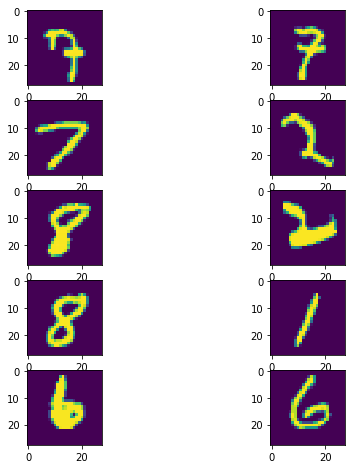

In [400]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(8, 8))

for i, axi in enumerate(ax):
    axi[0].imshow(a[i, 0, :].reshape(28, 28))
    axi[1].imshow(a[i, 1, :].reshape(28, 28))

In [401]:
b

array([[1],
       [0],
       [0],
       [0],
       [1]])

In [390]:
X_train1 = X_train
X_train2 = X_val

y_train1 = y_train
y_train2 = y_val

X_train1.shape, X_train2.shape, y_train1.shape, y_train2.shape

((55000, 784), (5000, 784), (55000,), (5000,))

In [406]:
X_test1, y_test1 = generating_batch(X_test, y_test, batch_size=len(X_test))

In [403]:
X_test1.shape, y_test1.shape

((10000, 2, 784), (10000, 1))

In [408]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size + 1):
            X_batch, y_batch = generating_batch(X_train1, y_train1, batch_size)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            
        if epoch % 5 == 0:
            ts_acc = accuracy.eval(feed_dict={X:X_test1, y:y_test1})
            print("Epoch {:3d}, test-acc: {:.4f}".format(epoch, ts_acc))
    saver.save(sess, './my_digit_comparison_model.ckpt')

Epoch   0, test-acc: 0.5429
Epoch   5, test-acc: 0.8292
Epoch  10, test-acc: 0.8909
Epoch  15, test-acc: 0.9207
Epoch  20, test-acc: 0.9370
Epoch  25, test-acc: 0.9471
Epoch  30, test-acc: 0.9545
Epoch  35, test-acc: 0.9586
Epoch  40, test-acc: 0.9642
Epoch  45, test-acc: 0.9682
Epoch  50, test-acc: 0.9695
Epoch  55, test-acc: 0.9719
Epoch  60, test-acc: 0.9729
Epoch  65, test-acc: 0.9747
Epoch  70, test-acc: 0.9758
Epoch  75, test-acc: 0.9755
Epoch  80, test-acc: 0.9773
Epoch  85, test-acc: 0.9763
Epoch  90, test-acc: 0.9770
Epoch  95, test-acc: 0.9778


In [413]:
reset_graph()

n_inputs = 28*28
n_outputs = 10

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None, ), dtype=tf.int32, name='y')

dnn_output = dnn(X, name='dnn_A')
frozen_dnn = tf.stop_gradient(dnn_output)

logits = tf.layers.dense(frozen_dnn, n_outputs, activation=None, kernel_initializer=he_init, name='logits')
y_proba = tf.nn.softmax(logits, name='logits')

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy, name='loss')

learning_rate = .01
momentum = .95
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, k=1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

dnn_A_vars = {var.op.name: var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='dnn_A')}
restore_dnn_A_saver = tf.train.Saver(var_list=dnn_A_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [416]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_dnn_A_saver.restore(sess, './my_digit_comparison_model.ckpt')
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train2, y_train2, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        var_acc = accuracy.eval(feed_dict={X:X_test, y:y_test})
        if epoch%5==0:
            print("Epoch {:3d}, var-acc: {:.4f}".format(epoch, var_acc))

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
Epoch   0, var-acc: 0.9702
Epoch   5, var-acc: 0.9736
Epoch  10, var-acc: 0.9743
Epoch  15, var-acc: 0.9737
Epoch  20, var-acc: 0.9744
Epoch  25, var-acc: 0.9749
Epoch  30, var-acc: 0.9753
Epoch  35, var-acc: 0.9747
Epoch  40, var-acc: 0.9742
Epoch  45, var-acc: 0.9744
Epoch  50, var-acc: 0.9750
Epoch  55, var-acc: 0.9743
Epoch  60, var-acc: 0.9744
Epoch  65, var-acc: 0.9741
Epoch  70, var-acc: 0.9742
Epoch  75, var-acc: 0.9740
Epoch  80, var-acc: 0.9741
Epoch  85, var-acc: 0.9738
Epoch  90, var-acc: 0.9740
Epoch  95, var-acc: 0.9742
